In [1]:
# =============================================================================
# 1. IMPORT AND INSTALL DEPENDENCIES
# =============================================================================
# If needed, install dependencies using pip (uncomment the following lines):
# !pip install opencv-python mediapipe torch torchvision scikit-learn

import os
import time
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [2]:
#!pip install transformers

In [2]:
#!pip install mediapipe

In [3]:
#!pip install scikit-learn

In [2]:
import mediapipe as mp
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Sample all videos with uniform frames (Select 60 frames out of entire video)

import os
import cv2
import mediapipe as mp
import numpy as np

# Initialize MediaPipe modules.
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def extract_all_keypoints(results):
    """
    Extract keypoint values from MediaPipe detection results.
    Returns a concatenated numpy array of pose, face, left hand, and right hand keypoints.
    """
    # Pose (33 landmarks x [x, y, z, visibility])
    pose = np.array([[res.x, res.y, res.z, res.visibility] 
                     for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33 * 4)
    # Face (468 landmarks x [x, y, z])
    face = np.array([[res.x, res.y, res.z] 
                     for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468 * 3)
    # Left hand (21 landmarks x [x, y, z])
    lh = np.array([[res.x, res.y, res.z] 
                   for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21 * 3)
    # Right hand (21 landmarks x [x, y, z])
    rh = np.array([[res.x, res.y, res.z] 
                   for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21 * 3)
    return np.concatenate([pose, face, lh, rh])

def sample_frames_uniformly(frames, target_count=60):
    """
    Given a list of frames, return exactly 'target_count' frames by uniformly sampling (or repeating).
    """
    num_frames = len(frames)
    if num_frames == 0:
        return []
    if num_frames == target_count:
        return frames
    sampled = []
    if num_frames > target_count:
        # Downsample: select 60 frames uniformly
        for i in range(target_count):
            idx = int(round(i * (num_frames - 1) / (target_count - 1)))
            sampled.append(frames[idx])
    else:
        # Upsample: repeat frames to reach target_count
        for i in range(target_count):
            idx = int(round(i * (num_frames - 1) / (target_count - 1)))
            sampled.append(frames[idx])
    return sampled

def process_video_and_save_frames(video_path, output_folder, target_frames=60):
    """
    Reads a video, uniformly samples exactly 'target_frames' frames,
    processes each sampled frame with MediaPipe Holistic to extract keypoints,
    and saves each frame's keypoints as a separate .npy file in 'output_folder'.
    """
    # Create output folder if it doesn't exist.
    os.makedirs(output_folder, exist_ok=True)
    
    # 1. Read all frames from the video.
    cap = cv2.VideoCapture(video_path)
    all_frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        all_frames.append(frame)
    cap.release()
    
    # 2. Uniformly sample frames to get exactly 'target_frames' frames.
    sampled_frames = sample_frames_uniformly(all_frames, target_count=target_frames)
    
    # 3. Process each sampled frame and save keypoints.
    with mp_holistic.Holistic(min_detection_confidence=0.5, 
                              min_tracking_confidence=0.5) as holistic:
        for i, frm in enumerate(sampled_frames):
            image = cv2.cvtColor(frm, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = holistic.process(image)
            # Extract keypoints
            keypoints = extract_all_keypoints(results)
            # Save each frame's keypoints as a separate .npy file.
            output_file = os.path.join(output_folder, f"frame_{i}.npy")
            np.save(output_file, keypoints)
            print(f"Saved {output_file}, shape: {keypoints.shape}")

# -----------------------------------------------------------------------------
# MAIN EXECUTION
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    # Define classes. For example, these folders are expected under './dataset'.
    actions = [
    "Baby",
    "Bill",
    "Boy",
    "Brother",
    "cold",
    "Daughter",
    "Deaf",
    "Doctor",
    "dry",
    "Family",
    "Father",
    "Girl",
    "healthy",
    "Heavy",
    "High",
    "Hospital",
    "Medicine",
    "Money",
    "Mother",
    "Patient",
    "sick",
    "Sister",
    "Son",
    "Weak"
]


    dataset_dir = "./dataset"  # This is where your video files are stored, one folder per class.
    
    # Define a separate output folder for extracted keypoints to avoid clutter.
    output_root = "./extracted_keypoints"
    os.makedirs(output_root, exist_ok=True)
    
    # Process each class folder.
    for action in actions:
        class_folder = os.path.join(dataset_dir, action)
        # Create a corresponding output folder for the class.
        output_class_folder = os.path.join(output_root, action)
        os.makedirs(output_class_folder, exist_ok=True)
        
        # List all video files in the class folder.
        video_files = [vf for vf in os.listdir(class_folder) 
                       if vf.lower().endswith((".mp4", ".avi", ".mov"))]
        
        # Process each video file.
        for video_file in video_files:
            video_path = os.path.join(class_folder, video_file)
            # Create an output subfolder for this video to store its 60 .npy files.
            base_name = os.path.splitext(video_file)[0]
            video_output_folder = os.path.join(output_class_folder, base_name)
            os.makedirs(video_output_folder, exist_ok=True)
            
            print(f"Processing video: {video_path}")
            process_video_and_save_frames(video_path, video_output_folder, target_frames=60)
    
    print("All videos processed: 60 keypoint .npy files per video have been saved.")


Processing video: ./dataset/Baby/baby1.2.mp4


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/baby1.2/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.2/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.2/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.2/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.2/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.2/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.2/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.2/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.2/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.2/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.2/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.2/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.2/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.2/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Ba

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_4066/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4066/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4066/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4066/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4066/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4066/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4066/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4066/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4066/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4066/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4066/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4066/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4066/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4066/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_5234/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5234/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5234/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5234/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5234/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5234/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5234/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5234/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5234/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5234/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5234/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5234/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5234/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5234/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_4226/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4226/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4226/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4226/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4226/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4226/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4226/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4226/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4226/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4226/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4226/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4226/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4226/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4226/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_8628/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_8628/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_8628/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_8628/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_8628/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_8628/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_8628/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_8628/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_8628/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_8628/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_8628/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_8628/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_8628/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_8628/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_4948/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4948/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4948/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4948/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4948/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4948/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4948/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4948/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4948/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4948/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4948/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4948/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4948/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4948/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_4947/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4947/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4947/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4947/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4947/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4947/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4947/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4947/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4947/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4947/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4947/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4947/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4947/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4947/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/baby3/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby3/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby3/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby3/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby3/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby3/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby3/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby3/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby3/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby3/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby3/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby3/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby3/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby3/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby3/frame_14.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/baby14/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby14/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby14/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby14/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby14/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby14/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby14/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby14/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby14/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby14/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby14/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby14/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby14/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby14/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby14/fram

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_5086/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5086/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5086/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5086/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5086/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5086/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5086/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5086/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5086/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5086/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5086/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5086/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5086/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5086/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_3770/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3770/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3770/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3770/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3770/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3770/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3770/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3770/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3770/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3770/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3770/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3770/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3770/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3770/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_3918/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3918/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3918/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3918/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3918/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3918/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3918/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3918/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3918/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3918/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3918/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3918/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3918/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3918/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/baby1.1/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.1/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.1/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.1/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.1/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.1/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.1/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.1/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.1/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.1/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.1/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.1/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.1/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby1.1/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/B

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/baby5/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby5/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby5/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby5/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby5/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby5/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby5/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby5/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby5/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby5/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby5/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby5/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby5/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby5/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby5/frame_14.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_4946/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4946/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4946/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4946/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4946/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4946/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4946/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4946/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4946/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4946/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4946/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4946/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4946/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4946/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_3769/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3769/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3769/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3769/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3769/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3769/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3769/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3769/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3769/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3769/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3769/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3769/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3769/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3769/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/baby11/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby11/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby11/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby11/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby11/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby11/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby11/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby11/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby11/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby11/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby11/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby11/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby11/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby11/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby11/fram

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_3771/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3771/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3771/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3771/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3771/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3771/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3771/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3771/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3771/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3771/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3771/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3771/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3771/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3771/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_5088/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5088/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5088/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5088/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5088/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5088/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5088/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5088/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5088/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5088/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5088/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5088/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5088/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5088/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_3917/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3917/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3917/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3917/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3917/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3917/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3917/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3917/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3917/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3917/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3917/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3917/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3917/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3917/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/baby7/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby7/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby7/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby7/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby7/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby7/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby7/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby7/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby7/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby7/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby7/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby7/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby7/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby7/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby7/frame_14.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/baby10/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby10/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby10/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby10/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby10/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby10/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby10/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby10/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby10/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby10/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby10/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby10/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby10/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby10/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby10/fram

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/baby9/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby9/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby9/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby9/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby9/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby9/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby9/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby9/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby9/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby9/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby9/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby9/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby9/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby9/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/baby9/frame_14.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_3919/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3919/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3919/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3919/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3919/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3919/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3919/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3919/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3919/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3919/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3919/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3919/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3919/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_3919/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_4068/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4068/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4068/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4068/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4068/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4068/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4068/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4068/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4068/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4068/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4068/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4068/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4068/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4068/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_5235/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5235/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5235/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5235/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5235/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5235/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5235/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5235/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5235/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5235/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5235/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5235/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5235/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5235/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_5087/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5087/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5087/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5087/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5087/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5087/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5087/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5087/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5087/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5087/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5087/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5087/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5087/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5087/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_4067/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4067/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4067/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4067/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4067/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4067/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4067/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4067/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4067/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4067/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4067/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4067/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4067/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_4067/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Baby/MVI_5236/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5236/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5236/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5236/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5236/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5236/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5236/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5236/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5236/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5236/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5236/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5236/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5236/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Baby/MVI_5236/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/bill10/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill10/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill10/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill10/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill10/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill10/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill10/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill10/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill10/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill10/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill10/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill10/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill10/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill10/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill10/fram

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/MVI_4811/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4811/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4811/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4811/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4811/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4811/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4811/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4811/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4811/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4811/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4811/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4811/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4811/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4811/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/MVI_8676/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8676/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8676/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8676/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8676/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8676/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8676/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8676/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8676/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8676/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8676/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8676/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8676/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8676/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/MVI_4810/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4810/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4810/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4810/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4810/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4810/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4810/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4810/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4810/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4810/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4810/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4810/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4810/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4810/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/bill11/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill11/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill11/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill11/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill11/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill11/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill11/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill11/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill11/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill11/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill11/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill11/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill11/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill11/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill11/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/bill13/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill13/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill13/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill13/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill13/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill13/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill13/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill13/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill13/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill13/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill13/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill13/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill13/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill13/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill13/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/bill12/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill12/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill12/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill12/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill12/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill12/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill12/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill12/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill12/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill12/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill12/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill12/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill12/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill12/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill12/fram

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/MVI_8939/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8939/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8939/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8939/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8939/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8939/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8939/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8939/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8939/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8939/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8939/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8939/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8939/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8939/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/bill1/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill1/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill1/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill1/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill1/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill1/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill1/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill1/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill1/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill1/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill1/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill1/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill1/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill1/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill1/frame_14.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/bill4/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill4/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill4/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill4/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill4/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill4/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill4/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill4/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill4/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill4/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill4/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill4/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill4/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill4/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill4/frame_14.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/bill15/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill15/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill15/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill15/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill15/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill15/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill15/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill15/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill15/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill15/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill15/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill15/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill15/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill15/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill15/fram

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/bill6/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill6/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill6/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill6/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill6/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill6/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill6/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill6/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill6/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill6/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill6/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill6/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill6/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill6/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill6/frame_15.npy, shap

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/bill16/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill16/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill16/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill16/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill16/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill16/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill16/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill16/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill16/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill16/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill16/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill16/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill16/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill16/frame_15.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill16/fr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/MVI_4267/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4267/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4267/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4267/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4267/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4267/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4267/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4267/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4267/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4267/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4267/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4267/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4267/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4267/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/MVI_4268/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4268/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4268/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4268/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4268/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4268/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4268/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4268/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4268/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4268/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4268/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4268/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4268/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4268/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/MVI_8674/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8674/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8674/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8674/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8674/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8674/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8674/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8674/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8674/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8674/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8674/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8674/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8674/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8674/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/bill17/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill17/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill17/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill17/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill17/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill17/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill17/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill17/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill17/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill17/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill17/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill17/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill17/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill17/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill17/fram

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/bill9/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill9/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill9/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill9/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill9/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill9/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill9/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill9/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill9/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill9/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill9/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill9/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill9/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill9/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill9/frame_15.npy, shap

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/MVI_8941/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8941/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8941/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8941/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8941/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8941/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8941/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8941/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8941/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8941/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8941/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8941/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8941/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8941/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/MVI_8673/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8673/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8673/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8673/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8673/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8673/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8673/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8673/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8673/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8673/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8673/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8673/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8673/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8673/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/bill3/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill3/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill3/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill3/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill3/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill3/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill3/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill3/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill3/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill3/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill3/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill3/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill3/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill3/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill3/frame_14.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/bill5/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill5/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill5/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill5/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill5/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill5/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill5/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill5/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill5/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill5/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill5/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill5/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill5/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill5/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill5/frame_14.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/bill2/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill2/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill2/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill2/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill2/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill2/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill2/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill2/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill2/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill2/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill2/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill2/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill2/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill2/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill2/frame_14.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/bill14/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill14/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill14/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill14/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill14/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill14/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill14/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill14/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill14/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill14/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill14/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill14/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill14/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill14/frame_15.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/bill14/fr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/MVI_4269/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4269/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4269/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4269/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4269/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4269/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4269/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4269/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4269/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4269/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4269/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4269/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4269/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4269/frame_15.npy, shape: (1662,)
Saved ./extrac

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/MVI_8675/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8675/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8675/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8675/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8675/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8675/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8675/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8675/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8675/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8675/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8675/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8675/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8675/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8675/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/MVI_8940/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8940/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8940/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8940/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8940/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8940/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8940/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8940/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8940/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8940/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8940/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8940/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8940/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_8940/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/MVI_4809/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4809/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4809/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4809/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4809/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4809/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4809/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4809/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4809/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4809/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4809/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4809/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4809/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4809/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Bill/MVI_4270/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4270/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4270/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4270/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4270/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4270/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4270/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4270/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4270/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4270/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4270/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4270/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4270/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bill/MVI_4270/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_3962/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3962/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3962/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3962/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3962/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3962/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3962/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3962/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3962/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3962/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3962/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3962/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3962/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3962/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_4112/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4112/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4112/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4112/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4112/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4112/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4112/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4112/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4112/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4112/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4112/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4112/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4112/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4112/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/boy11/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy11/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy11/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy11/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy11/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy11/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy11/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy11/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy11/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy11/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy11/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy11/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy11/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy11/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy11/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_4242/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4242/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4242/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4242/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4242/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4242/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4242/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4242/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4242/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4242/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4242/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4242/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4242/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4242/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/boy5/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy5/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy5/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy5/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy5/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy5/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy5/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy5/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy5/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy5/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy5/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy5/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy5/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy5/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy5/frame_14.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_5133/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5133/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5133/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5133/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5133/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5133/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5133/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5133/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5133/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5133/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5133/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5133/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5133/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5133/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_3816/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3816/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3816/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3816/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3816/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3816/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3816/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3816/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3816/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3816/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3816/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3816/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3816/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3816/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/B

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_5285/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5285/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5285/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5285/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5285/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5285/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5285/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5285/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5285/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5285/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5285/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5285/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5285/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5285/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_3964/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3964/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3964/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3964/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3964/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3964/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3964/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3964/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3964/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3964/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3964/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3964/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3964/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3964/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_4110/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4110/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4110/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4110/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4110/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4110/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4110/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4110/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4110/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4110/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4110/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4110/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4110/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4110/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_3963/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3963/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3963/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3963/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3963/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3963/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3963/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3963/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3963/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3963/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3963/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3963/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3963/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3963/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_4111/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4111/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4111/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4111/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4111/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4111/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4111/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4111/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4111/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4111/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4111/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4111/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4111/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4111/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_4983/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4983/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4983/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4983/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4983/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4983/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4983/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4983/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4983/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4983/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4983/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4983/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4983/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4983/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_4109/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4109/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4109/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4109/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4109/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4109/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4109/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4109/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4109/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4109/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4109/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4109/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4109/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4109/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/boy13/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy13/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy13/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy13/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy13/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy13/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy13/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy13/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy13/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy13/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy13/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy13/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy13/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy13/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy13/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/boy2/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy2/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy2/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy2/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy2/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy2/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy2/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy2/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy2/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy2/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy2/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy2/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy2/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy2/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy2/frame_14.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/boy14/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy14/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy14/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy14/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy14/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy14/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy14/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy14/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy14/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy14/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy14/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy14/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy14/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy14/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy14/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_5287/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5287/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5287/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5287/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5287/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5287/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5287/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5287/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5287/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5287/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5287/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5287/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5287/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5287/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/boy16/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy16/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy16/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy16/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy16/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy16/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy16/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy16/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy16/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy16/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy16/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy16/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy16/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy16/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy16/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_8644/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_8644/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_8644/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_8644/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_8644/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_8644/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_8644/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_8644/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_8644/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_8644/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_8644/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_8644/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_8644/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_8644/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_4981/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4981/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4981/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4981/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4981/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4981/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4981/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4981/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4981/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4981/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4981/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4981/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4981/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4981/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_5134/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5134/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5134/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5134/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5134/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5134/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5134/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5134/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5134/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5134/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5134/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5134/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5134/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5134/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_3814/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3814/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3814/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3814/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3814/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3814/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3814/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3814/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3814/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3814/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3814/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3814/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3814/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3814/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_3815/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3815/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3815/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3815/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3815/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3815/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3815/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3815/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3815/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3815/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3815/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3815/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3815/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_3815/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/boy3/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy3/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy3/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy3/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy3/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy3/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy3/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy3/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy3/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy3/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy3/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy3/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy3/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy3/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy3/frame_14.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_4982/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4982/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4982/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4982/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4982/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4982/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4982/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4982/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4982/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4982/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4982/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4982/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4982/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_4982/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/boy4/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy4/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy4/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy4/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy4/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy4/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy4/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy4/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy4/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy4/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy4/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy4/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy4/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy4/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/boy4/frame_14.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_5286/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5286/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5286/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5286/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5286/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5286/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5286/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5286/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5286/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5286/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5286/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5286/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5286/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5286/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Boy/MVI_5132/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5132/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5132/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5132/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5132/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5132/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5132/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5132/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5132/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5132/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5132/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5132/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5132/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Boy/MVI_5132/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Bo

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_5097/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5097/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5097/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5097/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5097/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5097/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5097/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5097/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5097/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5097/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5097/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5097/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5097/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5097/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/brother14/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother14/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother14/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother14/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother14/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother14/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother14/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother14/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother14/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother14/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother14/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother14/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother14/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Brothe

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_5243/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5243/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5243/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5243/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5243/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5243/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5243/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5243/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5243/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5243/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5243/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5243/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5243/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5243/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_3781/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3781/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3781/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3781/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3781/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3781/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3781/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3781/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3781/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3781/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3781/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3781/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3781/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3781/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_5245/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5245/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5245/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5245/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5245/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5245/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5245/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5245/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5245/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5245/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5245/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5245/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5245/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5245/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/brother1/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother1/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother1/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother1/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother1/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother1/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother1/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother1/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother1/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother1/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother1/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother1/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother1/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother1/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_4077/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4077/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4077/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4077/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4077/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4077/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4077/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4077/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4077/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4077/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4077/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4077/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4077/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4077/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_3928/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3928/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3928/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3928/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3928/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3928/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3928/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3928/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3928/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3928/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3928/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3928/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3928/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3928/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/brother6/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother6/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother6/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother6/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother6/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother6/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother6/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother6/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother6/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother6/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother6/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother6/frame_15.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother6/frame_16.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother6

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_4957/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4957/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4957/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4957/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4957/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4957/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4957/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4957/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4957/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4957/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4957/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4957/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4957/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4957/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_3929/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3929/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3929/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3929/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3929/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3929/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3929/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3929/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3929/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3929/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3929/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3929/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3929/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3929/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_4956/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4956/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4956/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4956/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4956/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4956/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4956/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4956/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4956/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4956/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4956/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4956/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4956/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4956/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_5096/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5096/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5096/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5096/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5096/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5096/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5096/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5096/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5096/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5096/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5096/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5096/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5096/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5096/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_4230/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4230/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4230/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4230/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4230/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4230/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4230/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4230/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4230/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4230/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4230/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4230/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4230/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4230/fr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/brother11/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother11/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother11/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother11/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother11/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother11/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother11/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother11/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother11/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother11/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother11/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother11/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother11/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Broth

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_3780/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3780/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3780/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3780/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3780/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3780/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3780/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3780/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3780/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3780/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3780/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3780/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3780/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3780/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/brother9/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother9/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother9/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother9/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother9/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother9/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother9/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother9/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother9/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother9/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother9/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother9/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother9/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother9/f

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_4076/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4076/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4076/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4076/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4076/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4076/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4076/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4076/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4076/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4076/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4076/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4076/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4076/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4076/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/brother5/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother5/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother5/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother5/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother5/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother5/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother5/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother5/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother5/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother5/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother5/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother5/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother5/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother5/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_5095/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5095/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5095/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5095/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5095/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5095/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5095/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5095/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5095/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5095/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5095/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5095/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5095/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5095/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_5244/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5244/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5244/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5244/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5244/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5244/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5244/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5244/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5244/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5244/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5244/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5244/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5244/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_5244/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_3779/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3779/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3779/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3779/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3779/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3779/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3779/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3779/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3779/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3779/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3779/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3779/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3779/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3779/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/brother8/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother8/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother8/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother8/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother8/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother8/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother8/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother8/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother8/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother8/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother8/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother8/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother8/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother8/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_3778/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3778/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3778/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3778/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3778/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3778/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3778/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3778/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3778/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3778/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3778/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3778/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3778/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3778/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_3927/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3927/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3927/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3927/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3927/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3927/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3927/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3927/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3927/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3927/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3927/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3927/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3927/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_3927/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_8631/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_8631/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_8631/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_8631/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_8631/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_8631/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_8631/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_8631/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_8631/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_8631/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_8631/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_8631/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_8631/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_8631/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/brother12/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother12/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother12/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother12/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother12/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother12/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother12/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother12/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother12/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother12/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother12/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother12/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/brother12/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_4075/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4075/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4075/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4075/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4075/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4075/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4075/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4075/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4075/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4075/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4075/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4075/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4075/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4075/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Brother/MVI_4955/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4955/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4955/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4955/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4955/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4955/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4955/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4955/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4955/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4955/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4955/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4955/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4955/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Brother/MVI_4955/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_5139/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5139/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5139/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5139/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5139/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5139/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5139/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5139/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5139/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5139/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5139/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5139/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5139/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5139/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_5140/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5140/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5140/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5140/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5140/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5140/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5140/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5140/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5140/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5140/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5140/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5140/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5140/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5140/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/cold_3/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_3/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_3/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_3/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_3/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_3/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_3/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_3/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_3/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_3/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_3/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_3/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_3/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_3/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_3/fram

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/cold_1/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_1/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_1/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_1/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_1/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_1/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_1/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_1/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_1/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_1/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_1/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_1/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_1/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_1/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_1/fram

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_9332/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9332/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9332/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9332/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9332/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9332/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9332/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9332/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9332/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9332/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9332/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9332/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9332/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9332/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_9413/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9413/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9413/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9413/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9413/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9413/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9413/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9413/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9413/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9413/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9413/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9413/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9413/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9413/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_9252/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9252/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9252/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9252/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9252/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9252/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9252/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9252/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9252/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9252/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9252/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9252/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9252/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9252/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/cold_7/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_7/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_7/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_7/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_7/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_7/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_7/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_7/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_7/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_7/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_7/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_7/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_7/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_7/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_7/fram

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/cold_6/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_6/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_6/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_6/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_6/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_6/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_6/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_6/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_6/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_6/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_6/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_6/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_6/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_6/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_6/fram

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/cold_2/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_2/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_2/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_2/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_2/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_2/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_2/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_2/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_2/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_2/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_2/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_2/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_2/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_2/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_2/fram

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_9491/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9491/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9491/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9491/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9491/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9491/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9491/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9491/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9491/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9491/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9491/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9491/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9491/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9491/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_9331/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9331/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9331/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9331/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9331/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9331/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9331/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9331/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9331/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9331/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9331/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9331/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9331/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9331/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_9333/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9333/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9333/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9333/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9333/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9333/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9333/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9333/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9333/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9333/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9333/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9333/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9333/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9333/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_9490/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9490/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9490/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9490/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9490/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9490/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9490/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9490/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9490/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9490/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9490/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9490/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9490/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9490/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_9492/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9492/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9492/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9492/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9492/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9492/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9492/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9492/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9492/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9492/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9492/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9492/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9492/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9492/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_9412/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9412/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9412/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9412/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9412/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9412/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9412/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9412/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9412/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9412/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9412/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9412/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9412/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9412/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/cold_10/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_10/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_10/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_10/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_10/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_10/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_10/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_10/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_10/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_10/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_10/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_10/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_10/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_10/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/co

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/cold_8/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_8/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_8/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_8/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_8/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_8/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_8/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_8/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_8/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_8/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_8/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_8/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_8/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_8/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_8/fram

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_5221/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5221/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5221/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5221/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5221/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5221/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5221/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5221/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5221/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5221/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5221/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5221/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5221/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5221/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/cold_9/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_9/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_9/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_9/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_9/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_9/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_9/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_9/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_9/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_9/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_9/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_9/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_9/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_9/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_9/fram

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_9411/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9411/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9411/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9411/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9411/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9411/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9411/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9411/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9411/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9411/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9411/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9411/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9411/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9411/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_5300/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5300/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5300/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5300/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5300/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5300/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5300/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5300/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5300/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5300/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5300/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5300/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5300/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5300/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/cold_5/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_5/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_5/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_5/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_5/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_5/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_5/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_5/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_5/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_5/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_5/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_5/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_5/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_5/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/cold_5/fram

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_5220/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5220/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5220/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5220/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5220/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5220/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5220/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5220/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5220/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5220/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5220/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5220/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5220/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5220/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_5298/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5298/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5298/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5298/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5298/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5298/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5298/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5298/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5298/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5298/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5298/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5298/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5298/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5298/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_5299/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5299/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5299/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5299/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5299/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5299/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5299/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5299/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5299/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5299/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5299/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5299/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5299/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5299/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_9251/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9251/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9251/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9251/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9251/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9251/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9251/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9251/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9251/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9251/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9251/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9251/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9251/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9251/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_5219/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5219/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5219/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5219/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5219/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5219/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5219/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5219/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5219/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5219/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5219/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5219/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5219/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_5219/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/cold/MVI_9250/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9250/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9250/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9250/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9250/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9250/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9250/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9250/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9250/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9250/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9250/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9250/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9250/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/cold/MVI_9250/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_3756/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3756/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3756/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3756/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3756/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3756/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3756/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3756/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3756/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3756/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3756/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3756/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3756/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_5076/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5076/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5076/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5076/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5076/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5076/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5076/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5076/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5076/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5076/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5076/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5076/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5076/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/daughter15 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter15 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter15 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter15 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter15 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter15 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter15 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter15 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter15 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter15 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/daughter13 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter13 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter13 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter13 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter13 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter13 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter13 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter13 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter13 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter13 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_5222/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5222/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5222/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5222/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5222/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5222/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5222/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5222/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5222/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5222/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5222/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5222/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5222/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_4221/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4221/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4221/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4221/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4221/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4221/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4221/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4221/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4221/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4221/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4221/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4221/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4221/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_5074/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5074/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5074/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5074/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5074/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5074/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5074/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5074/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5074/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5074/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5074/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5074/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5074/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_5075/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5075/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5075/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5075/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5075/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5075/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5075/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5075/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5075/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5075/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5075/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5075/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5075/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_4936/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4936/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4936/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4936/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4936/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4936/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4936/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4936/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4936/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4936/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4936/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4936/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4936/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/daughter14 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter14 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter14 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter14 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter14 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter14 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter14 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter14 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter14 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter14 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_3904/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3904/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3904/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3904/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3904/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3904/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3904/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3904/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3904/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3904/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3904/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3904/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3904/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_4054/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4054/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4054/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4054/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4054/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4054/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4054/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4054/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4054/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4054/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4054/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4054/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4054/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_4935/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4935/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4935/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4935/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4935/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4935/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4935/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4935/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4935/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4935/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4935/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4935/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4935/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/daughter4 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter4 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter4 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter4 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter4 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter4 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter4 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter4 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter4 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter4 - Made with Clipchamp/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/D

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_3905/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3905/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3905/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3905/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3905/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3905/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3905/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3905/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3905/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3905/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3905/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3905/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3905/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_3903/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3903/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3903/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3903/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3903/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3903/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3903/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3903/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3903/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3903/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3903/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3903/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3903/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/daughter17 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter17 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter17 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter17 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter17 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter17 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter17 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter17 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter17 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter17 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_5221/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5221/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5221/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5221/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5221/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5221/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5221/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5221/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5221/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5221/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5221/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5221/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5221/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/daughter3 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter3 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter3 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter3 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter3 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter3 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter3 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter3 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter3 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter3 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Da

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/daughter16 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter16 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter16 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter16 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter16 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter16 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter16 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter16 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter16 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter16 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_4055/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4055/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4055/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4055/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4055/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4055/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4055/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4055/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4055/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4055/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4055/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4055/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4055/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_8624/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_8624/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_8624/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_8624/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_8624/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_8624/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_8624/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_8624/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_8624/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_8624/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_8624/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_8624/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_8624/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_5223/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5223/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5223/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5223/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5223/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5223/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5223/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5223/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5223/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5223/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5223/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5223/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_5223/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_3757/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3757/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3757/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3757/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3757/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3757/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3757/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3757/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3757/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3757/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3757/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3757/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3757/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Daught

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_4056/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4056/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4056/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4056/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4056/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4056/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4056/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4056/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4056/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4056/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4056/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4056/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4056/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Daught

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/daughter2 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter2 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter2 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter2 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter2 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter2 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter2 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter2 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter2 - Made with Clipchamp/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter2 - Made with Clipchamp/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_3758/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3758/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3758/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3758/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3758/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3758/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3758/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3758/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3758/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3758/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3758/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3758/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_3758/frame_15.npy, shape: (1662,)
Saved ./extracted_keypoints/Daug

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/MVI_4934/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4934/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4934/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4934/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4934/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4934/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4934/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4934/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4934/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4934/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4934/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4934/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/MVI_4934/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Daughter/daughter1 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter1 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter1 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter1 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter1 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter1 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter1 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter1 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter1 - Made with Clipchamp/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Daughter/daughter1 - Made with Clipchamp/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_11/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_11/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_11/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_11/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_11/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_11/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_11/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_11/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_11/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_11/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_11/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_11/frame_15.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/v

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/MVI_9849/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9849/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9849/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9849/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9849/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9849/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9849/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9849/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9849/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9849/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9849/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9849/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9849/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9849/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_21/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_21/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_21/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_21/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_21/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_21/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_21/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_21/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_21/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_21/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_21/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_21/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_12/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_12/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_12/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_12/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_12/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_12/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_12/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_12/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_12/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_12/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_12/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_12/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_16/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_16/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_16/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_16/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_16/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_16/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_16/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_16/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_16/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_16/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_16/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_16/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_17/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_17/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_17/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_17/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_17/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_17/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_17/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_17/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_17/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_17/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_17/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_17/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_5/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_5/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_5/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_5/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_5/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_5/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_5/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_5/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_5/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_5/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_5/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_5/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_5

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_15/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_15/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_15/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_15/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_15/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_15/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_15/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_15/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_15/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_15/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_15/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_15/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/MVI_9848/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9848/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9848/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9848/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9848/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9848/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9848/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9848/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9848/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9848/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9848/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9848/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9848/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9848/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/MVI_9851/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9851/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9851/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9851/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9851/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9851/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9851/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9851/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9851/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9851/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9851/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9851/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9851/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9851/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_6/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_6/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_6/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_6/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_6/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_6/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_6/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_6/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_6/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_6/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_6/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_6/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_6

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_2 (1)/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_2 (1)/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_2 (1)/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_2 (1)/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_2 (1)/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_2 (1)/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_2 (1)/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_2 (1)/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_2 (1)/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_2 (1)/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_2 (1)/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_2 (1)/frame_11.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/MVI_9582/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9582/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9582/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9582/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9582/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9582/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9582/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9582/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9582/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9582/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9582/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9582/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9582/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9582/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_1 (1)/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_1 (1)/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_1 (1)/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_1 (1)/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_1 (1)/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_1 (1)/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_1 (1)/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_1 (1)/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_1 (1)/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_1 (1)/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_1 (1)/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_1 (1)/frame_12.npy, shape: (1662,)
S

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_4 (1)/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_4 (1)/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_4 (1)/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_4 (1)/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_4 (1)/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_4 (1)/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_4 (1)/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_4 (1)/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_4 (1)/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_4 (1)/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_4 (1)/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_4 (1)/frame_11.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_14/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_14/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_14/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_14/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_14/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_14/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_14/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_14/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_14/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_14/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_14/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_14/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_20/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_20/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_20/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_20/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_20/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_20/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_20/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_20/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_20/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_20/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_20/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_20/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_3 (1)/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_3 (1)/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_3 (1)/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_3 (1)/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_3 (1)/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_3 (1)/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_3 (1)/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_3 (1)/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_3 (1)/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_3 (1)/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_3 (1)/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_3 (1)/frame_11.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_8/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_8/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_8/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_8/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_8/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_8/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_8/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_8/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_8/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_8/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_8/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_8/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_8

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_19/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_19/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_19/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_19/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_19/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_19/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_19/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_19/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_19/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_19/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_19/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_19/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/MVI_9583/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9583/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9583/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9583/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9583/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9583/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9583/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9583/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9583/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9583/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9583/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9583/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9583/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9583/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/MVI_9581/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9581/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9581/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9581/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9581/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9581/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9581/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9581/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9581/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9581/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9581/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9581/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9581/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9581/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_18/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_18/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_18/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_18/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_18/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_18/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_18/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_18/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_18/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_18/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_18/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_18/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/MVI_9850/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9850/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9850/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9850/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9850/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9850/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9850/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9850/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9850/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9850/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9850/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9850/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9850/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9850/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/MVI_9580/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9580/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9580/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9580/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9580/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9580/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9580/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9580/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9580/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9580/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9580/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9580/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9580/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/MVI_9580/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_7/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_7/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_7/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_7/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_7/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_7/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_7/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_7/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_7/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_7/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_7/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_7/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_7

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_13/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_13/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_13/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_13/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_13/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_13/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_13/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_13/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_13/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_13/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_13/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_13/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_10/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_10/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_10/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_10/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_10/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_10/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_10/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_10/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_10/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_10/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_10/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_10/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Deaf/video_clip_clip_9/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_9/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_9/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_9/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_9/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_9/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_9/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_9/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_9/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_9/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_9/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_9/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Deaf/video_clip_clip_9

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/MVI_8876/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8876/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8876/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8876/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8876/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8876/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8876/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8876/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8876/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8876/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8876/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8876/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8876/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8876/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/Doctor18 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor18 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor18 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor18 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor18 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor18 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor18 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor18 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor18 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor18 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor18 - Made with Clip

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/MVI_5323/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5323/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5323/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5323/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5323/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5323/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5323/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5323/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5323/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5323/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5323/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5323/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5323/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5323/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/Doctor14 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor14 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor14 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor14 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor14 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor14 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor14 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor14 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor14 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor14 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor14 - Made with Clip

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/MVI_4472/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4472/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4472/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4472/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4472/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4472/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4472/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4472/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4472/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4472/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4472/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4472/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4472/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4472/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/Doctor11 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor11 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor11 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor11 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor11 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor11 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor11 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor11 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor11 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor11 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor11 - Made with Clip

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/MVI_5325/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5325/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5325/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5325/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5325/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5325/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5325/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5325/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5325/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5325/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5325/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5325/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5325/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5325/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/Doctor10 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor10 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor10 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor10 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor10 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor10 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor10 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor10 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor10 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor10 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor10 - Made with Clip

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/Doctor3 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor3 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor3 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor3 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor3 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor3 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor3 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor3 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor3 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor3 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor3 - Made with Clipchamp/frame

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/Doctor20 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor20 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor20 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor20 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor20 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor20 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor20 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor20 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor20 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor20 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor20 - Made with Clip

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/MVI_4755/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4755/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4755/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4755/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4755/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4755/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4755/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4755/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4755/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4755/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4755/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4755/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4755/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4755/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/MVI_4470/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4470/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4470/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4470/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4470/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4470/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4470/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4470/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4470/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4470/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4470/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4470/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4470/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4470/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/Doctor9 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor9 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor9 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor9 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor9 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor9 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor9 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor9 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor9 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor9 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor9 - Made with Clipchamp/frame

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/Doctor15 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor15 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor15 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor15 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor15 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor15 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor15 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor15 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor15 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor15 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor15 - Made with Clip

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/Doctor2 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor2 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor2 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor2 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor2 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor2 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor2 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor2 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor2 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor2 - Made with Clipchamp/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor2 - Made with Clipchamp/fram

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/MVI_4471/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4471/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4471/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4471/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4471/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4471/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4471/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4471/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4471/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4471/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4471/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4471/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4471/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4471/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/MVI_4473/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4473/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4473/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4473/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4473/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4473/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4473/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4473/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4473/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4473/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4473/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4473/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4473/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4473/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/Doctor16 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor16 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor16 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor16 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor16 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor16 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor16 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor16 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor16 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor16 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor16 - Made with Clip

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/Doctor1 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor1 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor1 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor1 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor1 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor1 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor1 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor1 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor1 - Made with Clipchamp/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor1 - Made with Clipchamp/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor1 - Made with Clipchamp/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/MVI_4754/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4754/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4754/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4754/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4754/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4754/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4754/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4754/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4754/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4754/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4754/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4754/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4754/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4754/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/MVI_4757/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4757/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4757/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4757/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4757/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4757/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4757/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4757/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4757/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4757/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4757/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4757/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4757/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_4757/frame_14.npy, sh

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/MVI_8875/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8875/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8875/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8875/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8875/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8875/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8875/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8875/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8875/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8875/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8875/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8875/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8875/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8875/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/Doctor19 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor19 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor19 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor19 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor19 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor19 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor19 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor19 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor19 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor19 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor19 - Made with Clip

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/MVI_5324/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5324/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5324/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5324/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5324/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5324/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5324/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5324/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5324/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5324/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5324/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5324/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5324/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5324/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/MVI_5322/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5322/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5322/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5322/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5322/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5322/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5322/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5322/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5322/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5322/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5322/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5322/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5322/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_5322/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/MVI_8874/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8874/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8874/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8874/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8874/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8874/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8874/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8874/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8874/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8874/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8874/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8874/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8874/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/MVI_8874/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/Doctor13 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor13 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor13 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor13 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor13 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor13 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor13 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor13 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor13 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor13 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor13 - Made with Clip

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/Doctor17 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor17 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor17 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor17 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor17 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor17 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor17 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor17 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor17 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor17 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor17 - Made with Clip

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Doctor/Doctor12 - Made with Clipchamp/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor12 - Made with Clipchamp/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor12 - Made with Clipchamp/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor12 - Made with Clipchamp/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor12 - Made with Clipchamp/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor12 - Made with Clipchamp/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor12 - Made with Clipchamp/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor12 - Made with Clipchamp/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor12 - Made with Clipchamp/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor12 - Made with Clipchamp/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Doctor/Doctor12 - Made with Clip

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_9440/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9440/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9440/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9440/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9440/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9440/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9440/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9440/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9440/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9440/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9440/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9440/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9440/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9440/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/dry_5/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_5/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_5/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_5/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_5/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_5/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_5/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_5/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_5/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_5/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_5/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_5/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_5/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_5/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_5/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/dry_7/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_7/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_7/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_7/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_7/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_7/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_7/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_7/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_7/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_7/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_7/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_7/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_7/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_7/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_7/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_5326/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5326/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5326/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5326/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5326/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5326/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5326/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5326/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5326/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5326/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5326/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5326/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5326/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5326/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_9359/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9359/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9359/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9359/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9359/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9359/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9359/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9359/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9359/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9359/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9359/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9359/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9359/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9359/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_9361/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9361/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9361/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9361/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9361/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9361/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9361/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9361/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9361/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9361/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9361/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9361/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9361/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9361/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/dry_10/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_10/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_10/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_10/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_10/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_10/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_10/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_10/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_10/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_10/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_10/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_10/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_10/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_10/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_10/frame_14.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_9277/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9277/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9277/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9277/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9277/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9277/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9277/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9277/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9277/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9277/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9277/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9277/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9277/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9277/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_9278/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9278/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9278/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9278/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9278/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9278/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9278/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9278/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9278/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9278/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9278/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9278/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9278/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9278/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_5168/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5168/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5168/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5168/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5168/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5168/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5168/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5168/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5168/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5168/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5168/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5168/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5168/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5168/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_9521/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9521/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9521/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9521/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9521/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9521/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9521/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9521/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9521/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9521/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9521/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9521/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9521/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9521/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/dry_8/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_8/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_8/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_8/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_8/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_8/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_8/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_8/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_8/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_8/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_8/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_8/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_8/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_8/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_8/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_5250/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5250/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5250/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5250/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5250/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5250/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5250/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5250/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5250/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5250/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5250/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5250/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5250/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5250/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/dry_1/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_1/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_1/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_1/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_1/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_1/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_1/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_1/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_1/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_1/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_1/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_1/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_1/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_1/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_1/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_9439/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9439/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9439/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9439/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9439/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9439/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9439/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9439/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9439/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9439/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9439/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9439/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9439/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9439/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_9279/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9279/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9279/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9279/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9279/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9279/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9279/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9279/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9279/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9279/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9279/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9279/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9279/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9279/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/dry_6/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_6/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_6/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_6/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_6/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_6/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_6/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_6/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_6/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_6/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_6/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_6/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_6/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_6/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_6/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/dry_9/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_9/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_9/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_9/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_9/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_9/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_9/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_9/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_9/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_9/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_9/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_9/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_9/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_9/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_9/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/dry_2/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_2/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_2/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_2/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_2/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_2/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_2/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_2/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_2/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_2/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_2/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_2/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_2/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_2/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/dry_2/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_5328/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5328/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5328/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5328/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5328/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5328/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5328/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5328/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5328/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5328/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5328/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5328/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5328/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5328/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_5327/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5327/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5327/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5327/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5327/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5327/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5327/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5327/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5327/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5327/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5327/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5327/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5327/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5327/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_5167/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5167/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5167/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5167/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5167/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5167/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5167/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5167/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5167/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5167/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5167/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5167/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5167/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5167/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_5249/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5249/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5249/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5249/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5249/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5249/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5249/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5249/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5249/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5249/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5249/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5249/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5249/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5249/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_9441/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9441/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9441/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9441/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9441/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9441/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9441/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9441/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9441/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9441/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9441/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9441/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9441/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9441/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_9360/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9360/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9360/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9360/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9360/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9360/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9360/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9360/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9360/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9360/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9360/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9360/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9360/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9360/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_5248/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5248/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5248/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5248/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5248/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5248/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5248/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5248/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5248/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5248/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5248/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5248/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5248/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5248/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_5169/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5169/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5169/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5169/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5169/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5169/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5169/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5169/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5169/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5169/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5169/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5169/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5169/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_5169/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_9523/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9523/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9523/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9523/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9523/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9523/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9523/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9523/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9523/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9523/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9523/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9523/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9523/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9523/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/dry/MVI_9522/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9522/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9522/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9522/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9522/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9522/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9522/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9522/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9522/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9522/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9522/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9522/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9522/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/dry/MVI_9522/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/dr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/MVI_4083/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4083/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4083/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4083/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4083/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4083/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4083/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4083/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4083/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4083/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4083/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4083/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4083/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4083/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/V1-0001_Family Rock00000271/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_Family Rock00000271/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_Family Rock00000271/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_Family Rock00000271/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_Family Rock00000271/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_Family Rock00000271/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_Family Rock00000271/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_Family Rock00000271/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_Family Rock00000271/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_Family Rock00000271/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_Family Rock00000271/frame_10.npy, shape: (1662,

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/MVI_4082/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4082/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4082/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4082/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4082/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4082/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4082/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4082/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4082/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4082/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4082/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4082/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4082/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4082/frame_14.npy, sh

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/MVI_4232/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4232/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4232/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4232/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4232/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4232/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4232/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4232/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4232/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4232/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4232/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4232/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4232/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4232/frame_15.npy, s

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/V1-0014_FamilyMaa00001051/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0014_FamilyMaa00001051/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0014_FamilyMaa00001051/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0014_FamilyMaa00001051/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0014_FamilyMaa00001051/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0014_FamilyMaa00001051/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0014_FamilyMaa00001051/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0014_FamilyMaa00001051/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0014_FamilyMaa00001051/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0014_FamilyMaa00001051/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0014_FamilyMaa00001051/frame_10.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/MVI_3787/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3787/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3787/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3787/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3787/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3787/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3787/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3787/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3787/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3787/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3787/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3787/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3787/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3787/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/MVI_5250/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5250/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5250/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5250/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5250/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5250/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5250/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5250/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5250/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5250/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5250/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5250/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5250/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5250/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/V1-0015_Family Rock00001626/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_Family Rock00001626/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_Family Rock00001626/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_Family Rock00001626/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_Family Rock00001626/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_Family Rock00001626/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_Family Rock00001626/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_Family Rock00001626/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_Family Rock00001626/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_Family Rock00001626/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_Family Rock00001626/frame_10.npy, shape: (1662,

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/V1-0015_FamilyMaa00001132/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_FamilyMaa00001132/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_FamilyMaa00001132/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_FamilyMaa00001132/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_FamilyMaa00001132/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_FamilyMaa00001132/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_FamilyMaa00001132/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_FamilyMaa00001132/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_FamilyMaa00001132/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_FamilyMaa00001132/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0015_FamilyMaa00001132/frame_10.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/MVI_4081/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4081/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4081/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4081/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4081/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4081/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4081/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4081/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4081/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4081/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4081/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4081/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4081/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_4081/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/V1-0016_FamilyMaa00001211/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0016_FamilyMaa00001211/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0016_FamilyMaa00001211/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0016_FamilyMaa00001211/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0016_FamilyMaa00001211/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0016_FamilyMaa00001211/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0016_FamilyMaa00001211/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0016_FamilyMaa00001211/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0016_FamilyMaa00001211/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0016_FamilyMaa00001211/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0016_FamilyMaa00001211/frame_10.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/MVI_3933/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3933/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3933/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3933/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3933/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3933/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3933/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3933/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3933/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3933/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3933/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3933/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3933/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3933/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/MVI_3788/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3788/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3788/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3788/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3788/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3788/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3788/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3788/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3788/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3788/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3788/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3788/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3788/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3788/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/MVI_8635/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_8635/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_8635/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_8635/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_8635/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_8635/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_8635/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_8635/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_8635/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_8635/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_8635/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_8635/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_8635/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_8635/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/V1-0001_FamilyMaa00000007/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_FamilyMaa00000007/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_FamilyMaa00000007/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_FamilyMaa00000007/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_FamilyMaa00000007/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_FamilyMaa00000007/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_FamilyMaa00000007/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_FamilyMaa00000007/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_FamilyMaa00000007/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_FamilyMaa00000007/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0001_FamilyMaa00000007/frame_11.npy, shape: (1662,)
Saved ./extracted_k

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/V1-0011_Family Rock00001250/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_Family Rock00001250/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_Family Rock00001250/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_Family Rock00001250/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_Family Rock00001250/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_Family Rock00001250/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_Family Rock00001250/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_Family Rock00001250/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_Family Rock00001250/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_Family Rock00001250/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_Family Rock00001250/frame_11.npy, shape: (1662

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/MVI_5249/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5249/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5249/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5249/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5249/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5249/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5249/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5249/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5249/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5249/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5249/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5249/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5249/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5249/frame_14.npy, sh

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/MVI_3789/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3789/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3789/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3789/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3789/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3789/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3789/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3789/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3789/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3789/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3789/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3789/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3789/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3789/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/V1-0010_Family Rock00001154/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0010_Family Rock00001154/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0010_Family Rock00001154/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0010_Family Rock00001154/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0010_Family Rock00001154/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0010_Family Rock00001154/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0010_Family Rock00001154/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0010_Family Rock00001154/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0010_Family Rock00001154/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0010_Family Rock00001154/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0010_Family Rock00001154/frame_10.npy, shape: (1662,

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/V1-0011_FamilyMaa00000809/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_FamilyMaa00000809/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_FamilyMaa00000809/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_FamilyMaa00000809/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_FamilyMaa00000809/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_FamilyMaa00000809/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_FamilyMaa00000809/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_FamilyMaa00000809/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_FamilyMaa00000809/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_FamilyMaa00000809/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0011_FamilyMaa00000809/frame_10.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/MVI_3935/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3935/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3935/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3935/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3935/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3935/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3935/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3935/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3935/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3935/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3935/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3935/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3935/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3935/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/MVI_5251/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5251/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5251/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5251/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5251/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5251/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5251/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5251/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5251/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5251/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5251/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5251/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5251/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5251/frame_14.npy, sh

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/MVI_5102/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5102/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5102/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5102/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5102/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5102/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5102/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5102/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5102/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5102/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5102/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5102/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5102/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5102/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/V1-0007_FamilyMaa00000493/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0007_FamilyMaa00000493/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0007_FamilyMaa00000493/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0007_FamilyMaa00000493/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0007_FamilyMaa00000493/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0007_FamilyMaa00000493/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0007_FamilyMaa00000493/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0007_FamilyMaa00000493/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0007_FamilyMaa00000493/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0007_FamilyMaa00000493/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0007_FamilyMaa00000493/frame_10.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/MVI_3934/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3934/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3934/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3934/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3934/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3934/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3934/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3934/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3934/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3934/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3934/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3934/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3934/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_3934/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/V1-0013_Family Rock00001431/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0013_Family Rock00001431/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0013_Family Rock00001431/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0013_Family Rock00001431/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0013_Family Rock00001431/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0013_Family Rock00001431/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0013_Family Rock00001431/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0013_Family Rock00001431/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0013_Family Rock00001431/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0013_Family Rock00001431/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0013_Family Rock00001431/frame_10.npy, shape: (1662,

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/MVI_5103/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5103/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5103/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5103/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5103/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5103/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5103/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5103/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5103/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5103/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5103/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5103/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5103/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5103/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/MVI_5101/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5101/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5101/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5101/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5101/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5101/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5101/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5101/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5101/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5101/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5101/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5101/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5101/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/MVI_5101/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Family/V1-0009_FamilyMaa00000654/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0009_FamilyMaa00000654/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0009_FamilyMaa00000654/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0009_FamilyMaa00000654/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0009_FamilyMaa00000654/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0009_FamilyMaa00000654/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0009_FamilyMaa00000654/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0009_FamilyMaa00000654/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0009_FamilyMaa00000654/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0009_FamilyMaa00000654/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Family/V1-0009_FamilyMaa00000654/frame_10.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_5081/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5081/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5081/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5081/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5081/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5081/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5081/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5081/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5081/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5081/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5081/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5081/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5081/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5081/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_5228/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5228/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5228/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5228/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5228/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5228/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5228/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5228/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5228/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5228/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5228/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5228/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5228/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5228/frame_14.npy, sh

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/V1-0013_FatherRock00001210/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherRock00001210/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherRock00001210/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherRock00001210/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherRock00001210/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherRock00001210/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherRock00001210/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherRock00001210/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherRock00001210/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherRock00001210/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherRock00001210/frame_10.npy, shape: (1662,)
Saved ./e

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_5082/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5082/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5082/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5082/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5082/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5082/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5082/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5082/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5082/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5082/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5082/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5082/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5082/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5082/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_3912/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3912/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3912/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3912/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3912/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3912/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3912/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3912/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3912/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3912/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3912/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3912/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3912/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3912/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_4060/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4060/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4060/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4060/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4060/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4060/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4060/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4060/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4060/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4060/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4060/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4060/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4060/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4060/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_5229/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5229/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5229/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5229/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5229/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5229/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5229/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5229/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5229/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5229/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5229/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5229/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5229/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5229/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_3909/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3909/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3909/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3909/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3909/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3909/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3909/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3909/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3909/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3909/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3909/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3909/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3909/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3909/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_3763/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3763/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3763/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3763/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3763/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3763/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3763/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3763/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3763/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3763/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3763/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3763/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3763/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3763/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/V1-0015_FatherMaa00001814/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0015_FatherMaa00001814/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0015_FatherMaa00001814/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0015_FatherMaa00001814/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0015_FatherMaa00001814/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0015_FatherMaa00001814/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0015_FatherMaa00001814/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0015_FatherMaa00001814/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0015_FatherMaa00001814/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0015_FatherMaa00001814/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0015_FatherMaa00001814/frame_10.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_4942/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4942/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4942/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4942/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4942/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4942/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4942/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4942/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4942/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4942/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4942/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4942/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4942/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4942/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/V1-0010_FatherRock00000972/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0010_FatherRock00000972/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0010_FatherRock00000972/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0010_FatherRock00000972/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0010_FatherRock00000972/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0010_FatherRock00000972/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0010_FatherRock00000972/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0010_FatherRock00000972/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0010_FatherRock00000972/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0010_FatherRock00000972/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0010_FatherRock00000972/frame_10.npy, shape: (1662,)
Saved ./e

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_3910/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3910/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3910/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3910/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3910/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3910/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3910/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3910/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3910/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3910/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3910/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3910/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3910/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3910/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/V1-0012_FatherRock00001133/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0012_FatherRock00001133/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0012_FatherRock00001133/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0012_FatherRock00001133/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0012_FatherRock00001133/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0012_FatherRock00001133/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0012_FatherRock00001133/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0012_FatherRock00001133/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0012_FatherRock00001133/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0012_FatherRock00001133/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0012_FatherRock00001133/frame_10.npy, shape: (1662,)
Saved ./e

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/V1-0008_FatherRock00000805/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0008_FatherRock00000805/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0008_FatherRock00000805/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0008_FatherRock00000805/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0008_FatherRock00000805/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0008_FatherRock00000805/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0008_FatherRock00000805/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0008_FatherRock00000805/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0008_FatherRock00000805/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0008_FatherRock00000805/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0008_FatherRock00000805/frame_10.npy, shape: (1662,)
Saved ./e

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_4223/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4223/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4223/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4223/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4223/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4223/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4223/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4223/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4223/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4223/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4223/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4223/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4223/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4223/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_4062/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4062/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4062/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4062/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4062/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4062/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4062/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4062/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4062/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4062/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4062/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4062/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4062/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4062/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/V1-0009_FatherRock00000886/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0009_FatherRock00000886/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0009_FatherRock00000886/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0009_FatherRock00000886/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0009_FatherRock00000886/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0009_FatherRock00000886/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0009_FatherRock00000886/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0009_FatherRock00000886/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0009_FatherRock00000886/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0009_FatherRock00000886/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0009_FatherRock00000886/frame_10.npy, shape: (1662,)
Saved ./e

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_5227/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5227/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5227/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5227/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5227/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5227/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5227/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5227/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5227/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5227/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5227/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5227/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5227/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5227/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/V1-0005_FatherMaa00000655/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0005_FatherMaa00000655/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0005_FatherMaa00000655/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0005_FatherMaa00000655/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0005_FatherMaa00000655/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0005_FatherMaa00000655/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0005_FatherMaa00000655/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0005_FatherMaa00000655/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0005_FatherMaa00000655/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0005_FatherMaa00000655/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0005_FatherMaa00000655/frame_10.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_4940/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4940/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4940/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4940/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4940/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4940/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4940/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4940/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4940/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4940/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4940/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4940/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4940/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4940/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_4941/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4941/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4941/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4941/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4941/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4941/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4941/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4941/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4941/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4941/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4941/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4941/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4941/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4941/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_4061/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4061/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4061/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4061/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4061/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4061/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4061/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4061/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4061/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4061/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4061/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4061/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4061/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_4061/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/V1-0001_FatherMaa00000066/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0001_FatherMaa00000066/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0001_FatherMaa00000066/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0001_FatherMaa00000066/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0001_FatherMaa00000066/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0001_FatherMaa00000066/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0001_FatherMaa00000066/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0001_FatherMaa00000066/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0001_FatherMaa00000066/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0001_FatherMaa00000066/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0001_FatherMaa00000066/frame_10.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_3764/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3764/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3764/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3764/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3764/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3764/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3764/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3764/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3764/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3764/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3764/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3764/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3764/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3764/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_3765/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3765/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3765/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3765/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3765/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3765/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3765/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3765/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3765/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3765/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3765/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3765/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3765/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_3765/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_8626/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_8626/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_8626/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_8626/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_8626/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_8626/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_8626/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_8626/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_8626/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_8626/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_8626/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_8626/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_8626/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_8626/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/MVI_5080/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5080/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5080/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5080/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5080/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5080/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5080/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5080/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5080/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5080/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5080/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5080/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5080/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/MVI_5080/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Father/V1-0013_FatherMaa00001637/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherMaa00001637/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherMaa00001637/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherMaa00001637/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherMaa00001637/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherMaa00001637/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherMaa00001637/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherMaa00001637/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherMaa00001637/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherMaa00001637/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Father/V1-0013_FatherMaa00001637/frame_10.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_4986/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4986/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4986/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4986/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4986/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4986/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4986/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4986/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4986/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4986/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4986/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4986/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4986/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4986/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_8645/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_8645/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_8645/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_8645/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_8645/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_8645/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_8645/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_8645/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_8645/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_8645/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_8645/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_8645/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_8645/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_8645/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/V1-0005_GirlRock00000869/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlRock00000869/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlRock00000869/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlRock00000869/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlRock00000869/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlRock00000869/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlRock00000869/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlRock00000869/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlRock00000869/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlRock00000869/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlRock00000869/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlRock0000

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_5290/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5290/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5290/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5290/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5290/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5290/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5290/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5290/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5290/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5290/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5290/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5290/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5290/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5290/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_4113/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4113/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4113/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4113/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4113/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4113/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4113/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4113/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4113/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4113/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4113/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4113/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4113/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4113/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_3966/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3966/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3966/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3966/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3966/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3966/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3966/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3966/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3966/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3966/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3966/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3966/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3966/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3966/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/V1-0008_GirlRock00001103/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlRock00001103/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlRock00001103/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlRock00001103/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlRock00001103/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlRock00001103/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlRock00001103/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlRock00001103/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlRock00001103/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlRock00001103/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlRock00001103/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlRock0000

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_3817/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3817/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3817/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3817/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3817/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3817/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3817/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3817/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3817/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3817/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3817/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3817/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3817/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3817/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_4114/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4114/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4114/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4114/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4114/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4114/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4114/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4114/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4114/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4114/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4114/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4114/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4114/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4114/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_3819/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3819/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3819/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3819/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3819/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3819/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3819/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3819/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3819/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3819/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3819/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3819/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3819/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3819/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_5135/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5135/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5135/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5135/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5135/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5135/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5135/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5135/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5135/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5135/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5135/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5135/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5135/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5135/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_5288/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5288/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5288/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5288/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5288/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5288/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5288/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5288/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5288/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5288/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5288/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5288/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5288/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5288/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/V1-0005_GirlMaa00000494/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlMaa00000494/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlMaa00000494/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlMaa00000494/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlMaa00000494/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlMaa00000494/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlMaa00000494/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlMaa00000494/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlMaa00000494/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlMaa00000494/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlMaa00000494/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0005_GirlMaa00000494/frame_1

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/V1-0007_GirlMaa00000667/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlMaa00000667/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlMaa00000667/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlMaa00000667/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlMaa00000667/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlMaa00000667/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlMaa00000667/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlMaa00000667/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlMaa00000667/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlMaa00000667/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlMaa00000667/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlMaa00000667/frame_1

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/V1-0009_GirlMaa00000843/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0009_GirlMaa00000843/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0009_GirlMaa00000843/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0009_GirlMaa00000843/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0009_GirlMaa00000843/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0009_GirlMaa00000843/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0009_GirlMaa00000843/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0009_GirlMaa00000843/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0009_GirlMaa00000843/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0009_GirlMaa00000843/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0009_GirlMaa00000843/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0009_GirlMaa00000843/frame_1

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_4115/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4115/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4115/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4115/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4115/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4115/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4115/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4115/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4115/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4115/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4115/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4115/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4115/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4115/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_4984/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4984/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4984/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4984/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4984/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4984/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4984/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4984/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4984/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4984/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4984/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4984/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4984/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4984/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_3965/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3965/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3965/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3965/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3965/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3965/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3965/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3965/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3965/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3965/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3965/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3965/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3965/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3965/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_5137/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5137/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5137/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5137/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5137/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5137/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5137/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5137/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5137/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5137/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5137/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5137/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5137/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5137/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_4985/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4985/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4985/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4985/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4985/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4985/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4985/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4985/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4985/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4985/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4985/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4985/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4985/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4985/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/V1-0006_GirlRock00000941/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlRock00000941/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlRock00000941/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlRock00000941/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlRock00000941/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlRock00000941/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlRock00000941/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlRock00000941/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlRock00000941/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlRock00000941/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlRock00000941/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlRock0000

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_5289/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5289/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5289/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5289/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5289/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5289/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5289/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5289/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5289/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5289/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5289/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5289/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5289/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5289/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/V1-0008_GirlMaa00000757/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlMaa00000757/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlMaa00000757/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlMaa00000757/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlMaa00000757/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlMaa00000757/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlMaa00000757/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlMaa00000757/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlMaa00000757/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlMaa00000757/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlMaa00000757/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0008_GirlMaa00000757/frame_1

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_5136/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5136/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5136/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5136/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5136/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5136/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5136/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5136/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5136/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5136/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5136/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5136/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5136/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_5136/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/V1-0006_GirlMaa00000563/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlMaa00000563/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlMaa00000563/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlMaa00000563/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlMaa00000563/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlMaa00000563/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlMaa00000563/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlMaa00000563/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlMaa00000563/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlMaa00000563/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlMaa00000563/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0006_GirlMaa00000563/frame_1

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_4243/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4243/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4243/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4243/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4243/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4243/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4243/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4243/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4243/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4243/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4243/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4243/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4243/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_4243/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_3818/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3818/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3818/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3818/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3818/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3818/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3818/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3818/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3818/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3818/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3818/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3818/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3818/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3818/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/V1-0007_GirlRock00001023/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlRock00001023/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlRock00001023/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlRock00001023/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlRock00001023/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlRock00001023/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlRock00001023/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlRock00001023/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlRock00001023/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlRock00001023/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlRock00001023/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/V1-0007_GirlRock0000

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Girl/MVI_3967/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3967/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3967/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3967/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3967/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3967/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3967/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3967/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3967/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3967/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3967/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3967/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3967/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Girl/MVI_3967/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_9447/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9447/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9447/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9447/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9447/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9447/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9447/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9447/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9447/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9447/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9447/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9447/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9447/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9447/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_9365/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9365/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9365/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9365/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9365/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9365/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9365/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9365/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9365/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9365/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9365/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9365/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9365/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9365/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/V1-0011_HealthyRock00001064/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyRock00001064/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyRock00001064/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyRock00001064/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyRock00001064/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyRock00001064/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyRock00001064/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyRock00001064/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyRock00001064/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyRock00001064/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyRock00001064/frame_10.npy, sh

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_5254/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5254/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5254/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5254/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5254/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5254/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5254/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5254/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5254/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5254/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5254/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5254/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5254/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5254/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_9446/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9446/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9446/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9446/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9446/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9446/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9446/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9446/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9446/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9446/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9446/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9446/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9446/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9446/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/V1-0013_HealthyMaa00001695/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyMaa00001695/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyMaa00001695/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyMaa00001695/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyMaa00001695/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyMaa00001695/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyMaa00001695/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyMaa00001695/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyMaa00001695/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyMaa00001695/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyMaa00001695/frame_10.npy, shape: (1662,

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_9532/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9532/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9532/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9532/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9532/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9532/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9532/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9532/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9532/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9532/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9532/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9532/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9532/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9532/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_9367/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9367/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9367/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9367/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9367/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9367/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9367/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9367/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9367/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9367/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9367/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9367/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9367/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9367/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_9286/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9286/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9286/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9286/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9286/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9286/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9286/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9286/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9286/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9286/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9286/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9286/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9286/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9286/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/V1-0011_HealthyMaa00001515/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyMaa00001515/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyMaa00001515/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyMaa00001515/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyMaa00001515/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyMaa00001515/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyMaa00001515/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyMaa00001515/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyMaa00001515/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyMaa00001515/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0011_HealthyMaa00001515/frame_10.npy, shape: (1662,

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_9287/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9287/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9287/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9287/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9287/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9287/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9287/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9287/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9287/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9287/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9287/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9287/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9287/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9287/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_5255/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5255/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5255/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5255/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5255/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5255/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5255/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5255/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5255/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5255/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5255/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5255/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5255/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5255/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_5256/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5256/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5256/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5256/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5256/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5256/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5256/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5256/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5256/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5256/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5256/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5256/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5256/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5256/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_9366/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9366/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9366/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9366/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9366/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9366/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9366/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9366/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9366/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9366/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9366/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9366/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9366/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9366/fr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/V1-0015_HealthyMaa00002026/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0015_HealthyMaa00002026/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0015_HealthyMaa00002026/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0015_HealthyMaa00002026/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0015_HealthyMaa00002026/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0015_HealthyMaa00002026/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0015_HealthyMaa00002026/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0015_HealthyMaa00002026/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0015_HealthyMaa00002026/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0015_HealthyMaa00002026/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0015_HealthyMaa00002026/frame_10.npy, shape: (1662,

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/V1-0012_HealthyRock00001157/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyRock00001157/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyRock00001157/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyRock00001157/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyRock00001157/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyRock00001157/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyRock00001157/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyRock00001157/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyRock00001157/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyRock00001157/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyRock00001157/frame_10.npy, sh

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_5333/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5333/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5333/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5333/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5333/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5333/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5333/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5333/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5333/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5333/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5333/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5333/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5333/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5333/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/V1-0014_HealthyMaa00001781/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0014_HealthyMaa00001781/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0014_HealthyMaa00001781/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0014_HealthyMaa00001781/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0014_HealthyMaa00001781/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0014_HealthyMaa00001781/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0014_HealthyMaa00001781/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0014_HealthyMaa00001781/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0014_HealthyMaa00001781/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0014_HealthyMaa00001781/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0014_HealthyMaa00001781/frame_10.npy, shape: (1662,

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_9531/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9531/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9531/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9531/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9531/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9531/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9531/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9531/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9531/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9531/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9531/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9531/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9531/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9531/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_5174/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5174/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5174/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5174/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5174/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5174/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5174/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5174/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5174/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5174/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5174/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5174/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5174/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5174/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_5175/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5175/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5175/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5175/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5175/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5175/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5175/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5175/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5175/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5175/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5175/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5175/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5175/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5175/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/V1-0013_HealthyRock00001257/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyRock00001257/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyRock00001257/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyRock00001257/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyRock00001257/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyRock00001257/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyRock00001257/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyRock00001257/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyRock00001257/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyRock00001257/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0013_HealthyRock00001257/frame_10.npy, sh

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_9530/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9530/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9530/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9530/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9530/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9530/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9530/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9530/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9530/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9530/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9530/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9530/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9530/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9530/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_5173/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5173/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5173/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5173/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5173/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5173/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5173/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5173/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5173/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5173/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5173/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5173/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5173/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5173/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_9445/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9445/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9445/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9445/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9445/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9445/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9445/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9445/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9445/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9445/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9445/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9445/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9445/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9445/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_5332/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5332/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5332/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5332/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5332/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5332/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5332/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5332/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5332/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5332/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5332/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5332/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5332/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5332/fr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_9288/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9288/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9288/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9288/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9288/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9288/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9288/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9288/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9288/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9288/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9288/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9288/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9288/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_9288/fr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/MVI_5334/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5334/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5334/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5334/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5334/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5334/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5334/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5334/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5334/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5334/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5334/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5334/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5334/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/MVI_5334/fr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/healthy/V1-0012_HealthyMaa00001604/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyMaa00001604/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyMaa00001604/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyMaa00001604/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyMaa00001604/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyMaa00001604/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyMaa00001604/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyMaa00001604/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyMaa00001604/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyMaa00001604/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/healthy/V1-0012_HealthyMaa00001604/frame_10.npy, shape: (1662,

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/MVI_9833/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9833/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9833/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9833/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9833/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9833/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9833/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9833/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9833/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9833/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9833/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9833/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9833/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9833/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/Heavy_Harshit_02/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_02/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_02/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_02/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_02/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_02/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_02/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_02/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_02/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_02/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_02/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_02/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_02

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/MVI_9831/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9831/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9831/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9831/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9831/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9831/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9831/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9831/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9831/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9831/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9831/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9831/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9831/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9831/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/heavy3_Riddhi/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy3_Riddhi/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy3_Riddhi/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy3_Riddhi/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy3_Riddhi/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy3_Riddhi/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy3_Riddhi/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy3_Riddhi/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy3_Riddhi/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy3_Riddhi/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy3_Riddhi/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy3_Riddhi/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy3_Riddhi/frame_12.npy, shape: (1662,)
Saved ./e

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/heavy_3/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_3/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_3/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_3/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_3/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_3/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_3/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_3/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_3/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_3/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_3/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_3/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_3/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_3/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/MVI_9707/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9707/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9707/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9707/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9707/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9707/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9707/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9707/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9707/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9707/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9707/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9707/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9707/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9707/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/HeavyRudra00000651/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000651/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000651/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000651/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000651/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000651/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000651/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000651/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000651/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000651/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000651/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000651/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoint

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/MVI_9709/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9709/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9709/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9709/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9709/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9709/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9709/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9709/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9709/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9709/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9709/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9709/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9709/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9709/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/MVI_9708/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9708/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9708/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9708/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9708/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9708/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9708/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9708/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9708/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9708/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9708/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9708/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9708/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9708/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/video_clip_clip_24/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_24/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_24/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_24/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_24/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_24/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_24/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_24/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_24/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_24/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_24/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_24/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoint

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/Heavy_Harshit_03/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_03/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_03/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_03/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_03/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_03/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_03/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_03/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_03/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_03/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_03/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_03/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_03

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/video_clip_clip_25/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_25/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_25/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_25/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_25/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_25/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_25/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_25/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_25/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_25/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_25/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_25/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoint

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/heavy_5/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_5/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_5/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_5/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_5/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_5/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_5/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_5/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_5/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_5/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_5/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_5/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_5/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_5/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/heavy2_Riddhi/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy2_Riddhi/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy2_Riddhi/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy2_Riddhi/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy2_Riddhi/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy2_Riddhi/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy2_Riddhi/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy2_Riddhi/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy2_Riddhi/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy2_Riddhi/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy2_Riddhi/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy2_Riddhi/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy2_Riddhi/frame_12.npy, shape: (1662,)
Saved ./e

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/heavy1_Riddhi/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy1_Riddhi/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy1_Riddhi/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy1_Riddhi/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy1_Riddhi/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy1_Riddhi/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy1_Riddhi/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy1_Riddhi/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy1_Riddhi/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy1_Riddhi/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy1_Riddhi/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy1_Riddhi/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy1_Riddhi/frame_12.npy, shape: (1662,)
Saved ./e

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/Heavy_Harshit_04/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_04/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_04/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_04/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_04/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_04/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_04/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_04/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_04/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_04/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_04/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_04/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_04

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/heavy_4/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_4/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_4/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_4/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_4/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_4/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_4/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_4/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_4/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_4/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_4/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_4/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_4/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_4/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/heavy_1/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_1/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_1/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_1/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_1/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_1/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_1/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_1/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_1/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_1/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_1/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_1/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_1/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_1/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/Heavy_Harshit_01/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_01/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_01/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_01/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_01/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_01/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_01/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_01/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_01/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_01/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_01/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_01/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/Heavy_Harshit_01

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/HeavyRudra00000372/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000372/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000372/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000372/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000372/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000372/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000372/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000372/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000372/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000372/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000372/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000372/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoint

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/video_clip_clip_23/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_23/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_23/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_23/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_23/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_23/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_23/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_23/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_23/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_23/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_23/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_23/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoint

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/MVI_9832/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9832/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9832/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9832/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9832/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9832/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9832/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9832/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9832/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9832/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9832/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9832/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9832/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9832/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/MVI_9834/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9834/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9834/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9834/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9834/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9834/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9834/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9834/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9834/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9834/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9834/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9834/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9834/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9834/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/HeavyRudra00000557/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000557/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000557/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000557/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000557/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000557/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000557/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000557/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000557/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000557/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000557/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000557/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoint

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/heavy_2/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_2/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_2/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_2/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_2/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_2/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_2/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_2/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_2/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_2/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_2/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_2/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_2/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy_2/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/video_clip_clip_22/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_22/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_22/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_22/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_22/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_22/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_22/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_22/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_22/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_22/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_22/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/video_clip_clip_22/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoint

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/HeavyRudra00000467/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000467/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000467/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000467/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000467/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000467/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000467/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000467/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000467/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000467/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000467/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/HeavyRudra00000467/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoint

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/MVI_9710/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9710/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9710/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9710/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9710/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9710/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9710/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9710/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9710/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9710/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9710/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9710/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9710/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/MVI_9710/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Heavy/heavy4_Riddhi/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy4_Riddhi/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy4_Riddhi/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy4_Riddhi/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy4_Riddhi/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy4_Riddhi/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy4_Riddhi/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy4_Riddhi/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy4_Riddhi/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy4_Riddhi/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy4_Riddhi/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy4_Riddhi/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Heavy/heavy4_Riddhi/frame_12.npy, shape: (1662,)
Saved ./e

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/MVI_9656/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9656/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9656/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9656/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9656/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9656/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9656/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9656/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9656/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9656/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9656/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9656/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9656/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9656/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_14/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_14/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_14/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_14/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_14/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_14/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_14/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_14/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_14/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_14/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_14/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_14/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_14/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/MVI_9780/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9780/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9780/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9780/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9780/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9780/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9780/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9780/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9780/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9780/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9780/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9780/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9780/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9780/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_19/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_19/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_19/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_19/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_19/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_19/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_19/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_19/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_19/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_19/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_19/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_19/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_19/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_11/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_11/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_11/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_11/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_11/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_11/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_11/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_11/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_11/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_11/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_11/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_11/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_11/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_20/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_20/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_20/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_20/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_20/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_20/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_20/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_20/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_20/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_20/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_20/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_20/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_20/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_09/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_09/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_09/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_09/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_09/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_09/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_09/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_09/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_09/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_09/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_09/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_09/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_09/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_06/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_06/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_06/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_06/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_06/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_06/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_06/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_06/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_06/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_06/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_06/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_06/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_06/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_18/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_18/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_18/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_18/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_18/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_18/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_18/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_18/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_18/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_18/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_18/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_18/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_18/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_21/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_21/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_21/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_21/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_21/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_21/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_21/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_21/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_21/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_21/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_21/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_21/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_21/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/MVI_9782/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9782/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9782/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9782/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9782/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9782/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9782/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9782/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9782/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9782/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9782/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9782/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9782/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9782/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_17/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_17/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_17/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_17/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_17/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_17/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_17/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_17/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_17/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_17/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_17/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_17/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_17/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_07/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_07/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_07/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_07/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_07/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_07/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_07/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_07/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_07/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_07/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_07/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_07/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_07/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_05/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_05/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_05/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_05/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_05/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_05/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_05/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_05/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_05/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_05/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_05/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_05/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_05/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_01/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_01/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_01/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_01/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_01/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_01/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_01/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_01/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_01/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_01/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_01/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_01/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_01/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_02/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_02/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_02/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_02/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_02/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_02/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_02/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_02/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_02/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_02/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_02/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_02/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_02/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_08/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_08/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_08/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_08/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_08/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_08/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_08/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_08/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_08/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_08/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_08/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_08/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_08/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_15/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_15/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_15/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_15/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_15/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_15/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_15/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_15/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_15/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_15/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_15/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_15/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_15/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_12/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_12/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_12/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_12/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_12/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_12/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_12/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_12/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_12/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_12/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_12/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_12/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_12/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/MVI_9657/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9657/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9657/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9657/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9657/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9657/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9657/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9657/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9657/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9657/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9657/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9657/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9657/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9657/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_03/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_03/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_03/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_03/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_03/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_03/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_03/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_03/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_03/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_03/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_03/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_03/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_03/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/MVI_9654/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9654/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9654/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9654/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9654/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9654/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9654/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9654/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9654/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9654/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9654/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9654/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9654/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9654/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_10/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_10/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_10/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_10/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_10/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_10/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_10/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_10/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_10/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_10/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_10/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_10/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_10/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_13/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_13/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_13/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_13/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_13/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_13/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_13/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_13/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_13/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_13/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_13/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_13/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_13/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/MVI_9655/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9655/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9655/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9655/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9655/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9655/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9655/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9655/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9655/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9655/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9655/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9655/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9655/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9655/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_16/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_16/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_16/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_16/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_16/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_16/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_16/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_16/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_16/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_16/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_16/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_16/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_16/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/MVI_9781/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9781/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9781/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9781/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9781/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9781/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9781/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9781/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9781/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9781/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9781/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9781/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9781/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9781/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/MVI_9783/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9783/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9783/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9783/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9783/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9783/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9783/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9783/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9783/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9783/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9783/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9783/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9783/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/High/MVI_9783/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/High/High_Harshit_04/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_04/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_04/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_04/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_04/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_04/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_04/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_04/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_04/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_04/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_04/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_04/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/High/High_Harshit_04/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3560/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3560/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3560/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3560/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3560/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3560/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3560/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3560/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3560/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3560/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3560/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3560/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3560/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospita

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3640/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3640/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3640/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3640/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3640/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3640/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3640/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3640/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3640/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3640/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3640/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3640/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3640/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospit

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3483/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3483/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3483/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3483/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3483/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3483/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3483/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3483/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3483/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3483/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3483/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3483/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3483/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospita

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3638/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3638/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3638/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3638/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3638/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3638/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3638/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3638/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3638/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3638/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3638/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3638/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3638/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospita

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/V1-0013_HospitalRock00001305/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0013_HospitalRock00001305/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0013_HospitalRock00001305/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0013_HospitalRock00001305/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0013_HospitalRock00001305/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0013_HospitalRock00001305/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0013_HospitalRock00001305/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0013_HospitalRock00001305/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0013_HospitalRock00001305/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0013_HospitalRock00001305/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0013_HospitalRock000

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3480/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3480/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3480/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3480/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3480/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3480/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3480/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3480/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3480/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3480/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3480/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3480/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3480/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospita

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3482/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3482/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3482/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3482/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3482/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3482/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3482/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3482/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3482/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3482/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3482/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3482/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3482/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospit

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3561/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3561/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3561/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3561/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3561/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3561/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3561/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3561/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3561/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3561/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3561/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3561/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3561/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospit

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3397/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3397/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3397/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3397/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3397/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3397/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3397/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3397/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3397/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3397/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3397/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3397/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3397/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospita

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/V1-0010_HospitalRock00001062/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0010_HospitalRock00001062/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0010_HospitalRock00001062/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0010_HospitalRock00001062/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0010_HospitalRock00001062/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0010_HospitalRock00001062/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0010_HospitalRock00001062/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0010_HospitalRock00001062/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0010_HospitalRock00001062/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0010_HospitalRock00001062/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0010_HospitalRock000

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3317/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3317/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3317/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3317/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3317/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3317/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3317/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3317/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3317/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3317/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3317/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3317/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3317/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospita

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3318/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3318/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3318/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3318/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3318/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3318/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3318/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3318/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3318/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3318/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3318/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3318/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3318/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospita

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/V1-0006_HospitalRock00000612/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0006_HospitalRock00000612/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0006_HospitalRock00000612/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0006_HospitalRock00000612/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0006_HospitalRock00000612/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0006_HospitalRock00000612/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0006_HospitalRock00000612/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0006_HospitalRock00000612/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0006_HospitalRock00000612/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0006_HospitalRock00000612/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0006_HospitalRock000

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3400/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3400/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3400/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3400/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3400/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3400/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3400/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3400/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3400/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3400/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3400/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3400/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3400/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospita

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3562/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3562/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3562/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3562/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3562/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3562/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3562/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3562/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3562/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3562/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3562/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3562/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3562/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospita

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/V1-0003_HospitalRock00000394/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0003_HospitalRock00000394/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0003_HospitalRock00000394/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0003_HospitalRock00000394/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0003_HospitalRock00000394/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0003_HospitalRock00000394/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0003_HospitalRock00000394/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0003_HospitalRock00000394/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0003_HospitalRock00000394/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0003_HospitalRock00000394/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0003_HospitalRock000

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3399/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3399/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3399/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3399/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3399/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3399/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3399/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3399/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3399/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3399/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3399/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3399/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3399/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospita

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/V1-0011_HospitalRock00001140/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0011_HospitalRock00001140/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0011_HospitalRock00001140/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0011_HospitalRock00001140/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0011_HospitalRock00001140/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0011_HospitalRock00001140/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0011_HospitalRock00001140/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0011_HospitalRock00001140/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0011_HospitalRock00001140/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0011_HospitalRock00001140/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0011_HospitalRock000

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/V1-0008_HospitalRock00000762/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0008_HospitalRock00000762/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0008_HospitalRock00000762/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0008_HospitalRock00000762/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0008_HospitalRock00000762/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0008_HospitalRock00000762/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0008_HospitalRock00000762/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0008_HospitalRock00000762/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0008_HospitalRock00000762/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0008_HospitalRock00000762/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0008_HospitalRock000

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/V1-0004_HospitalRock00000467/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0004_HospitalRock00000467/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0004_HospitalRock00000467/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0004_HospitalRock00000467/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0004_HospitalRock00000467/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0004_HospitalRock00000467/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0004_HospitalRock00000467/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0004_HospitalRock00000467/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0004_HospitalRock00000467/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0004_HospitalRock00000467/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0004_HospitalRock000

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3641/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3641/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3641/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3641/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3641/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3641/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3641/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3641/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3641/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3641/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3641/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3641/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3641/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospita

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3316/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3316/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3316/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3316/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3316/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3316/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3316/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3316/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3316/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3316/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3316/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3316/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3316/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospita

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3639/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3639/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3639/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3639/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3639/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3639/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3639/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3639/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3639/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3639/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3639/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3639/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3639/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospit

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3563/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3563/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3563/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3563/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3563/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3563/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3563/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3563/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3563/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3563/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3563/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3563/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3563/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospita

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3398/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3398/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3398/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3398/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3398/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3398/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3398/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3398/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3398/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3398/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3398/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3398/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3398/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospita

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3315/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3315/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3315/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3315/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3315/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3315/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3315/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3315/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3315/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3315/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3315/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3315/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3315/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospita

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/MVI_3481/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3481/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3481/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3481/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3481/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3481/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3481/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3481/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3481/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3481/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3481/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3481/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/MVI_3481/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospita

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/V1-0007_HospitalRock00000685/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0007_HospitalRock00000685/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0007_HospitalRock00000685/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0007_HospitalRock00000685/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0007_HospitalRock00000685/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0007_HospitalRock00000685/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0007_HospitalRock00000685/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0007_HospitalRock00000685/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0007_HospitalRock00000685/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0007_HospitalRock00000685/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0007_HospitalRock000

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Hospital/V1-0012_HospitalRock00001224/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0012_HospitalRock00001224/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0012_HospitalRock00001224/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0012_HospitalRock00001224/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0012_HospitalRock00001224/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0012_HospitalRock00001224/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0012_HospitalRock00001224/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0012_HospitalRock00001224/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0012_HospitalRock00001224/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0012_HospitalRock00001224/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Hospital/V1-0012_HospitalRock000

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/MVI_8668/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8668/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8668/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8668/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8668/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8668/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8668/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8668/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8668/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8668/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8668/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8668/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8668/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicin

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/MVI_8934/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8934/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8934/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8934/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8934/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8934/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8934/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8934/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8934/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8934/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8934/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8934/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8934/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicin

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_6/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_6/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_6/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_6/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_6/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_6/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_6/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_6/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_6/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_6/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_6/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_6/frame_11.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_1/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_1/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_1/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_1/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_1/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_1/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_1/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_1/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_1/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_1/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_1/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_1/frame_11.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/MVI_8935/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8935/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8935/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8935/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8935/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8935/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8935/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8935/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8935/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8935/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8935/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8935/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8935/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicin

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/MVI_4259/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4259/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4259/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4259/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4259/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4259/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4259/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4259/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4259/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4259/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4259/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4259/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4259/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicin

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/MVI_4261/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4261/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4261/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4261/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4261/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4261/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4261/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4261/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4261/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4261/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4261/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4261/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4261/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicin

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_11/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_11/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_11/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_11/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_11/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_11/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_11/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_11/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_11/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_11/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_11/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_11/frame_11.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_8/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_8/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_8/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_8/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_8/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_8/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_8/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_8/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_8/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_8/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_8/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_8/frame_11.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_13/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_13/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_13/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_13/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_13/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_13/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_13/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_13/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_13/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_13/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_13/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_13/frame_11.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_5/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_5/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_5/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_5/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_5/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_5/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_5/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_5/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_5/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_5/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_5/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_5/frame_11.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_10/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_10/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_10/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_10/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_10/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_10/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_10/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_10/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_10/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_10/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_10/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_10/frame_11.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/MVI_4262/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4262/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4262/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4262/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4262/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4262/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4262/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4262/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4262/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4262/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4262/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4262/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4262/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicin

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_9/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_9/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_9/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_9/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_9/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_9/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_9/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_9/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_9/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_9/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_9/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_9/frame_11.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/MVI_4804/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4804/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4804/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4804/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4804/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4804/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4804/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4804/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4804/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4804/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4804/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4804/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4804/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicin

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/MVI_8667/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8667/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8667/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8667/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8667/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8667/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8667/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8667/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8667/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8667/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8667/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8667/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8667/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicin

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/MVI_4803/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4803/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4803/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4803/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4803/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4803/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4803/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4803/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4803/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4803/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4803/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4803/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4803/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicin

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_12/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_12/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_12/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_12/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_12/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_12/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_12/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_12/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_12/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_12/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_12/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_12/frame_11.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/MVI_4805/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4805/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4805/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4805/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4805/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4805/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4805/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4805/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4805/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4805/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4805/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4805/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4805/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicin

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/MVI_8665/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8665/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8665/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8665/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8665/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8665/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8665/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8665/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8665/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8665/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8665/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8665/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8665/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicin

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_7/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_7/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_7/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_7/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_7/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_7/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_7/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_7/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_7/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_7/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_7/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_7/frame_11.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_3/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_3/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_3/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_3/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_3/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_3/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_3/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_3/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_3/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_3/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_3/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_3/frame_11.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_2/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_2/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_2/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_2/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_2/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_2/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_2/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_2/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_2/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_2/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_2/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_2/frame_11.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_14/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_14/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_14/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_14/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_14/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_14/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_14/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_14/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_14/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_14/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_14/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_14/frame_11.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/MVI_8933/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8933/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8933/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8933/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8933/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8933/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8933/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8933/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8933/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8933/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8933/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8933/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8933/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicin

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/MVI_4260/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4260/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4260/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4260/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4260/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4260/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4260/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4260/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4260/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4260/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4260/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4260/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_4260/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicin

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_4/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_4/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_4/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_4/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_4/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_4/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_4/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_4/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_4/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_4/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_4/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_4/frame_11.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/MVI_8666/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8666/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8666/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8666/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8666/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8666/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8666/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8666/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8666/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8666/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8666/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8666/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/MVI_8666/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicin

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_15/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_15/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_15/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_15/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_15/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_15/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_15/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_15/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_15/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_15/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_15/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Medicine/Medicine_Riddhi_15/frame_11.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/Money_Riddhi_1/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_1/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_1/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_1/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_1/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_1/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_1/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_1/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_1/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_1/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_1/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_1/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_1/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/MVI_8670/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8670/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8670/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8670/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8670/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8670/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8670/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8670/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8670/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8670/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8670/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8670/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8670/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8670/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/Money_Riddhi_7/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_7/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_7/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_7/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_7/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_7/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_7/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_7/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_7/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_7/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_7/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_7/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_7/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/Money_Riddhi_9/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_9/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_9/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_9/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_9/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_9/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_9/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_9/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_9/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_9/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_9/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_9/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_9/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/Money_Riddhi_4/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_4/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_4/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_4/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_4/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_4/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_4/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_4/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_4/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_4/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_4/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_4/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_4/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/Money_Riddhi_2/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_2/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_2/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_2/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_2/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_2/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_2/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_2/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_2/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_2/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_2/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_2/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_2/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/MVI_4806/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4806/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4806/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4806/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4806/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4806/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4806/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4806/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4806/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4806/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4806/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4806/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4806/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4806/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/Money_Riddhi_15/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_15/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_15/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_15/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_15/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_15/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_15/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_15/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_15/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_15/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_15/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_15/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_15/frame_12.npy

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/Money_Riddhi_6/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_6/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_6/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_6/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_6/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_6/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_6/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_6/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_6/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_6/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_6/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_6/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_6/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/MVI_8937/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8937/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8937/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8937/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8937/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8937/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8937/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8937/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8937/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8937/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8937/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8937/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8937/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8937/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/MVI_8671/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8671/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8671/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8671/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8671/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8671/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8671/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8671/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8671/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8671/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8671/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8671/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8671/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8671/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/MVI_4266/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4266/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4266/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4266/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4266/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4266/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4266/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4266/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4266/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4266/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4266/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4266/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4266/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4266/frame_14.npy, shape: (1662,)
S

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/MVI_8669/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8669/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8669/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8669/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8669/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8669/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8669/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8669/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8669/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8669/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8669/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8669/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8669/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8669/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/MVI_4264/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4264/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4264/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4264/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4264/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4264/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4264/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4264/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4264/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4264/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4264/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4264/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4264/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4264/frame_14.npy, shape: (1662,)
S

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/Money_Riddhi_11/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_11/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_11/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_11/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_11/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_11/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_11/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_11/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_11/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_11/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_11/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_11/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_11/frame_12.npy

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/MVI_4808/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4808/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4808/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4808/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4808/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4808/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4808/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4808/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4808/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4808/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4808/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4808/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4808/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4808/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/Money_Riddhi_10/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_10/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_10/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_10/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_10/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_10/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_10/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_10/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_10/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_10/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_10/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_10/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_10/frame_12.npy

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/Money_Riddhi_14/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_14/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_14/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_14/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_14/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_14/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_14/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_14/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_14/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_14/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_14/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_14/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_14/frame_12.npy

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/Money_Riddhi_8/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_8/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_8/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_8/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_8/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_8/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_8/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_8/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_8/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_8/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_8/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_8/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_8/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/Money_Riddhi_3/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_3/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_3/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_3/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_3/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_3/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_3/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_3/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_3/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_3/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_3/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_3/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_3/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/Money_Riddhi_13/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_13/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_13/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_13/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_13/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_13/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_13/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_13/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_13/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_13/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_13/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_13/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_13/frame_12.npy

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/Money_Riddhi_5/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_5/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_5/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_5/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_5/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_5/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_5/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_5/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_5/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_5/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_5/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_5/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_5/frame_12.npy, shape: (166

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/MVI_8938/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8938/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8938/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8938/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8938/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8938/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8938/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8938/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8938/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8938/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8938/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8938/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8938/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8938/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/MVI_8672/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8672/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8672/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8672/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8672/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8672/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8672/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8672/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8672/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8672/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8672/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8672/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8672/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8672/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/MVI_4807/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4807/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4807/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4807/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4807/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4807/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4807/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4807/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4807/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4807/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4807/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4807/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4807/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4807/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/MVI_4265/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4265/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4265/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4265/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4265/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4265/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4265/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4265/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4265/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4265/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4265/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4265/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4265/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4265/frame_14.npy, shape: (1662,)
S

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/MVI_4263/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4263/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4263/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4263/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4263/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4263/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4263/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4263/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4263/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4263/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4263/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4263/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4263/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_4263/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/Money_Riddhi_12/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_12/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_12/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_12/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_12/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_12/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_12/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_12/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_12/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_12/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_12/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_12/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/Money_Riddhi_12/frame_12.npy

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Money/MVI_8936/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8936/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8936/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8936/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8936/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8936/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8936/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8936/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8936/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8936/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8936/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8936/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8936/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Money/MVI_8936/frame_13.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/Mother_Riddhi_1/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_1/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_1/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_1/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_1/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_1/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_1/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_1/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_1/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_1/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_1/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_1/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_1

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_4057/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4057/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4057/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4057/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4057/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4057/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4057/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4057/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4057/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4057/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4057/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4057/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4057/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4057/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/Mother_Riddhi_2/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_2/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_2/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_2/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_2/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_2/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_2/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_2/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_2/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_2/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_2/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_2/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_2

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_4937/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4937/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4937/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4937/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4937/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4937/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4937/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4937/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4937/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4937/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4937/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4937/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4937/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4937/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_4059/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4059/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4059/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4059/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4059/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4059/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4059/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4059/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4059/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4059/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4059/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4059/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4059/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4059/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/Mother_Riddhi_13/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_13/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_13/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_13/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_13/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_13/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_13/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_13/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_13/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_13/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_13/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_13/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mot

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_3906/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3906/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3906/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3906/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3906/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3906/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3906/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3906/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3906/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3906/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3906/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3906/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3906/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3906/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_5224/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5224/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5224/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5224/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5224/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5224/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5224/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5224/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5224/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5224/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5224/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5224/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5224/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5224/frame_14.npy, sh

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_4222/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4222/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4222/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4222/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4222/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4222/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4222/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4222/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4222/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4222/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4222/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4222/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4222/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4222/frame_14.npy, sh

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_3762/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3762/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3762/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3762/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3762/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3762/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3762/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3762/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3762/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3762/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3762/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3762/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3762/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3762/frame_15.npy, s

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/Mother_Riddhi_6/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_6/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_6/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_6/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_6/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_6/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_6/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_6/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_6/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_6/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_6/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_6/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_6

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_3908/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3908/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3908/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3908/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3908/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3908/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3908/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3908/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3908/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3908/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3908/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3908/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3908/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3908/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/Mother_Riddhi_14/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_14/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_14/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_14/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_14/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_14/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_14/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_14/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_14/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_14/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_14/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_14/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mot

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_4939/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4939/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4939/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4939/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4939/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4939/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4939/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4939/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4939/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4939/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4939/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4939/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4939/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4939/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/Mother_Riddhi_5/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_5/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_5/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_5/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_5/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_5/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_5/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_5/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_5/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_5/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_5/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_5/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_5

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_3760/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3760/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3760/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3760/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3760/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3760/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3760/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3760/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3760/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3760/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3760/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3760/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3760/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3760/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_5225/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5225/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5225/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5225/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5225/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5225/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5225/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5225/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5225/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5225/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5225/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5225/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5225/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5225/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/Mother_Riddhi_3/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_3/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_3/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_3/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_3/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_3/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_3/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_3/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_3/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_3/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_3/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_3/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_3

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_3907/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3907/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3907/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3907/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3907/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3907/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3907/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3907/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3907/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3907/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3907/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3907/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3907/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3907/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_5078/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5078/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5078/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5078/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5078/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5078/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5078/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5078/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5078/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5078/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5078/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5078/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5078/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5078/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_4058/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4058/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4058/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4058/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4058/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4058/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4058/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4058/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4058/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4058/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4058/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4058/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4058/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4058/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/Mother_Riddhi_15/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_15/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_15/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_15/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_15/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_15/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_15/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_15/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_15/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_15/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_15/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_15/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mot

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/Mother_Riddhi_4/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_4/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_4/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_4/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_4/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_4/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_4/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_4/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_4/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_4/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_4/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_4/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/Mother_Riddhi_4

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_5077/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5077/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5077/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5077/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5077/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5077/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5077/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5077/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5077/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5077/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5077/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5077/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5077/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5077/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_5226/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5226/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5226/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5226/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5226/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5226/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5226/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5226/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5226/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5226/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5226/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5226/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5226/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5226/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_8625/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_8625/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_8625/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_8625/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_8625/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_8625/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_8625/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_8625/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_8625/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_8625/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_8625/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_8625/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_8625/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_8625/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_3761/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3761/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3761/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3761/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3761/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3761/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3761/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3761/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3761/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3761/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3761/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3761/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3761/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_3761/frame_14.npy, sh

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_4938/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4938/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4938/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4938/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4938/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4938/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4938/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4938/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4938/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4938/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4938/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4938/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4938/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_4938/frame_14.npy, sh

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Mother/MVI_5079/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5079/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5079/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5079/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5079/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5079/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5079/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5079/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5079/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5079/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5079/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5079/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5079/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Mother/MVI_5079/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/4/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/4/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/4/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/4/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/4/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/4/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/4/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/4/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/4/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/4/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/4/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/4/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/4/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/4/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/4/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/MVI_4477/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4477/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4477/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4477/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4477/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4477/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4477/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4477/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4477/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4477/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4477/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4477/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4477/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4477/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/13/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/13/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/13/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/13/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/13/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/13/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/13/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/13/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/13/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/13/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/13/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/13/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/13/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/13/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/13/frame_14.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/MVI_4759/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4759/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4759/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4759/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4759/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4759/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4759/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4759/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4759/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4759/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4759/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4759/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4759/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4759/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/MVI_5326/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5326/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5326/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5326/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5326/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5326/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5326/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5326/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5326/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5326/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5326/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5326/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5326/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5326/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/7/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/7/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/7/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/7/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/7/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/7/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/7/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/7/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/7/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/7/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/7/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/7/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/7/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/7/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/7/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/MVI_4475/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4475/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4475/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4475/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4475/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4475/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4475/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4475/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4475/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4475/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4475/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4475/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4475/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4475/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/11/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/11/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/11/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/11/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/11/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/11/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/11/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/11/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/11/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/11/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/11/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/11/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/11/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/11/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/11/frame_14.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/15/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/15/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/15/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/15/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/15/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/15/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/15/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/15/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/15/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/15/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/15/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/15/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/15/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/15/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/15/frame_14.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/6/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/6/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/6/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/6/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/6/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/6/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/6/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/6/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/6/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/6/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/6/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/6/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/6/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/6/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/6/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/1/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/1/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/1/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/1/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/1/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/1/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/1/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/1/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/1/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/1/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/1/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/1/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/1/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/1/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/1/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/MVI_4760/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4760/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4760/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4760/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4760/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4760/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4760/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4760/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4760/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4760/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4760/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4760/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4760/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4760/fr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/MVI_8878/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8878/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8878/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8878/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8878/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8878/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8878/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8878/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8878/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8878/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8878/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8878/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8878/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8878/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/MVI_4476/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4476/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4476/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4476/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4476/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4476/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4476/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4476/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4476/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4476/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4476/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4476/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4476/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4476/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/5/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/5/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/5/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/5/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/5/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/5/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/5/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/5/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/5/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/5/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/5/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/5/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/5/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/5/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/5/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/MVI_5328/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5328/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5328/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5328/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5328/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5328/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5328/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5328/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5328/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5328/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5328/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5328/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5328/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5328/fr

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/MVI_5327/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5327/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5327/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5327/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5327/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5327/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5327/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5327/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5327/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5327/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5327/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5327/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5327/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5327/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/2/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/2/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/2/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/2/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/2/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/2/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/2/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/2/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/2/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/2/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/2/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/2/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/2/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/2/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/2/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/14/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/14/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/14/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/14/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/14/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/14/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/14/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/14/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/14/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/14/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/14/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/14/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/14/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/14/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/14/frame_14.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/MVI_4758/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4758/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4758/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4758/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4758/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4758/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4758/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4758/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4758/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4758/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4758/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4758/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4758/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4758/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/9/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/9/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/9/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/9/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/9/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/9/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/9/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/9/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/9/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/9/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/9/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/9/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/9/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/9/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/9/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/3/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/3/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/3/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/3/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/3/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/3/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/3/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/3/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/3/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/3/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/3/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/3/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/3/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/3/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/3/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/8/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/8/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/8/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/8/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/8/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/8/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/8/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/8/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/8/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/8/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/8/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/8/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/8/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/8/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/8/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/MVI_4474/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4474/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4474/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4474/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4474/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4474/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4474/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4474/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4474/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4474/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4474/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4474/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4474/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_4474/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/MVI_5329/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5329/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5329/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5329/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5329/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5329/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5329/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5329/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5329/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5329/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5329/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5329/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5329/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_5329/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/MVI_8880/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8880/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8880/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8880/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8880/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8880/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8880/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8880/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8880/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8880/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8880/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8880/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8880/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8880/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/MVI_8879/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8879/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8879/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8879/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8879/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8879/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8879/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8879/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8879/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8879/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8879/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8879/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8879/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/MVI_8879/fra

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/12/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/12/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/12/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/12/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/12/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/12/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/12/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/12/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/12/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/12/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/12/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/12/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/12/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/12/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/12/frame_14.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Patient/10/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/10/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/10/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/10/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/10/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/10/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/10/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/10/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/10/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/10/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/10/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/10/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/10/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/10/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Patient/10/frame_14.npy, shape

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_5253/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5253/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5253/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5253/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5253/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5253/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5253/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5253/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5253/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5253/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5253/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5253/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5253/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5253/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/4/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/4/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/4/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/4/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/4/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/4/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/4/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/4/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/4/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/4/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/4/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/4/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/4/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/4/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/4/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/4/frame_15.npy, s

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_9363/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9363/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9363/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9363/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9363/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9363/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9363/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9363/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9363/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9363/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9363/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9363/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9363/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9363/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_9362/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9362/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9362/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9362/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9362/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9362/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9362/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9362/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9362/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9362/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9362/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9362/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9362/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9362/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_9442/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9442/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9442/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9442/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9442/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9442/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9442/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9442/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9442/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9442/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9442/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9442/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9442/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9442/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_9529/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9529/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9529/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9529/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9529/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9529/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9529/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9529/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9529/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9529/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9529/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9529/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9529/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9529/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_5171/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5171/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5171/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5171/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5171/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5171/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5171/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5171/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5171/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5171/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5171/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5171/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5171/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5171/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_5170/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5170/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5170/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5170/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5170/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5170/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5170/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5170/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5170/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5170/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5170/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5170/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5170/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5170/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_5330/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5330/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5330/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5330/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5330/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5330/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5330/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5330/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5330/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5330/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5330/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5330/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5330/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5330/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_9364/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9364/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9364/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9364/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9364/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9364/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9364/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9364/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9364/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9364/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9364/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9364/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9364/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9364/frame_15.npy, shape: (1662,)
Saved ./extrac

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/15/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/15/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/15/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/15/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/15/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/15/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/15/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/15/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/15/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/15/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/15/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/15/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/15/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/15/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/15/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/15

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/6/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/6/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/6/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/6/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/6/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/6/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/6/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/6/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/6/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/6/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/6/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/6/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/6/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/6/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/6/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/6/frame_15.npy, s

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_5172/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5172/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5172/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5172/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5172/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5172/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5172/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5172/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5172/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5172/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5172/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5172/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5172/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5172/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/1/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/1/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/1/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/1/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/1/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/1/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/1/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/1/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/1/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/1/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/1/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/1/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/1/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/1/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/1/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/1/frame_15.npy, s

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_9281/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9281/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9281/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9281/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9281/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9281/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9281/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9281/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9281/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9281/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9281/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9281/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9281/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9281/frame_14.npy, shape: (1662,)
Saved ./extract

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/5/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/5/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/5/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/5/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/5/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/5/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/5/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/5/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/5/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/5/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/5/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/5/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/5/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/5/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/5/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/5/frame_15.npy, s

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/2/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/2/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/2/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/2/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/2/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/2/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/2/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/2/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/2/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/2/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/2/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/2/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/2/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/2/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/2/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/2/frame_15.npy, s

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_9528/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9528/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9528/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9528/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9528/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9528/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9528/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9528/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9528/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9528/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9528/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9528/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9528/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9528/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/14/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/14/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/14/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/14/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/14/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/14/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/14/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/14/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/14/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/14/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/14/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/14/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/14/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/14/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/14/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/14

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_9527/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9527/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9527/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9527/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9527/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9527/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9527/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9527/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9527/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9527/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9527/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9527/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9527/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9527/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_5331/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5331/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5331/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5331/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5331/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5331/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5331/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5331/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5331/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5331/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5331/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5331/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5331/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5331/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_9280/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9280/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9280/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9280/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9280/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9280/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9280/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9280/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9280/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9280/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9280/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9280/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9280/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9280/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/3/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/3/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/3/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/3/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/3/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/3/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/3/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/3/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/3/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/3/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/3/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/3/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/3/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/3/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/3/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/3/frame_15.npy, s

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_9444/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9444/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9444/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9444/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9444/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9444/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9444/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9444/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9444/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9444/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9444/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9444/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9444/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9444/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_5252/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5252/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5252/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5252/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5252/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5252/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5252/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5252/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5252/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5252/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5252/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5252/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5252/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5252/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_5251/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5251/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5251/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5251/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5251/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5251/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5251/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5251/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5251/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5251/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5251/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5251/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5251/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5251/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_9443/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9443/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9443/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9443/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9443/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9443/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9443/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9443/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9443/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9443/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9443/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9443/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9443/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9443/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_5329/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5329/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5329/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5329/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5329/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5329/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5329/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5329/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5329/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5329/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5329/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5329/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5329/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_5329/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/sick/MVI_9282/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9282/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9282/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9282/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9282/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9282/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9282/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9282/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9282/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9282/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9282/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9282/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9282/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/sick/MVI_9282/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_3931/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3931/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3931/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3931/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3931/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3931/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3931/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3931/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3931/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3931/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3931/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3931/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3931/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3931/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/13/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/13/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/13/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/13/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/13/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/13/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/13/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/13/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/13/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/13/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/13/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/13/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/13/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/13/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/13/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_4960/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4960/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4960/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4960/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4960/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4960/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4960/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4960/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4960/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4960/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4960/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4960/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4960/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4960/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_5246/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5246/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5246/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5246/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5246/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5246/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5246/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5246/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5246/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5246/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5246/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5246/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5246/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5246/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_3932/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3932/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3932/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3932/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3932/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3932/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3932/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3932/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3932/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3932/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3932/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3932/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3932/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3932/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_3784/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3784/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3784/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3784/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3784/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3784/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3784/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3784/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3784/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3784/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3784/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3784/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3784/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3784/frame_14.npy, sh

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_4080/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4080/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4080/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4080/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4080/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4080/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4080/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4080/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4080/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4080/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4080/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4080/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4080/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4080/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_4078/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4078/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4078/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4078/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4078/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4078/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4078/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4078/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4078/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4078/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4078/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4078/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4078/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4078/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/11/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/11/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/11/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/11/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/11/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/11/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/11/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/11/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/11/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/11/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/11/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/11/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/11/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/11/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/11/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_3785/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3785/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3785/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3785/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3785/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3785/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3785/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3785/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3785/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3785/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3785/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3785/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3785/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3785/frame_14.npy, sh

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/15/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/15/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/15/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/15/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/15/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/15/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/15/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/15/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/15/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/15/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/15/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/15/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/15/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/15/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/15/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_3782/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3782/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3782/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3782/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3782/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3782/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3782/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3782/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3782/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3782/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3782/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3782/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3782/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3782/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/1/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/1/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/1/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/1/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/1/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/1/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/1/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/1/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/1/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/1/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/1/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/1/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/1/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/1/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/1/frame_14.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_4959/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4959/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4959/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4959/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4959/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4959/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4959/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4959/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4959/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4959/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4959/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4959/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4959/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4959/frame_14.npy, sh

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/2/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/2/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/2/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/2/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/2/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/2/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/2/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/2/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/2/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/2/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/2/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/2/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/2/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/2/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/2/frame_14.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_5098/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5098/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5098/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5098/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5098/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5098/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5098/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5098/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5098/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5098/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5098/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5098/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5098/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5098/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/14/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/14/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/14/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/14/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/14/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/14/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/14/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/14/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/14/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/14/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/14/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/14/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/14/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/14/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/14/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_3930/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3930/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3930/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3930/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3930/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3930/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3930/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3930/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3930/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3930/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3930/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3930/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3930/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_3930/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/9/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/9/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/9/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/9/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/9/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/9/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/9/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/9/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/9/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/9/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/9/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/9/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/9/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/9/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/9/frame_14.npy, shape: (1662,)
Saved ./extracted_ke

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_5248/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5248/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5248/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5248/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5248/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5248/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5248/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5248/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5248/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5248/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5248/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5248/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5248/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5248/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_5247/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5247/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5247/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5247/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5247/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5247/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5247/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5247/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5247/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5247/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5247/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5247/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5247/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5247/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_8632/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_8632/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_8632/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_8632/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_8632/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_8632/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_8632/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_8632/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_8632/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_8632/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_8632/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_8632/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_8632/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_8632/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_4079/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4079/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4079/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4079/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4079/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4079/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4079/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4079/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4079/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4079/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4079/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4079/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4079/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4079/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/12/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/12/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/12/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/12/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/12/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/12/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/12/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/12/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/12/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/12/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/12/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/12/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/12/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/12/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/12/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_5100/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5100/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5100/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5100/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5100/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5100/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5100/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5100/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5100/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5100/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5100/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5100/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5100/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5100/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_4958/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4958/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4958/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4958/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4958/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4958/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4958/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4958/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4958/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4958/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4958/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4958/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4958/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4958/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/10/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/10/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/10/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/10/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/10/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/10/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/10/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/10/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/10/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/10/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/10/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/10/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/10/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/10/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/10/frame_14.npy, shape: (1662,)
Saved

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_4231/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4231/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4231/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4231/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4231/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4231/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4231/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4231/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4231/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4231/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4231/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4231/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4231/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_4231/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Sister/MVI_5099/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5099/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5099/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5099/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5099/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5099/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5099/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5099/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5099/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5099/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5099/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5099/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5099/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Sister/MVI_5099/frame_13.npy, sha

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_8623/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_8623/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_8623/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_8623/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_8623/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_8623/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_8623/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_8623/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_8623/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_8623/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_8623/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_8623/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_8623/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_8623/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/13/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/13/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/13/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/13/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/13/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/13/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/13/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/13/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/13/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/13/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/13/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/13/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/13/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/13/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/13/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/13/frame_15.npy, s

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_3754/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3754/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3754/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3754/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3754/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3754/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3754/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3754/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3754/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3754/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3754/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3754/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3754/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3754/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/S

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/11/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/11/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/11/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/11/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/11/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/11/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/11/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/11/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/11/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/11/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/11/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/11/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/11/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/11/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/11/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/11/frame_15.npy, s

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_5072/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5072/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5072/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5072/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5072/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5072/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5072/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5072/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5072/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5072/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5072/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5072/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5072/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5072/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/15/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/15/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/15/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/15/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/15/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/15/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/15/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/15/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/15/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/15/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/15/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/15/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/15/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/15/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/15/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/15/frame_15.npy, s

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_3900/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3900/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3900/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3900/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3900/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3900/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3900/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3900/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3900/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3900/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3900/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3900/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3900/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3900/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/1/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/1/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/1/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/1/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/1/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/1/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/1/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/1/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/1/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/1/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/1/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/1/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/1/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/1/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/1/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/1/frame_15.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_5073/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5073/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5073/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5073/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5073/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5073/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5073/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5073/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5073/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5073/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5073/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5073/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5073/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5073/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_4932/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4932/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4932/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4932/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4932/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4932/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4932/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4932/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4932/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4932/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4932/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4932/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4932/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4932/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_5218/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5218/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5218/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5218/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5218/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5218/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5218/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5218/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5218/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5218/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5218/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5218/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5218/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5218/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_3753/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3753/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3753/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3753/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3753/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3753/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3753/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3753/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3753/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3753/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3753/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3753/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3753/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3753/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_4051/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4051/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4051/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4051/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4051/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4051/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4051/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4051/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4051/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4051/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4051/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4051/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4051/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4051/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_4933/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4933/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4933/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4933/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4933/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4933/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4933/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4933/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4933/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4933/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4933/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4933/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4933/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4933/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/2/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/2/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/2/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/2/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/2/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/2/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/2/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/2/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/2/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/2/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/2/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/2/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/2/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/2/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/2/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/2/frame_15.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_4931/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4931/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4931/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4931/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4931/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4931/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4931/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4931/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4931/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4931/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4931/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4931/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4931/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4931/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/14/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/14/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/14/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/14/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/14/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/14/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/14/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/14/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/14/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/14/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/14/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/14/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/14/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/14/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/14/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/14/frame_15.npy, s

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_3902/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3902/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3902/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3902/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3902/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3902/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3902/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3902/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3902/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3902/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3902/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3902/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3902/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3902/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/3/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/3/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/3/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/3/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/3/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/3/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/3/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/3/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/3/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/3/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/3/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/3/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/3/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/3/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/3/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/3/frame_15.npy, shape: (1662,)
Sa

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_4219/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4219/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4219/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4219/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4219/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4219/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4219/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4219/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4219/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4219/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4219/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4219/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4219/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4219/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_5220/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5220/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5220/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5220/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5220/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5220/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5220/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5220/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5220/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5220/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5220/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5220/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5220/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5220/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_4052/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4052/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4052/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4052/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4052/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4052/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4052/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4052/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4052/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4052/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4052/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4052/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4052/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4052/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_4053/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4053/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4053/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4053/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4053/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4053/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4053/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4053/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4053/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4053/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4053/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4053/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4053/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_4053/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/16/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/16/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/16/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/16/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/16/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/16/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/16/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/16/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/16/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/16/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/16/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/16/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/16/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/16/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/16/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/16/frame_15.npy, s

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/12/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/12/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/12/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/12/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/12/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/12/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/12/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/12/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/12/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/12/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/12/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/12/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/12/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/12/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/12/frame_14.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/12/frame_15.npy, s

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_3901/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3901/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3901/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3901/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3901/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3901/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3901/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3901/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3901/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3901/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3901/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3901/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3901/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3901/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_5219/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5219/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5219/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5219/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5219/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5219/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5219/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5219/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5219/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5219/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5219/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5219/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5219/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5219/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_3755/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3755/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3755/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3755/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3755/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3755/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3755/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3755/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3755/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3755/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3755/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3755/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3755/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_3755/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Son/MVI_5071/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5071/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5071/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5071/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5071/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5071/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5071/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5071/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5071/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5071/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5071/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5071/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5071/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Son/MVI_5071/frame_13.npy, shape: (1662,)
Saved ./extracted_keypoints/So

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00002004/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002004/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002004/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002004/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002004/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002004/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002004/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002004/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002004/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002004/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002004/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002004/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002004/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00003411/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003411/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003411/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003411/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003411/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003411/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003411/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003411/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003411/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003411/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003411/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003411/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003411/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00002498/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002498/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002498/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002498/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002498/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002498/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002498/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002498/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002498/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002498/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002498/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002498/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002498/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/MVI_9694/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9694/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9694/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9694/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9694/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9694/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9694/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9694/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9694/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9694/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9694/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9694/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9694/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9694/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00002250/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002250/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002250/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002250/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002250/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002250/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002250/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002250/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002250/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002250/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002250/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002250/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002250/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/MVI_9695/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9695/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9695/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9695/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9695/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9695/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9695/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9695/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9695/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9695/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9695/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9695/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9695/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9695/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00001838/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001838/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001838/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001838/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001838/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001838/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001838/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001838/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001838/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001838/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001838/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001838/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001838/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00002682/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002682/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002682/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002682/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002682/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002682/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002682/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002682/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002682/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002682/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002682/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002682/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002682/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00003038/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003038/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003038/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003038/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003038/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003038/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003038/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003038/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003038/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003038/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003038/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003038/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003038/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/MVI_9697/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9697/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9697/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9697/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9697/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9697/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9697/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9697/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9697/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9697/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9697/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9697/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9697/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9697/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/MVI_9821/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9821/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9821/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9821/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9821/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9821/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9821/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9821/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9821/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9821/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9821/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9821/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9821/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9821/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00003216/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003216/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003216/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003216/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003216/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003216/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003216/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003216/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003216/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003216/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003216/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003216/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003216/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00002163/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002163/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002163/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002163/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002163/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002163/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002163/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002163/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002163/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002163/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002163/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002163/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002163/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00002859/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002859/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002859/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002859/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002859/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002859/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002859/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002859/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002859/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002859/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002859/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002859/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002859/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/MVI_9820/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9820/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9820/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9820/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9820/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9820/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9820/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9820/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9820/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9820/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9820/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9820/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9820/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9820/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00001916/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001916/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001916/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001916/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001916/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001916/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001916/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001916/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001916/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001916/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001916/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001916/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00001916/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00003312/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003312/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003312/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003312/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003312/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003312/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003312/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003312/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003312/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003312/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003312/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003312/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003312/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00002414/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002414/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002414/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002414/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002414/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002414/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002414/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002414/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002414/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002414/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002414/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002414/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002414/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/MVI_9819/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9819/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9819/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9819/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9819/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9819/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9819/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9819/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9819/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9819/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9819/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9819/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9819/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9819/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00003586/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003586/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003586/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003586/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003586/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003586/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003586/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003586/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003586/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003586/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003586/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003586/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003586/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00002085/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002085/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002085/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002085/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002085/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002085/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002085/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002085/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002085/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002085/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002085/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002085/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002085/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00003498/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003498/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003498/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003498/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003498/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003498/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003498/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003498/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003498/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003498/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003498/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003498/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003498/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00002763/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002763/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002763/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002763/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002763/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002763/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002763/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002763/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002763/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002763/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002763/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002763/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002763/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00002592/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002592/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002592/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002592/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002592/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002592/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002592/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002592/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002592/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002592/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002592/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002592/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002592/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/MVI_9696/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9696/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9696/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9696/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9696/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9696/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9696/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9696/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9696/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9696/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9696/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9696/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9696/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9696/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00002946/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002946/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002946/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002946/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002946/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002946/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002946/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002946/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002946/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002946/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002946/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002946/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002946/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/MVI_9818/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9818/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9818/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9818/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9818/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9818/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9818/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9818/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9818/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9818/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9818/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9818/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9818/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/MVI_9818/frame_13.npy, shape: (1662,)
Saved ./extracte

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00002343/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002343/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002343/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002343/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002343/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002343/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002343/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002343/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002343/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002343/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002343/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002343/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00002343/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Saved ./extracted_keypoints/Weak/Weak00003132/frame_0.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003132/frame_1.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003132/frame_2.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003132/frame_3.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003132/frame_4.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003132/frame_5.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003132/frame_6.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003132/frame_7.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003132/frame_8.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003132/frame_9.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003132/frame_10.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003132/frame_11.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/Weak00003132/frame_12.npy, shape: (1662,)
Saved ./extracted_keypoints/Weak/We

In [3]:
#Checking to see if the extracted numpy arrays work

import numpy as np

# Specify the file path to your .npy file.
file_path = "./extracted_keypoints/Sign/13/frame_49.npy"

# Load the numpy array from the file.
keypoints = np.load(file_path)

# Optionally, print the shape and some values to verify.
print("Shape of loaded keypoints:", keypoints.shape)
print("Keypoints data:", keypoints)


Shape of loaded keypoints: (1662,)
Keypoints data: [ 0.51399243  0.19231331 -0.34693471 ...  0.45210865  0.74217874
  0.00087069]


In [11]:
# 1. IMPORT AND INSTALL DEPENDENCIES
# =============================================================================
import os
import time
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import mediapipe as mp
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


In [ ]:
#sliding window with correct import statements

# =============================================================================
# 1. IMPORT DEPENDENCIES
# =============================================================================
import os
import time
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import mediapipe as mp
from sklearn.metrics import confusion_matrix, classification_report
import random

# =============================================================================
# 2. DEVICE CONFIGURATION
# =============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================================================================
# 3. MEDIAPIPE KEYPOINT EXTRACTION & NORMALIZATION
# =============================================================================
mp_holistic = mp.solutions.holistic

def extract_all_keypoints(results):
    """
    Extract and normalize keypoints from MediaPipe results.
    """
    # Pose
    if results.pose_landmarks:
        pose = np.array([[lm.x, lm.y, lm.z, lm.visibility]
                         for lm in results.pose_landmarks.landmark])
        try:
            l, r = pose[11, :2], pose[12, :2]
            center = (l + r) / 2
            scale = np.linalg.norm(l - r) or 1.0
        except:
            center, scale = np.array([0.5,0.5]), 1.0
        norm_pose = np.hstack([
            (pose[:, :2] - center) / scale,
            pose[:, 2:3],
            pose[:, 3:4]
        ])
    else:
        norm_pose = np.zeros((33,4))
    # Face
    if results.face_landmarks:
        face = np.array([[lm.x, lm.y, lm.z] for lm in results.face_landmarks.landmark])
        norm_face = np.hstack([
            (face[:, :2] - center) / scale,
            face[:, 2:3]
        ])
    else:
        norm_face = np.zeros((468,3))
    # Left hand
    if results.left_hand_landmarks:
        lh = np.array([[lm.x, lm.y, lm.z] for lm in results.left_hand_landmarks.landmark])
        wrist = lh[0,:2]
        norm_lh = np.hstack([(lh[:,:2] - wrist) / scale, lh[:,2:3]])
    else:
        norm_lh = np.zeros((21,3))
    # Right hand
    if results.right_hand_landmarks:
        rh = np.array([[lm.x, lm.y, lm.z] for lm in results.right_hand_landmarks.landmark])
        wrist = rh[0,:2]
        norm_rh = np.hstack([(rh[:,:2] - wrist) / scale, rh[:,2:3]])
    else:
        norm_rh = np.zeros((21,3))
    return np.concatenate([
        norm_pose.flatten(),
        norm_face.flatten(),
        norm_lh.flatten(),
        norm_rh.flatten()
    ])

# =============================================================================
# 4. DATA AUGMENTATION
# =============================================================================
def augment_sequence(seq, noise_std=0.01):
    noise = np.random.normal(0, noise_std, seq.shape)
    return seq + noise

# =============================================================================
# 5. FRAME SAMPLER
# =============================================================================
def sample_frames_uniformly(frames, target_count=60):
    n = len(frames)
    if n == 0: return []
    if n == target_count: return frames
    idxs = [int(round(i*(n-1)/(target_count-1))) for i in range(target_count)]
    return [frames[i] for i in idxs]

# =============================================================================
# 6. DATASET CLASS
# =============================================================================
class SignLanguageVideoDataset(Dataset):
    """
    Expects: data_dir/<action>/<video_folder>/frame_##.npy
    """
    def __init__(self, data_dir, actions, seq_len=60, augment=False):
        self.data, self.labels = [], []
        self.actions, self.seq_len, self.aug = actions, seq_len, augment
        for lbl, act in enumerate(actions):
            act_dir = os.path.join(data_dir, act)
            if not os.path.isdir(act_dir): 
                continue
            for vid in os.listdir(act_dir):
                vdir = os.path.join(act_dir, vid)
                if not os.path.isdir(vdir):
                    continue
                files = sorted(
                    [f for f in os.listdir(vdir) if f.endswith('.npy')],
                    key=lambda x: int(x.split('_')[1].split('.')[0])
                )
                if len(files) != seq_len: 
                    continue
                seq = np.stack([np.load(os.path.join(vdir, f)) for f in files])
                self.data.append(seq)
                self.labels.append(lbl)
        self.data   = np.array(self.data)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        seq = self.data[i]
        if self.aug:
            seq = augment_sequence(seq)
        return (
            torch.tensor(seq, dtype=torch.float32),
            torch.tensor(self.labels[i], dtype=torch.long)
        )

# =============================================================================
# 7. ATTENTION MODULE
# =============================================================================
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, lstm_out):
        scores = self.fc(lstm_out)            # (B, T, 1)
        weights = torch.softmax(scores, dim=1)
        context = torch.sum(weights * lstm_out, dim=1)  # (B, H*2)
        return context, weights

# =============================================================================
# 8. LSTM-ONLY MODEL (for loader option)
# =============================================================================
class ActionModelPyTorch(nn.Module):
    def __init__(self, input_size, num_classes, dropout_prob=0.3):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, 64, batch_first=True)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        self.lstm2 = nn.LSTM(64, 128, batch_first=True)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)
        self.lstm3 = nn.LSTM(128, 256, batch_first=True)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(256, 64)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        out,_ = self.lstm1(x)
        out = self.relu1(out); out = self.dropout1(out)
        out,_ = self.lstm2(out)
        out = self.relu2(out); out = self.dropout2(out)
        out,_ = self.lstm3(out)
        out = self.relu3(out); out = self.dropout3(out)
        out = out[:, -1, :]
        out = self.fc1(out); out = self.relu4(out); out = self.dropout4(out)
        return self.fc2(out), None

# =============================================================================
# 9. HYBRID MODEL (CNN→BiLSTM→ATTN→FC)
# =============================================================================
class HybridModel(nn.Module):
    def __init__(self, input_dim, num_classes,
                 cnn_ch=[64,128], lstm_hidden=256):
        super().__init__()
        # Temporal CNN
        self.conv1 = nn.Conv1d(input_dim, cnn_ch[0], kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(cnn_ch[0], cnn_ch[1], kernel_size=3, padding=1)
        # BiLSTM
        self.lstm = nn.LSTM(cnn_ch[1], lstm_hidden,
                            batch_first=True, bidirectional=True)
        # Attention
        self.attn = Attention(lstm_hidden)
        # Classifier
        self.fc = nn.Linear(lstm_hidden * 2, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.transpose(1, 2)              # (B, D, T)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.transpose(1, 2)              # (B, T, C)
        lstm_out, _ = self.lstm(x)         # (B, T, H*2)
        ctx, attn_w = self.attn(lstm_out)
        return self.fc(ctx), attn_w

# =============================================================================
# 10. MODEL LOADER HELPER
# =============================================================================
def load_model(model_name: str,
               model_path: str,
               input_dim: int,
               num_classes: int) -> nn.Module:
    """
    Instantiate and load a model by name.
      model_name: "hybrid" or "lstm"
      model_path: path to .pth file
      input_dim: feature dimension per frame
      num_classes: number of output classes
    """
    if model_name.lower() == "hybrid":
        model = HybridModel(input_dim, num_classes)
    elif model_name.lower() == "lstm":
        model = ActionModelPyTorch(input_dim, num_classes)
    else:
        raise ValueError(f"Unknown model_name '{model_name}'. Choose 'hybrid' or 'lstm'.")
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()
    return model

# =============================================================================
# 11. SLIDING WINDOW PREDICTION (REAL‑TIME)
# =============================================================================
def prob_viz(probs, actions, frame, colors):
    out = frame.copy()
    for i, p in enumerate(probs):
        w = int(p * 200)
        cv2.rectangle(out, (0, 60 + 40*i), (w, 90 + 40*i), colors[i % len(colors)], -1)
        cv2.putText(out, f"{actions[i]}: {p:.2f}", (10, 85 + 40*i),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
    return out

def sliding_window_prediction(video_path: str,
                              model: nn.Module,
                              actions: list[str],
                              window_size=60,
                              smooth_w=10,
                              thresh=0.5):
    colors = [(245,117,16),(117,245,16),(16,117,245),(0,255,0)]
    seq, preds, sentence = [], [], []
    cap = cv2.VideoCapture(video_path)
    with mp_holistic.Holistic(min_detection_confidence=0.5,
                              min_tracking_confidence=0.5) as holo:
        while True:
            ret, frame = cap.read()
            if not ret:
                cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
                continue
            img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img.flags.writeable = False
            res = holo.process(img)
            img.flags.writeable = True
            vis_frame = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            kp = extract_all_keypoints(res)
            seq.append(kp)
            if len(seq) > window_size:
                seq.pop(0)
            if len(seq) == window_size:
                arr = np.stack(seq)
                tensor = torch.tensor(arr, dtype=torch.float32).unsqueeze(0).to(device)
                with torch.no_grad():
                    out, _ = model(tensor)
                    prob = torch.softmax(out, dim=1).cpu().numpy()[0]
                    idx = prob.argmax()
                    preds.append(idx)
                if len(preds) >= smooth_w:
                    recent = preds[-smooth_w:]
                    if len(set(recent)) == 1 and prob[idx] > thresh:
                        if not sentence or sentence[-1] != actions[idx]:
                            sentence.append(actions[idx])
                vis = prob_viz(prob, actions, vis_frame, colors)
                cv2.rectangle(vis, (0,0), (640,40), (245,117,16), -1)
                cv2.putText(vis, ' '.join(sentence), (3,30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
                cv2.imshow("SLR", vis)
            else:
                cv2.imshow("SLR", vis_frame)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

# =============================================================================
# 12. MAIN EXECUTION
# =============================================================================
if __name__ == "__main__":
    actions = ["Death","Doctor","he","healthy","Hospital",
               "I","Medicine","Patient","she","sick"]
    extracted_keypoints_dir = "./extracted_keypoints"

    # -------------------------------------------------------------------------
    # TRAINING (unchanged from before, or you can call your train_model here)
    # -------------------------------------------------------------------------
    # from earlier cell / script:
    # model = train_model(extracted_keypoints_dir, actions, seq_len=60, batch_size=16, epochs=250, lr=1e-3, augment=True)

    # -------------------------------------------------------------------------
    # LOADING & REAL‑TIME DEMO
    # -------------------------------------------------------------------------
    # Determine input_dim and num_classes from your dataset
    sample_seq, _ = SignLanguageVideoDataset(extracted_keypoints_dir, actions, seq_len=60).__getitem__(0)
    input_dim  = sample_seq.shape[1]
    num_classes = len(actions)

    # Load the hybrid model
    model_name = "hybrid"                                # or "lstm"
    model_path = "92percent_hybrid_model.pth"                      # path to your .pth file
    model = load_model(model_name, model_path, input_dim, num_classes)

    # Real‑time sliding-window prediction
    sliding_window_prediction("./videos/SourikSampleVideo.mp4", model, actions)


In [8]:
#!pip install torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.4 MB/s eta 0:00:00


In [10]:
#!pip install pytorch-tcn

Device: cuda
Ep001 | tr   3.3% | val   4.3% | v-loss 3.1761
Ep002 | tr   4.3% | val   7.1% | v-loss 3.1709
Ep003 | tr   7.2% | val   7.1% | v-loss 3.1421
Ep004 | tr   5.1% | val  14.3% | v-loss 3.0981
Ep005 | tr  10.5% | val  12.9% | v-loss 3.0241
Ep006 | tr   9.7% | val  15.7% | v-loss 2.9801
Ep007 | tr  13.0% | val  17.1% | v-loss 2.8710
Ep008 | tr  12.3% | val  15.7% | v-loss 2.7522
Ep009 | tr  12.3% | val  17.1% | v-loss 2.7386
Ep010 | tr  12.6% | val  15.7% | v-loss 2.7236
Ep011 | tr  14.2% | val  15.7% | v-loss 2.6511
Ep012 | tr  17.7% | val  21.4% | v-loss 2.5585
Ep013 | tr  17.1% | val  21.4% | v-loss 2.4817
Ep014 | tr  19.1% | val  30.0% | v-loss 2.3822
Ep015 | tr  19.3% | val  31.4% | v-loss 2.3207
Ep016 | tr  26.1% | val  30.0% | v-loss 2.1982
Ep017 | tr  27.0% | val  38.6% | v-loss 2.1451
Ep018 | tr  29.8% | val  35.7% | v-loss 2.1259
Ep019 | tr  28.2% | val  41.4% | v-loss 2.0360
Ep020 | tr  29.6% | val  40.0% | v-loss 2.0180
Ep021 | tr  31.7% | val  42.9% | v-loss 1.8375


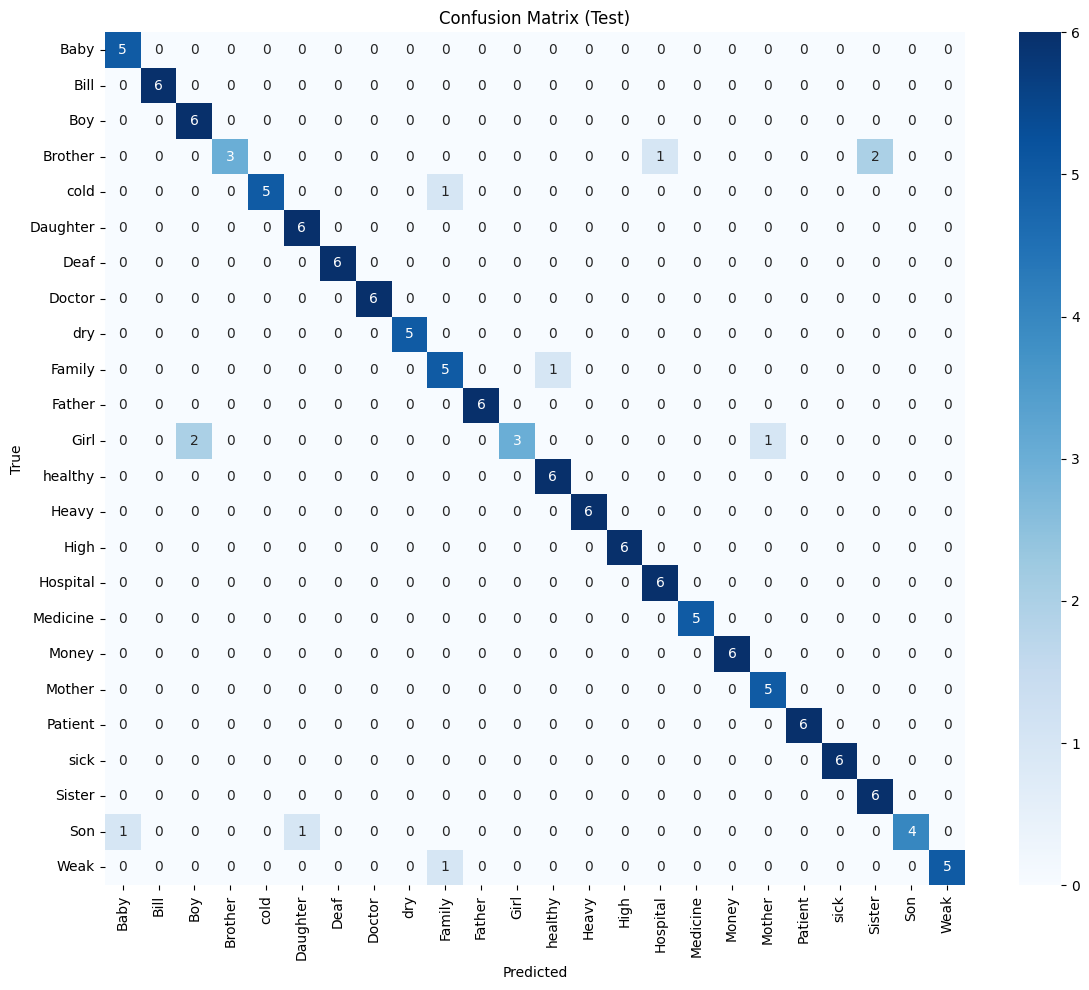

NameError: name 'translate_video' is not defined

In [ ]:
# Bi-LSTM + Attention model training
# Train -Validation-Test Bi-LSTM sign-word recogniser     (80 : 10 : 10 split)
#  • early-stop ONLY after val-acc ≥ target_acc (default 90 %)
#  • checkpoints include the class list
#  • final test confusion-matrix with seaborn
# ============================================================

import os, random, math, time, cv2, json, matplotlib.pyplot as plt
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import mediapipe as mp, seaborn as sns

# ------------- reproducibility & device ----------------------
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED);  np.random.seed(SEED);  random.seed(SEED)
print("Device:", DEVICE)

# ------------- 1. key-point extractor ------------------------
mp_holistic = mp.solutions.holistic
def extract_all_keypoints(res):
    if res.pose_landmarks:
        p = np.array([[l.x,l.y,l.z,l.visibility] for l in res.pose_landmarks.landmark])
        LS,RS = p[11,:2], p[12,:2]
        ctr, scl = (LS+RS)/2, np.linalg.norm(LS-RS) or 1.0
        pose = np.hstack([(p[:,:2]-ctr)/scl, p[:,2:]])
    else: pose = np.zeros((33,4)); ctr=np.array([.5,.5]); scl=1.0
    if res.face_landmarks:
        f = np.array([[l.x,l.y,l.z] for l in res.face_landmarks.landmark])
        face = np.hstack([(f[:,:2]-ctr)/scl, f[:,2:]])
    else: face = np.zeros((468,3))
    def _hand(lms): w=lms[0,:2]; return np.hstack([(lms[:,:2]-w)/scl, lms[:,2:]])
    lh = _hand(np.array([[l.x,l.y,l.z] for l in res.left_hand_landmarks.landmark])) if res.left_hand_landmarks else np.zeros((21,3))
    rh = _hand(np.array([[l.x,l.y,l.z] for l in res.right_hand_landmarks.landmark])) if res.right_hand_landmarks else np.zeros((21,3))
    return np.concatenate([pose.flatten(),face.flatten(),lh.flatten(),rh.flatten()]).astype(np.float32)

# ------------- 2. dataset ------------------------------------
class KeypointSequenceDataset(Dataset):
    def __init__(self, root, classes, seq_len=60, augment=True, noise_std=0.01):
        self.samples, self.labels = [], []
        self.augment, self.noise_std = augment, noise_std
        for lbl, cls in enumerate(classes):
            cdir = os.path.join(root, cls)
            for vid in os.listdir(cdir):
                vdir = os.path.join(cdir, vid)
                frames = sorted([f for f in os.listdir(vdir) if f.endswith('.npy')],
                                key=lambda x:int(x.split('_')[1].split('.')[0]))
                if len(frames)!=seq_len: continue
                self.samples.append(np.stack([np.load(os.path.join(vdir,f)) for f in frames]).astype(np.float32))
                self.labels .append(lbl)
        self.samples, self.labels = np.asarray(self.samples), np.asarray(self.labels)
    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        x = self.samples[i].copy()
        if self.augment: x += np.random.normal(0,self.noise_std,x.shape).astype(np.float32)
        return torch.from_numpy(x), torch.tensor(self.labels[i])

# ------------- 3. light Bi-LSTM ------------------------------
class SignRecognizer(nn.Module):
    def __init__(self,in_dim,n_cls,hidden=128,drop=0.4):
        super().__init__()
        self.lstm = nn.LSTM(in_dim,hidden,1,batch_first=True,bidirectional=True)
        self.attn = nn.Linear(hidden*2,1)
        self.norm = nn.LayerNorm(hidden*2)
        self.head = nn.Sequential(nn.Linear(hidden*2,hidden), nn.ReLU(),
                                  nn.Dropout(drop), nn.Linear(hidden,n_cls))
    def forward(self,x):
        h,_ = self.lstm(x)
        α = torch.softmax(self.attn(h).squeeze(-1),1)
        ctx = (h*α.unsqueeze(-1)).sum(1)
        return self.head(self.norm(ctx))

# ------------- 4. data splits ---------------------------------
def three_way_split(ds, test_ratio=0.2, val_ratio=0.1):
    sss = StratifiedShuffleSplit(n_splits=1,test_size=test_ratio,random_state=SEED)
    train_idx, test_idx = next(sss.split(np.zeros(len(ds)), ds.labels))
    sss2 = StratifiedShuffleSplit(n_splits=1,test_size=val_ratio/(1-test_ratio),random_state=SEED)
    sub_y = ds.labels[train_idx]
    tr_sub, val_sub = next(sss2.split(np.zeros(len(train_idx)), sub_y))
    return Subset(ds,train_idx[tr_sub]), Subset(ds,train_idx[val_sub]), Subset(ds,test_idx)

# ------------- 5. trainer -------------------------------------
def train_model(root, classes, seq_len=60, batch=32, lr=3e-4, epochs=6000,
                target_acc=90.0, early_patience=1000, min_delta=1e-4):

    full = KeypointSequenceDataset(root, classes, seq_len, augment=True)
    tr_ds, val_ds, te_ds = three_way_split(full,0.2,0.1)
    tr_dl = DataLoader(tr_ds, batch, shuffle=True,  drop_last=True)
    val_dl= DataLoader(val_ds, batch, shuffle=False)
    te_dl = DataLoader(te_ds, batch, shuffle=False)

    model = SignRecognizer(full.samples.shape[2], len(classes)).to(DEVICE)
    opt   = optim.AdamW(model.parameters(), lr=lr, weight_decay=2e-4)

    warm=8
    sched = optim.lr_scheduler.LambdaLR(
        opt, lambda e:(e+1)/warm if e<warm else 0.5*(1+math.cos(math.pi*(e-warm)/max(1,epochs-warm)))
    )
    crit = nn.CrossEntropyLoss(); best_loss=float('inf'); bad=0

    for ep in range(1, epochs+1):
        if ep==epochs//2: tr_ds.dataset.augment=False

        # ----- training -----
        model.train(); tl=tc=0
        for X,y in tr_dl:
            X,y = X.to(DEVICE), y.to(DEVICE); opt.zero_grad()
            out = model(X); loss = crit(out,y); loss.backward(); opt.step()
            tl += loss.item(); tc += (out.argmax(1)==y).sum().item()
        ta = 100*tc/len(tr_ds)

        # ----- validation -----
        model.eval(); vl=vc=0
        with torch.no_grad():
            for X,y in val_dl:
                out = model(X.to(DEVICE)); vl += crit(out,y.to(DEVICE)).item()
                vc += (out.argmax(1).cpu()==y).sum().item()
        va = 100*vc/len(val_ds)
        sched.step()
        print(f"Ep{ep:03d} | tr {ta:5.1f}% | val {va:5.1f}% | v-loss {vl/len(val_dl):.4f}")

        # save best by val-loss
        if vl < best_loss - min_delta:
            best_loss, bad = vl, 0
            torch.save({"state_dict":model.state_dict(),"classes":classes}, "sign_recognizer_best.pth")
        else:
            bad += 1

        # ---- early-stop criteria ----
        if va >= target_acc:
            print(f"🎉 reached {target_acc:.0f}% val-accuracy — stopping"); break
        if bad >= early_patience:
            print("⏹️  no val-loss improvement for", early_patience, "epochs"); break

    # ---------- reload best ----------
    ckpt = torch.load("sign_recognizer_best.pth", map_location=DEVICE)
    model.load_state_dict(ckpt["state_dict"]); model.eval()

    # ---------- final TEST set ----------
    all_p, all_t = [], []
    with torch.no_grad():
        for X,y in te_dl:
            p = model(X.to(DEVICE)).argmax(1).cpu().numpy()
            all_p.extend(p); all_t.extend(y.numpy())
    cm = confusion_matrix(all_t, all_p)
    acc = 100 * (np.array(all_p)==np.array(all_t)).mean()
    print(f"\nTEST accuracy: {acc:.2f}%")
    print(classification_report(all_t, all_p, target_names=classes, digits=3))

    # ---------- confusion-matrix plot ----------
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Test)")
    plt.tight_layout(); plt.show()

    return model

# ------------- 6. translation helpers (unchanged) -------------
# (use your existing segment_video, pad_or_trim, translate_video)

# ------------- 7. run -----------------------------------------
if __name__ == "__main__":
    root_dir       = "./extracted_keypoints"
    continuous_vid = "./videos/SickSourikSampleVideo - Trim2.mp4"
    classes = [
    "Baby",
    "Bill",
    "Boy",
    "Brother",
    "cold",
    "Daughter",
    "Deaf",
    "Doctor",
    "dry",
    "Family",
    "Father",
    "Girl",
    "healthy",
    "Heavy",
    "High",
    "Hospital",
    "Medicine",
    "Money",
    "Mother",
    "Patient",
    "sick",
    "Sister",
    "Son",
    "Weak"
]


    if not os.path.isfile("sign_recognizer_best.pth"):
        model = train_model(root_dir, classes, target_acc=95.0)
    else:
        ckpt  = torch.load("sign_recognizer_best.pth", map_location=DEVICE)
        model = SignRecognizer(1662, len(ckpt["classes"])).to(DEVICE)
        model.load_state_dict(ckpt["state_dict"]); model.eval()

    # optional live translation demo
    print("Translation:",
          " ".join(translate_video(continuous_vid, model, classes)))


In [ ]:
#  Isolated model inference on single video data 
# ---------------------------------------------------------------
#  • loads the class list directly from sign_recognizer_best.pth
#  • uses the light SignRecognizer (1-layer Bi-LSTM, 128 hidden)
#  • **NO centring / scaling** in extract_all_keypoints(): the raw
#    x-,y-,z-coordinates & visibility values are flattened exactly
#    the same way they were saved during dataset preparation
#  • uniformly samples / pads exactly 60 frames
#  • prints top-1 label + the full soft-max table
# ---------------------------------------------------------------

import os, cv2, numpy as np, torch, torch.nn as nn, mediapipe as mp

# ---------- paths ------------------------------------------------
WEIGHTS_PATH = "sign_recognizer_best.pth"        # checkpoint from training
TEST_VIDEO   = "./videos/sick2test.mp4"             # ← video to classify
SEQ_LEN      = 60
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- helper: pick / pad exactly N frames ------------------
def sample_n(frames, n=60):
    if not frames:
        raise RuntimeError("No frames read from video!")
    idx = np.linspace(0, len(frames) - 1, n).round().astype(int)
    return [frames[i] for i in idx]              # repeats last frame if needed

# ---------- key-point extraction  (RAW values, no normalisation) -
mp_holistic = mp.solutions.holistic
def extract_all_keypoints(res):
    # Pose: 33 × [x,y,z,vis]
    pose = np.array([[l.x, l.y, l.z, l.visibility]
                     for l in res.pose_landmarks.landmark]).flatten() \
           if res.pose_landmarks else np.zeros(33 * 4)

    # Face: 468 × [x,y,z]
    face = np.array([[l.x, l.y, l.z]
                     for l in res.face_landmarks.landmark]).flatten() \
           if res.face_landmarks else np.zeros(468 * 3)

    # Left hand: 21 × [x,y,z]
    lh = np.array([[l.x, l.y, l.z]
                   for l in res.left_hand_landmarks.landmark]).flatten() \
         if res.left_hand_landmarks else np.zeros(21 * 3)

    # Right hand: 21 × [x,y,z]
    rh = np.array([[l.x, l.y, l.z]
                   for l in res.right_hand_landmarks.landmark]).flatten() \
         if res.right_hand_landmarks else np.zeros(21 * 3)

    return np.concatenate([pose, face, lh, rh]).astype(np.float32)   # (1662,)

# ---------- model identical to training -------------------------
class SignRecognizer(nn.Module):
    def __init__(self, in_dim=1662, n_cls=10, hidden=128, drop=0.4):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hidden, 1, batch_first=True,
                            bidirectional=True)
        self.attn = nn.Linear(hidden * 2, 1)
        self.norm = nn.LayerNorm(hidden * 2)
        self.head = nn.Sequential(
            nn.Linear(hidden * 2, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, n_cls)
        )

    def forward(self, x):                       # x: (B, T, 1662)
        h, _ = self.lstm(x)                     # (B, T, 2H)
        α = torch.softmax(self.attn(h).squeeze(-1), 1)   # (B, T)
        ctx = (h * α.unsqueeze(-1)).sum(1)      # (B, 2H)
        return self.head(self.norm(ctx))        # (B, n_cls)

# ---------- load checkpoint & classes ---------------------------
ckpt    = torch.load(WEIGHTS_PATH, map_location=DEVICE)
classes = ckpt["classes"]                       # exact order from training
model   = SignRecognizer(1662, len(classes)).to(DEVICE)
model.load_state_dict(ckpt["state_dict"]); model.eval()
print(f"✓ model loaded — {len(classes)} classes")

# ---------- run inference --------------------------------------
def predict(video_path):
    # 1) read & sample frames -----------------------------------
    cap, frames = cv2.VideoCapture(video_path), []
    while True:
        ok, f = cap.read()
        if not ok:
            break
        frames.append(f)
    cap.release()
    frames = sample_n(frames, SEQ_LEN)

    # 2) extract key-points for every sampled frame -------------
    kps = []
    with mp_holistic.Holistic(min_detection_confidence=0.5,
                              min_tracking_confidence=0.5) as holo:
        for frm in frames:
            img = cv2.cvtColor(frm, cv2.COLOR_BGR2RGB)
            res = holo.process(img)
            kps.append(extract_all_keypoints(res))

    seq = torch.from_numpy(np.stack(kps)).unsqueeze(0).to(DEVICE)   # (1,60,1662)

    # 3) forward -------------------------------------------------
    with torch.no_grad():
        probs = torch.softmax(model(seq), 1)[0].cpu().numpy()

    best = int(probs.argmax())
    return classes[best], probs

# ---------- execute --------------------------------------------
pred, prob_vec = predict(TEST_VIDEO)
print(f"\nPredicted class : {pred}\n")
print("Probabilities:")
for c, p in zip(classes, prob_vec):
    print(f"  {c:<12s}: {p:.4f}")


✓ model loaded — 24 classes


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar


Predicted class : sick

Probabilities:
  Baby        : 0.0201
  Bill        : 0.0000
  Boy         : 0.0000
  Brother     : 0.0000
  cold        : 0.0000
  Daughter    : 0.3254
  Deaf        : 0.0000
  Doctor      : 0.0000
  dry         : 0.0000
  Family      : 0.0000
  Father      : 0.0001
  Girl        : 0.0000
  healthy     : 0.0000
  Heavy       : 0.0000
  High        : 0.0000
  Hospital    : 0.0000
  Medicine    : 0.0000
  Money       : 0.0000
  Mother      : 0.0002
  Patient     : 0.0000
  sick        : 0.3470
  Sister      : 0.0000
  Son         : 0.3070
  Weak        : 0.0000


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

✓ Model loaded — 24 classes

Processing video: ./videos/doctor_multiple_riddhi.mp4
Extracting keypoints from all frames...
Total frames: 257
Calculating motion profile...
Finding gesture boundaries...
Found 1 potential gestures

Segment 1: frames 8-257 (249 frames)
  → Low confidence (0.261), skipping


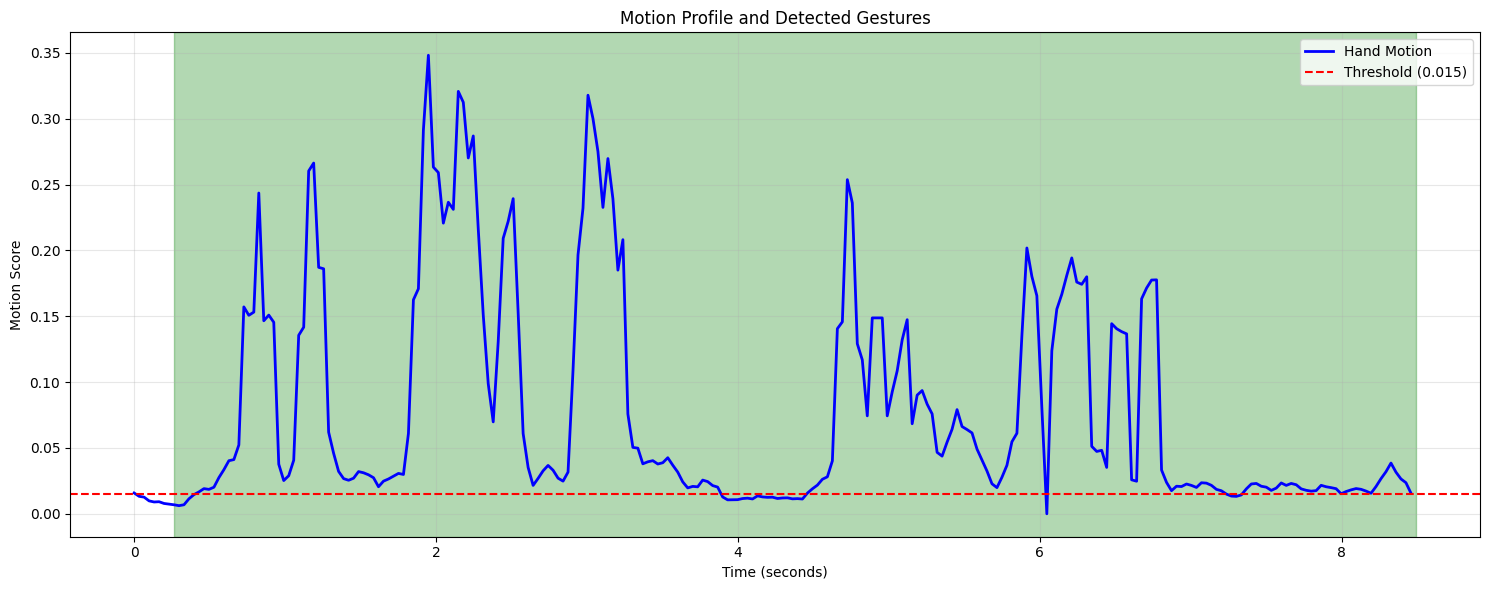


FINAL RESULTS:
Total gestures detected: 0

Recognized sequence:


In [32]:
# Motion-Based Segmentation
# ============================================================================
# This system automatically segments continuous video into gesture clips based on
# hand motion/velocity and classifies each segment using your trained model

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import mediapipe as mp
from collections import deque
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# ---------- Configuration ------------------------------------------------
WEIGHTS_PATH = "sign_recognizer_best.pth"      # Your trained model
SEQ_LEN = 60                                   # Frames per gesture
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Motion detection parameters
MOTION_WINDOW = 5          # Frames to calculate motion over
MIN_GESTURE_FRAMES = 60    # Minimum frames for a valid gesture
MAX_GESTURE_FRAMES = 120   # Maximum frames for a gesture
MOTION_THRESHOLD = 0.015   # Motion threshold for segmentation
CONFIDENCE_THRESHOLD = 0.5 # Minimum confidence for valid prediction

# ---------- MediaPipe setup ----------------------------------------------
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# ---------- Keypoint extraction with normalization -----------------------
def extract_all_keypoints(res):
    """Extract and normalize keypoints exactly as in training"""
    if res.pose_landmarks:
        p = np.array([[l.x,l.y,l.z,l.visibility] for l in res.pose_landmarks.landmark])
        LS, RS = p[11,:2], p[12,:2]
        ctr, scl = (LS+RS)/2, np.linalg.norm(LS-RS) or 1.0
        pose = np.hstack([(p[:,:2]-ctr)/scl, p[:,2:]])
    else:
        pose = np.zeros((33,4))
        ctr = np.array([.5,.5])
        scl = 1.0

    if res.face_landmarks:
        f = np.array([[l.x,l.y,l.z] for l in res.face_landmarks.landmark])
        face = np.hstack([(f[:,:2]-ctr)/scl, f[:,2:]])
    else:
        face = np.zeros((468,3))

    def _hand(lms):
        w = lms[0,:2]
        return np.hstack([(lms[:,:2]-w)/scl, lms[:,2:]])

    lh = _hand(np.array([[l.x,l.y,l.z] for l in res.left_hand_landmarks.landmark])) if res.left_hand_landmarks else np.zeros((21,3))
    rh = _hand(np.array([[l.x,l.y,l.z] for l in res.right_hand_landmarks.landmark])) if res.right_hand_landmarks else np.zeros((21,3))

    return np.concatenate([pose.flatten(),face.flatten(),lh.flatten(),rh.flatten()]).astype(np.float32)

# ---------- Model definition ---------------------------------------------
class SignRecognizer(nn.Module):
    def __init__(self, in_dim=1662, n_cls=10, hidden=128, drop=0.4):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hidden, 1, batch_first=True, bidirectional=True)
        self.attn = nn.Linear(hidden * 2, 1)
        self.norm = nn.LayerNorm(hidden * 2)
        self.head = nn.Sequential(
            nn.Linear(hidden * 2, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, n_cls)
        )

    def forward(self, x):
        h, _ = self.lstm(x)
        α = torch.softmax(self.attn(h).squeeze(-1), 1)
        ctx = (h * α.unsqueeze(-1)).sum(1)
        return self.head(self.norm(ctx))

# ---------- Motion calculation functions ---------------------------------
def calculate_hand_motion(keypoints_sequence):
    """Calculate motion score based on hand keypoint velocities"""
    if len(keypoints_sequence) < 2:
        return 0.0
    
    # Extract hand keypoints (last 126 values: 21*3 for each hand)
    lh_start = 1662 - 126  # Left hand starts here
    rh_start = 1662 - 63   # Right hand starts here
    
    motion_scores = []
    for i in range(1, len(keypoints_sequence)):
        # Get hand keypoints for current and previous frame
        lh_curr = keypoints_sequence[i][lh_start:rh_start].reshape(21, 3)[:, :2]  # x,y only
        lh_prev = keypoints_sequence[i-1][lh_start:rh_start].reshape(21, 3)[:, :2]
        rh_curr = keypoints_sequence[i][rh_start:].reshape(21, 3)[:, :2]
        rh_prev = keypoints_sequence[i-1][rh_start:].reshape(21, 3)[:, :2]
        
        # Calculate motion as L2 distance
        lh_motion = np.mean(np.linalg.norm(lh_curr - lh_prev, axis=1))
        rh_motion = np.mean(np.linalg.norm(rh_curr - rh_prev, axis=1))
        
        # Combined motion score
        motion_scores.append(max(lh_motion, rh_motion))
    
    return np.mean(motion_scores) if motion_scores else 0.0

def find_gesture_boundaries(motion_profile, threshold=0.015):
    """Find gesture start/end points based on motion profile"""
    boundaries = []
    in_gesture = False
    start_idx = 0
    
    # Smooth motion profile
    from scipy.ndimage import gaussian_filter1d
    smoothed = gaussian_filter1d(motion_profile, sigma=2)
    
    for i in range(len(smoothed)):
        if not in_gesture and smoothed[i] > threshold:
            # Gesture starts
            in_gesture = True
            start_idx = max(0, i - 5)  # Include a few frames before motion
        elif in_gesture and smoothed[i] < threshold * 0.5:  # Lower threshold for end
            # Gesture ends
            end_idx = min(len(motion_profile), i + 5)  # Include a few frames after
            if end_idx - start_idx >= MIN_GESTURE_FRAMES:
                boundaries.append((start_idx, end_idx))
            in_gesture = False
    
    # Handle case where gesture extends to end of video
    if in_gesture and len(motion_profile) - start_idx >= MIN_GESTURE_FRAMES:
        boundaries.append((start_idx, len(motion_profile)))
    
    return boundaries

# ---------- Frame sampling function --------------------------------------
def sample_n_frames(frames, n=60):
    """Sample exactly n frames uniformly from the input frames"""
    if not frames:
        raise RuntimeError("No frames provided!")
    idx = np.linspace(0, len(frames) - 1, n).round().astype(int)
    return [frames[i] for i in idx]

# ---------- Main continuous recognition class ----------------------------
class ContinuousSignRecognizer:
    def __init__(self, model_path, motion_threshold=0.015, confidence_threshold=0.5):
        # Load model and classes
        self.ckpt = torch.load(model_path, map_location=DEVICE)
        self.classes = self.ckpt["classes"]
        self.model = SignRecognizer(1662, len(self.classes)).to(DEVICE)
        self.model.load_state_dict(self.ckpt["state_dict"])
        self.model.eval()
        
        # Parameters
        self.motion_threshold = motion_threshold
        self.confidence_threshold = confidence_threshold
        self.holistic = mp_holistic.Holistic(
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
        
        print(f"✓ Model loaded — {len(self.classes)} classes")
    
    def process_video(self, video_path, visualize=True):
        """Process continuous video and return segmented predictions"""
        print(f"\nProcessing video: {video_path}")
        
        # 1. Read all frames and extract keypoints
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        frames = []
        keypoints_list = []
        
        print("Extracting keypoints from all frames...")
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            frames.append(frame)
            # Extract keypoints
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = self.holistic.process(image)
            kps = extract_all_keypoints(results)
            keypoints_list.append(kps)
        
        cap.release()
        print(f"Total frames: {len(frames)}")
        
        # 2. Calculate motion profile
        print("Calculating motion profile...")
        motion_profile = []
        window_size = MOTION_WINDOW
        
        for i in range(len(keypoints_list)):
            start = max(0, i - window_size // 2)
            end = min(len(keypoints_list), i + window_size // 2 + 1)
            window_kps = keypoints_list[start:end]
            motion = calculate_hand_motion(window_kps)
            motion_profile.append(motion)
        
        # 3. Find gesture boundaries
        print("Finding gesture boundaries...")
        boundaries = find_gesture_boundaries(motion_profile, self.motion_threshold)
        print(f"Found {len(boundaries)} potential gestures")
        
        # 4. Classify each segment
        predictions = []
        for idx, (start, end) in enumerate(boundaries):
            print(f"\nSegment {idx+1}: frames {start}-{end} ({end-start} frames)")
            
            # Extract segment frames and keypoints
            segment_frames = frames[start:end]
            segment_kps = keypoints_list[start:end]
            
            # Sample to exactly 60 frames
            if len(segment_frames) >= MIN_GESTURE_FRAMES:
                sampled_indices = np.linspace(0, len(segment_frames)-1, SEQ_LEN).round().astype(int)
                sampled_kps = [segment_kps[i] for i in sampled_indices]
                
                # Prepare input tensor
                seq_tensor = torch.from_numpy(np.stack(sampled_kps)).unsqueeze(0).to(DEVICE)
                
                # Predict
                with torch.no_grad():
                    probs = torch.softmax(self.model(seq_tensor), 1)[0].cpu().numpy()
                
                best_idx = int(probs.argmax())
                confidence = probs[best_idx]
                
                if confidence >= self.confidence_threshold:
                    pred_class = self.classes[best_idx]
                    predictions.append({
                        'start_frame': start,
                        'end_frame': end,
                        'start_time': start / fps,
                        'end_time': end / fps,
                        'prediction': pred_class,
                        'confidence': confidence,
                        'all_probs': probs
                    })
                    print(f"  → Predicted: {pred_class} (confidence: {confidence:.3f})")
                else:
                    print(f"  → Low confidence ({confidence:.3f}), skipping")
        
        # 5. Visualize if requested
        if visualize:
            self._visualize_results(motion_profile, boundaries, predictions, fps)
        
        return predictions, motion_profile, boundaries
    
    def _visualize_results(self, motion_profile, boundaries, predictions, fps):
        """Visualize motion profile and detected boundaries"""
        plt.figure(figsize=(15, 6))
        
        # Create time axis
        time_axis = np.arange(len(motion_profile)) / fps
        
        # Plot motion profile
        plt.plot(time_axis, motion_profile, 'b-', linewidth=2, label='Hand Motion')
        plt.axhline(y=self.motion_threshold, color='r', linestyle='--', 
                   label=f'Threshold ({self.motion_threshold})')
        
        # Plot boundaries
        for start, end in boundaries:
            plt.axvspan(start/fps, end/fps, alpha=0.3, color='green')
        
        # Add predictions as text
        for pred in predictions:
            mid_time = (pred['start_time'] + pred['end_time']) / 2
            plt.text(mid_time, max(motion_profile) * 0.9, 
                    f"{pred['prediction']}\n({pred['confidence']:.2f})",
                    ha='center', va='center', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
        
        plt.xlabel('Time (seconds)')
        plt.ylabel('Motion Score')
        plt.title('Motion Profile and Detected Gestures')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def process_webcam_stream(self):
        """Process live webcam stream (real-time segmentation)"""
        print("\nStarting webcam stream...")
        print("Press 'q' to quit")
        
        cap = cv2.VideoCapture(0)
        buffer_frames = []
        buffer_keypoints = []
        predictions_history = []
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Extract keypoints
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = self.holistic.process(image)
            kps = extract_all_keypoints(results)
            
            # Add to buffer
            buffer_frames.append(frame)
            buffer_keypoints.append(kps)
            
            # Keep buffer size manageable
            if len(buffer_frames) > MAX_GESTURE_FRAMES * 2:
                buffer_frames.pop(0)
                buffer_keypoints.pop(0)
            
            # Check for gesture completion every 10 frames
            if len(buffer_frames) > MIN_GESTURE_FRAMES and len(buffer_frames) % 10 == 0:
                # Calculate recent motion
                recent_motion = calculate_hand_motion(buffer_keypoints[-MOTION_WINDOW:])
                
                # If motion is low, check if we captured a gesture
                if recent_motion < self.motion_threshold * 0.5 and len(buffer_frames) > 30:
                    # Find the gesture in the buffer
                    motion_profile = []
                    for i in range(len(buffer_keypoints)):
                        start = max(0, i - MOTION_WINDOW // 2)
                        end = min(len(buffer_keypoints), i + MOTION_WINDOW // 2 + 1)
                        window_kps = buffer_keypoints[start:end]
                        motion = calculate_hand_motion(window_kps)
                        motion_profile.append(motion)
                    
                    boundaries = find_gesture_boundaries(motion_profile, self.motion_threshold)
                    
                    if boundaries:
                        # Process the most recent boundary
                        start, end = boundaries[-1]
                        if end - start >= MIN_GESTURE_FRAMES:
                            # Extract and classify
                            segment_kps = buffer_keypoints[start:end]
                            sampled_indices = np.linspace(0, len(segment_kps)-1, SEQ_LEN).round().astype(int)
                            sampled_kps = [segment_kps[i] for i in sampled_indices]
                            
                            seq_tensor = torch.from_numpy(np.stack(sampled_kps)).unsqueeze(0).to(DEVICE)
                            
                            with torch.no_grad():
                                probs = torch.softmax(self.model(seq_tensor), 1)[0].cpu().numpy()
                            
                            best_idx = int(probs.argmax())
                            confidence = probs[best_idx]
                            
                            if confidence >= self.confidence_threshold:
                                pred_class = self.classes[best_idx]
                                predictions_history.append(pred_class)
                                print(f"\n>>> Detected: {pred_class} (confidence: {confidence:.3f})")
                            
                            # Clear processed portion of buffer
                            buffer_frames = buffer_frames[end-10:]
                            buffer_keypoints = buffer_keypoints[end-10:]
            
            # Display
            display_frame = frame.copy()
            
            # Draw landmarks
            if results.pose_landmarks:
                mp_drawing.draw_landmarks(display_frame, results.pose_landmarks, 
                                        mp_holistic.POSE_CONNECTIONS)
            if results.left_hand_landmarks:
                mp_drawing.draw_landmarks(display_frame, results.left_hand_landmarks, 
                                        mp_holistic.HAND_CONNECTIONS)
            if results.right_hand_landmarks:
                mp_drawing.draw_landmarks(display_frame, results.right_hand_landmarks, 
                                        mp_holistic.HAND_CONNECTIONS)
            
            # Show recent predictions
            y_offset = 30
            for i, pred in enumerate(predictions_history[-5:]):
                cv2.putText(display_frame, f"{i+1}. {pred}", (10, y_offset + i*25),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            
            cv2.imshow('Continuous Sign Language Recognition', display_frame)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        
        cap.release()
        cv2.destroyAllWindows()
        
        print("\n\nRecognized sequence:", " → ".join(predictions_history))

# ---------- Example usage ------------------------------------------------
if __name__ == "__main__":
    # Initialize the continuous recognizer
    recognizer = ContinuousSignRecognizer(
        model_path=WEIGHTS_PATH,
        motion_threshold=MOTION_THRESHOLD,
        confidence_threshold=CONFIDENCE_THRESHOLD
    )
    
    # Example 1: Process a pre-recorded continuous video
    continuous_video = "./videos/doctor_multiple_riddhi.mp4"  # Change to your video path
    
    if os.path.exists(continuous_video):
        predictions, motion, boundaries = recognizer.process_video(
            continuous_video, 
            visualize=True
        )
        
        print("\n" + "="*50)
        print("FINAL RESULTS:")
        print("="*50)
        print(f"Total gestures detected: {len(predictions)}")
        print("\nRecognized sequence:")
        for i, pred in enumerate(predictions):
            print(f"{i+1}. {pred['prediction']} "
                  f"(time: {pred['start_time']:.1f}s - {pred['end_time']:.1f}s, "
                  f"confidence: {pred['confidence']:.3f})")
    
    # Example 2: Process live webcam stream (uncomment to use)
    # recognizer.process_webcam_stream()
    
    # Example 3: Process multiple videos
    # video_folder = "./continuous_videos"
    # for video_file in os.listdir(video_folder):
    #     if video_file.endswith(('.mp4', '.avi', '.mov')):
    #         video_path = os.path.join(video_folder, video_file)
    #         predictions, _, _ = recognizer.process_video(video_path, visualize=False)
    #         print(f"\n{video_file}: {' → '.join([p['prediction'] for p in predictions])}")


METHOD 1: REST POSITION BASED SEGMENTATION
Processing: ./videos/sick_multiple_riddhi.mp4
Step 1: Analyzing hand positions and extracting keypoints...


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

  Total frames: 206
Step 2: Finding rest position boundaries...
  Found 3 rest periods
Step 3: Extracting gesture segments...
  Found 2 gesture segments
Step 4: Classifying gesture segments...
  ? Segment 1: Patient (conf: 0.29)
  ? Segment 2: Patient (conf: 0.29)


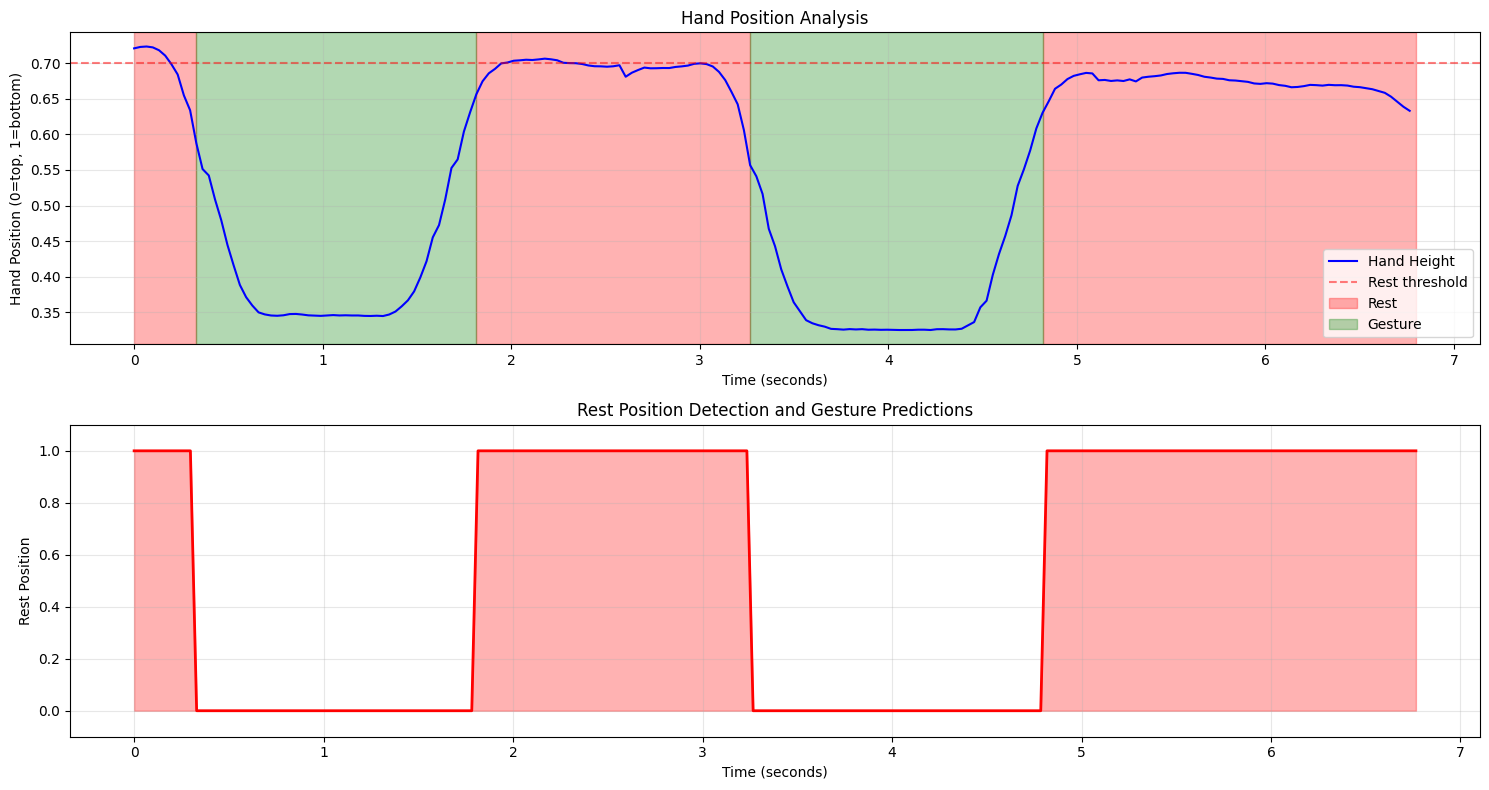


FINAL RESULTS:
? 1. Patient (0.3s-1.8s, confidence: 0.29, duration: 1.5s)
     Top 3: [('Patient', 0.29273176), ('Hospital', 0.23660034), ('Boy', 0.12250516)]
? 2. Patient (3.3s-4.8s, confidence: 0.29, duration: 1.6s)
     Top 3: [('Patient', 0.2904897), ('Hospital', 0.23615229), ('Boy', 0.11891863)]

Recognized sentence: 

METHOD 2: HYBRID APPROACH (REST + MOTION)
Processing with hybrid approach: ./videos/sick_multiple_riddhi.mp4
Step 1: Analyzing video...


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Step 2: Finding stable rest positions...
  Found 2 gesture segments
1. Patient (0.1s-1.9s, confidence: 0.28)
2. Patient (3.1s-5.0s, confidence: 0.29)


In [30]:
# Rest Position-Based Continuous Sign Language Recognition
# =========================================================
# Segments video based on hands returning to rest position (at sides/thighs)

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import mediapipe as mp
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ---------- Configuration ------------------------------------------------
WEIGHTS_PATH = "sign_recognizer_best.pth"
TEST_VIDEO = "./videos/sick_multiple_riddhi.mp4"
SEQ_LEN = 60
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Rest position detection parameters
REST_POSITION_THRESHOLD = 0.15  # Distance threshold for hands near hips
MIN_REST_DURATION = 10          # Minimum frames in rest position
MIN_GESTURE_FRAMES = 20         # Minimum frames for valid gesture
MAX_GESTURE_FRAMES = 150        # Maximum frames for a gesture
CONFIDENCE_THRESHOLD = 0.5      # Minimum confidence for prediction

# ---------- MediaPipe setup ----------------------------------------------
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# ---------- Keypoint extraction (same as before) ------------------------
def extract_all_keypoints(res):
    """Your existing keypoint extraction with normalization"""
    if res.pose_landmarks:
        p = np.array([[l.x,l.y,l.z,l.visibility] for l in res.pose_landmarks.landmark])
        LS,RS = p[11,:2], p[12,:2]
        ctr, scl = (LS+RS)/2, np.linalg.norm(LS-RS) or 1.0
        pose = np.hstack([(p[:,:2]-ctr)/scl, p[:,2:]])
    else: 
        pose = np.zeros((33,4))
        ctr=np.array([.5,.5])
        scl=1.0
    
    if res.face_landmarks:
        f = np.array([[l.x,l.y,l.z] for l in res.face_landmarks.landmark])
        face = np.hstack([(f[:,:2]-ctr)/scl, f[:,2:]])
    else: 
        face = np.zeros((468,3))
    
    def _hand(lms): 
        w=lms[0,:2]
        return np.hstack([(lms[:,:2]-w)/scl, lms[:,2:]])
    
    lh = _hand(np.array([[l.x,l.y,l.z] for l in res.left_hand_landmarks.landmark])) if res.left_hand_landmarks else np.zeros((21,3))
    rh = _hand(np.array([[l.x,l.y,l.z] for l in res.right_hand_landmarks.landmark])) if res.right_hand_landmarks else np.zeros((21,3))
    
    return np.concatenate([pose.flatten(),face.flatten(),lh.flatten(),rh.flatten()]).astype(np.float32)

class SignRecognizer(nn.Module):
    """Your existing model architecture"""
    def __init__(self, in_dim=1662, n_cls=10, hidden=128, drop=0.4):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hidden, 1, batch_first=True, bidirectional=True)
        self.attn = nn.Linear(hidden * 2, 1)
        self.norm = nn.LayerNorm(hidden * 2)
        self.head = nn.Sequential(
            nn.Linear(hidden * 2, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, n_cls)
        )
    
    def forward(self, x):
        h, _ = self.lstm(x)
        α = torch.softmax(self.attn(h).squeeze(-1), 1)
        ctx = (h * α.unsqueeze(-1)).sum(1)
        return self.head(self.norm(ctx))

# ---------- Rest position detection functions ----------------------------
def detect_rest_position(results):
    """
    Detect if hands are in rest position (at sides/thighs).
    Returns True if both hands are near hips/thighs or not detected.
    """
    if not results.pose_landmarks:
        return True  # If no pose detected, consider it rest
    
    pose = results.pose_landmarks.landmark
    
    # Get hip positions (landmarks 23, 24)
    left_hip = np.array([pose[23].x, pose[23].y])
    right_hip = np.array([pose[24].x, pose[24].y])
    
    # Get wrist positions (landmarks 15, 16 for pose, 0 for hands)
    left_wrist = np.array([pose[15].x, pose[15].y]) if pose[15].visibility > 0.5 else None
    right_wrist = np.array([pose[16].x, pose[16].y]) if pose[16].visibility > 0.5 else None
    
    # Alternative: use hand landmarks if available
    if results.left_hand_landmarks:
        left_wrist = np.array([results.left_hand_landmarks.landmark[0].x, 
                              results.left_hand_landmarks.landmark[0].y])
    if results.right_hand_landmarks:
        right_wrist = np.array([results.right_hand_landmarks.landmark[0].x, 
                               results.right_hand_landmarks.landmark[0].y])
    
    # Check if hands are near hips
    left_rest = True
    right_rest = True
    
    if left_wrist is not None:
        left_dist = np.linalg.norm(left_wrist - left_hip)
        left_rest = left_dist < REST_POSITION_THRESHOLD
    
    if right_wrist is not None:
        right_dist = np.linalg.norm(right_wrist - right_hip)
        right_rest = right_dist < REST_POSITION_THRESHOLD
    
    # Both hands should be at rest
    return left_rest and right_rest

def get_hand_positions(results):
    """Get normalized hand positions for visualization"""
    if not results.pose_landmarks:
        return None, None
    
    pose = results.pose_landmarks.landmark
    
    # Get wrist positions
    left_pos = None
    right_pos = None
    
    if results.left_hand_landmarks:
        left_pos = np.array([results.left_hand_landmarks.landmark[0].x, 
                            results.left_hand_landmarks.landmark[0].y])
    elif pose[15].visibility > 0.5:
        left_pos = np.array([pose[15].x, pose[15].y])
    
    if results.right_hand_landmarks:
        right_pos = np.array([results.right_hand_landmarks.landmark[0].x, 
                             results.right_hand_landmarks.landmark[0].y])
    elif pose[16].visibility > 0.5:
        right_pos = np.array([pose[16].x, pose[16].y])
    
    return left_pos, right_pos

def segment_by_rest_positions(video_path, model, classes):
    """Segment video based on rest positions"""
    print(f"Processing: {video_path}")
    
    # Load model
    ckpt = torch.load(WEIGHTS_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()
    
    # Read video
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    frames = []
    keypoints = []
    rest_positions = []
    hand_heights = []
    
    print("Step 1: Analyzing hand positions and extracting keypoints...")
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            frames.append(frame)
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = holistic.process(image)
            
            # Extract keypoints
            kps = extract_all_keypoints(results)
            keypoints.append(kps)
            
            # Check if in rest position
            is_rest = detect_rest_position(results)
            rest_positions.append(is_rest)
            
            # Store hand heights for visualization
            left_pos, right_pos = get_hand_positions(results)
            if left_pos is not None and right_pos is not None:
                avg_height = (left_pos[1] + right_pos[1]) / 2
                hand_heights.append(avg_height)
            else:
                hand_heights.append(0.5)  # Default middle position
    
    cap.release()
    print(f"  Total frames: {len(frames)}")
    
    # Find rest position segments
    print("Step 2: Finding rest position boundaries...")
    rest_segments = []
    in_rest = False
    rest_start = 0
    
    for i in range(len(rest_positions)):
        if not in_rest and rest_positions[i]:
            in_rest = True
            rest_start = i
        elif in_rest and not rest_positions[i]:
            # End of rest period
            if i - rest_start >= MIN_REST_DURATION:
                rest_segments.append((rest_start, i))
            in_rest = False
    
    # Add final rest segment if video ends in rest
    if in_rest and len(frames) - rest_start >= MIN_REST_DURATION:
        rest_segments.append((rest_start, len(frames)))
    
    print(f"  Found {len(rest_segments)} rest periods")
    
    # Extract gesture segments (between rest positions)
    print("Step 3: Extracting gesture segments...")
    gesture_segments = []
    
    for i in range(len(rest_segments) - 1):
        # Gesture is between end of one rest and start of next
        start = rest_segments[i][1]  # End of rest
        end = rest_segments[i + 1][0]  # Start of next rest
        
        if MIN_GESTURE_FRAMES <= (end - start) <= MAX_GESTURE_FRAMES:
            gesture_segments.append((start, end))
    
    # Check if video starts with a gesture
    if rest_segments and rest_segments[0][0] > MIN_GESTURE_FRAMES:
        gesture_segments.insert(0, (0, rest_segments[0][0]))
    
    # Check if video ends with a gesture
    if rest_segments and rest_segments[-1][1] < len(frames) - MIN_GESTURE_FRAMES:
        gesture_segments.append((rest_segments[-1][1], len(frames)))
    
    print(f"  Found {len(gesture_segments)} gesture segments")
    
    # Classify each gesture segment
    print("Step 4: Classifying gesture segments...")
    predictions = []
    
    for idx, (start, end) in enumerate(gesture_segments):
        # Sample frames uniformly
        seg_kps = keypoints[start:end]
        indices = np.linspace(0, len(seg_kps)-1, SEQ_LEN).round().astype(int)
        sampled = [seg_kps[i] for i in indices]
        
        # Prepare tensor
        seq = torch.from_numpy(np.stack(sampled)).unsqueeze(0).to(DEVICE)
        
        # Predict
        with torch.no_grad():
            probs = torch.softmax(model(seq), 1)[0].cpu().numpy()
        
        best_idx = probs.argmax()
        confidence = probs[best_idx]
        
        pred = {
            'segment': idx + 1,
            'frames': f"{start}-{end}",
            'duration': (end - start) / fps,
            'time': f"{start/fps:.1f}s-{end/fps:.1f}s",
            'prediction': classes[best_idx],
            'confidence': confidence,
            'top_3': [(classes[i], probs[i]) for i in np.argsort(probs)[-3:][::-1]]
        }
        predictions.append(pred)
        
        status = "✓" if confidence >= CONFIDENCE_THRESHOLD else "?"
        print(f"  {status} Segment {idx+1}: {classes[best_idx]} (conf: {confidence:.2f})")
    
    # Visualize results
    plt.figure(figsize=(15, 8))
    
    # Create time axis
    time_axis = np.arange(len(frames)) / fps
    
    # Plot 1: Hand height positions
    plt.subplot(2, 1, 1)
    plt.plot(time_axis, hand_heights, 'b-', linewidth=1.5, label='Hand Height')
    plt.axhline(y=0.7, color='r', linestyle='--', alpha=0.5, label='Rest threshold')
    
    # Highlight rest positions
    for start, end in rest_segments:
        plt.axvspan(start/fps, end/fps, alpha=0.3, color='red', label='Rest' if start == rest_segments[0][0] else '')
    
    # Highlight gesture segments
    for start, end in gesture_segments:
        plt.axvspan(start/fps, end/fps, alpha=0.3, color='green', label='Gesture' if start == gesture_segments[0][0] else '')
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Hand Position (0=top, 1=bottom)')
    plt.title('Hand Position Analysis')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Rest position indicator
    plt.subplot(2, 1, 2)
    rest_indicator = [1 if r else 0 for r in rest_positions]
    plt.plot(time_axis, rest_indicator, 'r-', linewidth=2)
    plt.fill_between(time_axis, 0, rest_indicator, alpha=0.3, color='red')
    
    # Add predictions
    for pred in predictions:
        if pred['confidence'] >= CONFIDENCE_THRESHOLD:
            start, end = map(int, pred['frames'].split('-'))
            mid = (start + end) / 2 / fps
            plt.text(mid, 0.5, pred['prediction'], 
                    ha='center', va='center', fontsize=10, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Rest Position')
    plt.title('Rest Position Detection and Gesture Predictions')
    plt.ylim(-0.1, 1.1)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return predictions, rest_segments, gesture_segments

# ---------- Alternative: Rest position with motion hybrid ----------------
def segment_with_hybrid_approach(video_path, model, classes):
    """
    Hybrid approach: Use rest positions as primary boundaries,
    but also consider motion within segments for refinement
    """
    print(f"Processing with hybrid approach: {video_path}")
    
    # Load model
    ckpt = torch.load(WEIGHTS_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()
    
    # Read video and process
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    frames = []
    keypoints = []
    rest_positions = []
    motions = []
    
    print("Step 1: Analyzing video...")
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        prev_kps = None
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            frames.append(frame)
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = holistic.process(image)
            
            # Extract keypoints
            kps = extract_all_keypoints(results)
            keypoints.append(kps)
            
            # Check rest position
            is_rest = detect_rest_position(results)
            rest_positions.append(is_rest)
            
            # Calculate motion
            if prev_kps is not None:
                # Focus on hand motion
                hand_kps_curr = kps[-126:]  # Last 126 values are hands
                hand_kps_prev = prev_kps[-126:]
                motion = np.mean(np.abs(hand_kps_curr - hand_kps_prev))
                motions.append(motion)
            else:
                motions.append(0)
            
            prev_kps = kps
    
    cap.release()
    
    # Find extended rest periods (hands down AND low motion)
    print("Step 2: Finding stable rest positions...")
    stable_rest = []
    for i in range(len(rest_positions)):
        is_stable_rest = rest_positions[i] and motions[i] < 0.01
        stable_rest.append(is_stable_rest)
    
    # Smooth to remove brief transitions
    from scipy.ndimage import binary_closing
    stable_rest = binary_closing(stable_rest, structure=np.ones(5))
    
    # Find gesture boundaries
    gesture_segments = []
    i = 0
    
    while i < len(stable_rest):
        # Find start of gesture (end of rest)
        while i < len(stable_rest) and stable_rest[i]:
            i += 1
        
        if i >= len(stable_rest):
            break
        
        start = i
        
        # Find end of gesture (start of next rest)
        while i < len(stable_rest) and not stable_rest[i]:
            i += 1
        
        end = i
        
        # Validate segment
        if MIN_GESTURE_FRAMES <= (end - start) <= MAX_GESTURE_FRAMES:
            gesture_segments.append((start, end))
    
    print(f"  Found {len(gesture_segments)} gesture segments")
    
    # Classify segments
    predictions = []
    for idx, (start, end) in enumerate(gesture_segments):
        seg_kps = keypoints[start:end]
        indices = np.linspace(0, len(seg_kps)-1, SEQ_LEN).round().astype(int)
        sampled = [seg_kps[i] for i in indices]
        
        seq = torch.from_numpy(np.stack(sampled)).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            probs = torch.softmax(model(seq), 1)[0].cpu().numpy()
        
        best_idx = probs.argmax()
        predictions.append({
            'segment': idx + 1,
            'time': f"{start/fps:.1f}s-{end/fps:.1f}s",
            'prediction': classes[best_idx],
            'confidence': probs[best_idx]
        })
    
    return predictions

# ---------- Main execution -----------------------------------------------
# Load model
ckpt = torch.load(WEIGHTS_PATH, map_location=DEVICE)
classes = ckpt["classes"]
model = SignRecognizer(1662, len(classes)).to(DEVICE)

# Method 1: Pure rest position based segmentation
print("\n" + "="*60)
print("METHOD 1: REST POSITION BASED SEGMENTATION")
print("="*60)
predictions, rest_segs, gesture_segs = segment_by_rest_positions(TEST_VIDEO, model, classes)

# Print results
print("\nFINAL RESULTS:")
for pred in predictions:
    conf_marker = "✓" if pred['confidence'] >= CONFIDENCE_THRESHOLD else "?"
    print(f"{conf_marker} {pred['segment']}. {pred['prediction']} ({pred['time']}, "
          f"confidence: {pred['confidence']:.2f}, duration: {pred['duration']:.1f}s)")
    print(f"     Top 3: {pred['top_3']}")

# Create sentence (only from high-confidence predictions)
high_conf_preds = [p for p in predictions if p['confidence'] >= CONFIDENCE_THRESHOLD]
sentence = " ".join([p['prediction'] for p in high_conf_preds])
print(f"\nRecognized sentence: {sentence}")

# Optional: Try hybrid approach
print("\n" + "="*60)
print("METHOD 2: HYBRID APPROACH (REST + MOTION)")
print("="*60)
hybrid_predictions = segment_with_hybrid_approach(TEST_VIDEO, model, classes)

for pred in hybrid_predictions:
    print(f"{pred['segment']}. {pred['prediction']} ({pred['time']}, "
          f"confidence: {pred['confidence']:.2f})")

In [20]:
# Segmentor hand raise movement detector
# ===============================================================
#  Flow + Pose Gate gesture detector  (FAST PREVIEW VERSION)
#  --------------------------------------------------------------
#  • Farnebäck optical flow  (lighter params)
#  • MediaPipe Pose called every POSE_IVL frames
#  • Frames down-scaled by `SCALE`  ⇒ big FPS boost
#  • Same segment-merge logic as before
# ===============================================================
import cv2, mediapipe as mp, numpy as np, math
from typing import List, Tuple

# -------------------- parameters to tune -----------------------
VIDEO      = "./videos/medicine_multiple_riddhi.mp4"   # 0 for webcam
SCALE      = 0.5     # resize factor  (0.5 ⇒ 50 % width/height ≈ 4× faster)
FLOW_TH    = 1.7     # optical-flow magnitude threshold
POSE_TH    = 0.18    # wrist ≥18 % torso-length above hip centre
POSE_IVL   = 2       # run pose every Nth frame   (≥1)
GAP_LEN    = 12      # merge runs split by ≤12 idle frames
MIN_LEN    = 60      # keep/fuse runs ≥60 frames (Bi-LSTM window)
# ---------------------------------------------------------------

LHIP, RHIP, LWRI, RWRI = 23, 24, 15, 16          # MediaPipe indices

# ---------- helpers ----------------------------------------------------
def flow_energy(prev_g, next_g) -> float:
    flow = cv2.calcOpticalFlowFarneback(
        prev_g, next_g, None, 0.5, 2, 15, 3, 5, 1.1, 0)  # levels=2, winsize=15
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    return float(np.mean(mag))

def wrist_raised(lm) -> bool:
    if lm[LHIP].visibility < .3 or lm[RHIP].visibility < .3:
        return False
    cy  = (lm[LHIP].y + lm[RHIP].y) / 2
    torso = abs(lm[LHIP].y - lm[RHIP].y) + 1e-6
    for wid in (LWRI, RWRI):
        if lm[wid].visibility < .3:
            continue
        if (cy - lm[wid].y) > POSE_TH * torso:
            return True
    return False

def merge_runs(runs: List[Tuple[int,int]],
               gap=GAP_LEN, min_len=MIN_LEN) -> List[Tuple[int,int]]:
    if not runs:
        return []
    merged = [list(runs[0])]
    for s, e in runs[1:]:
        ps, pe = merged[-1]
        if s - pe <= gap or (pe - ps) < min_len:
            merged[-1][1] = e
        else:
            merged.append([s, e])
    clean = []
    for s, e in merged:
        if e - s >= min_len:
            clean.append((s, e))
        elif clean:
            clean[-1] = (clean[-1][0], e)
    return clean

# ---------- main detector ----------------------------------------------
def detect_gesture_segments(video_source) -> List[Tuple[int,int]]:
    cap = cv2.VideoCapture(video_source)
    if not cap.isOpened():
        raise IOError(f"cannot open {video_source}")

    ret, prev = cap.read()
    if not ret:
        raise RuntimeError("empty or unreadable video")

    prev_small = cv2.resize(prev, (0, 0), fx=SCALE, fy=SCALE,
                            interpolation=cv2.INTER_AREA)
    prev_gray  = cv2.cvtColor(prev_small, cv2.COLOR_BGR2GRAY)

    runs, run_start, idx = [], None, 0
    last_pose = None
    with mp.solutions.pose.Pose(min_detection_confidence=0.5,
                                min_tracking_confidence=0.5) as pose:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            small = cv2.resize(frame, (0, 0), fx=SCALE, fy=SCALE,
                               interpolation=cv2.INTER_AREA)
            gray  = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)

            move = flow_energy(prev_gray, gray) > FLOW_TH
            if idx % POSE_IVL == 0:                           # sparse pose
                last_pose = pose.process(cv2.cvtColor(small, cv2.COLOR_BGR2RGB))
            res  = last_pose
            gest = move or (res.pose_landmarks and wrist_raised(res.pose_landmarks.landmark))

            # preview (comment out imshow + waitKey for headless speed)
            label = "GESTURE" if gest else "IDLE"
            cv2.putText(frame, label, (20, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.2,
                        (0, 255, 0) if gest else (0, 0, 255), 3)
            cv2.imshow("Flow+Pose Gate  (Esc to quit)", frame)

            # run bookkeeping
            if gest and run_start is None:
                run_start = idx
            elif not gest and run_start is not None:
                runs.append((run_start, idx))
                run_start = None

            idx += 1
            prev_gray = gray
            if cv2.waitKey(1) & 0xFF == 27:
                break

        if run_start is not None:
            runs.append((run_start, idx))

    cap.release()
    cv2.destroyAllWindows()
    return merge_runs(runs)

# ------------------- driver ------------------------------------
if __name__ == "__main__":
    segments = detect_gesture_segments(VIDEO)
    print("\nFinal gesture segments (frame indices):")
    for s, e in segments:
        print(f"  {s:6d}  →  {e:<6d}  ({e - s} frames)")


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar


Final gesture segments (frame indices):
       2  →  74      (72 frames)
      94  →  162     (68 frames)


In [18]:
# Flow-and-Pose hand-raise detector (strict idle split, HEADLESS)
# ==============================================================
import cv2, mediapipe as mp, numpy as np
from typing import List, Tuple

# ───────── user-tunable parameters ─────────────────────────────
VIDEO       = "./videos/medicine_multiple_riddhi.mp4"     # 0 = webcam
SHOW_PREVIEW= False    # ← set True to visualise labels
SCALE       = 0.5      # frame down-scaling factor
FLOW_TH     = 1.7      # optical-flow magnitude threshold
POSE_TH     = 0.18     # wrist ≥ 18 % torso-length above hip centre
POSE_IVL    = 2        # run Pose every Nth frame
IDLE_SPLIT  = 5        # close run after ≥5 idle frames
MIN_LEN     = 60       # drop / fuse runs shorter than 60 frames
# ───────────────────────────────────────────────────────────────
LHIP, RHIP, LWRI, RWRI = 23, 24, 15, 16                 # MediaPipe IDs

# ---------- CPU Farneback only --------------------------------
def flow_energy(prev_g, nxt_g):
    flow = cv2.calcOpticalFlowFarneback(prev_g, nxt_g, None,
                                        0.5, 2, 15, 3, 5, 1.1, 0)
    return float(np.mean(cv2.cartToPolar(flow[...,0], flow[...,1])[0]))

def wrist_raised(lm) -> bool:
    if lm[LHIP].visibility < .3 or lm[RHIP].visibility < .3:
        return False
    cy   = (lm[LHIP].y + lm[RHIP].y) / 2
    torso= abs(lm[LHIP].y - lm[RHIP].y) + 1e-6
    return any((cy - lm[w].y) > POSE_TH*torso for w in (LWRI,RWRI)
               if lm[w].visibility > .3)

def detect_gesture_segments(src) -> List[Tuple[int,int]]:
    cap = cv2.VideoCapture(src)
    ok, frame = cap.read()
    if not ok: raise RuntimeError("empty / unreadable video")
    small = cv2.resize(frame, (0,0), fx=SCALE, fy=SCALE)
    prev_g = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)

    runs, start, idle, idx, last_pose = [], None, 0, 0, None
    with mp.solutions.pose.Pose(min_detection_confidence=0.5,
                                min_tracking_confidence=0.5) as pose:
        while True:
            ok, frame = cap.read()
            if not ok: break
            small = cv2.resize(frame, (0,0), fx=SCALE, fy=SCALE)
            gray  = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)

            move = flow_energy(prev_g, gray) > FLOW_TH
            if idx % POSE_IVL == 0:
                last_pose = pose.process(cv2.cvtColor(small, cv2.COLOR_BGR2RGB))
            gest = move or (last_pose.pose_landmarks and
                            wrist_raised(last_pose.pose_landmarks.landmark))

            # idle-split bookkeeping
            if gest:
                idle = 0
                if start is None: start = idx
            else:
                idle += 1
                if start is not None and idle >= IDLE_SPLIT:
                    runs.append((start, idx - IDLE_SPLIT + 1)); start = None

            # optional preview
            if SHOW_PREVIEW:
                cv2.putText(frame, "GESTURE" if gest else "IDLE", (20,60),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.2,
                            (0,255,0) if gest else (0,0,255), 3)
                cv2.imshow("Flow+Pose Gate", frame)
                if cv2.waitKey(1) & 0xFF == 27: break

            prev_g, idx = gray, idx + 1

        if start is not None: runs.append((start, idx))
    cap.release()
    if SHOW_PREVIEW: cv2.destroyAllWindows()
    # prune runs shorter than MIN_LEN
    return [(s,e) for s,e in runs if e-s >= MIN_LEN]

# ---------- driver --------------------------------------------
if __name__ == "__main__":
    segments = detect_gesture_segments(VIDEO)
    print("\nGesture segments (frame indices):")
    for s, e in segments:
        print(f"{s:6d} → {e:<6d}  ({e-s} frames)")


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar


Gesture segments (frame indices):
     2 → 74      (72 frames)
    94 → 162     (68 frames)


In [22]:
# Integrated Flow-and-Pose Segmentation with Bi-LSTM Classification
# =================================================================
# This integrates your exact segmentation code with your one-shot inference

import cv2
import mediapipe as mp
import numpy as np
import torch
import torch.nn as nn
from typing import List, Tuple

# ───────── Configuration Parameters ─────────────────────────────
VIDEO = "./videos/sick_multiple_riddhi.mp4"  # Input video
WEIGHTS_PATH = "sign_recognizer_best.pth"     # Your trained model
SHOW_PREVIEW = False                           # Set True to visualize
SCALE = 0.5                                    # Frame down-scaling factor
FLOW_TH = 1.7                                  # Optical-flow magnitude threshold
POSE_TH = 0.18                                 # Wrist ≥ 18% torso-length above hip
POSE_IVL = 2                                   # Run Pose every Nth frame
IDLE_SPLIT = 5                                 # Close run after ≥5 idle frames
MIN_LEN = 50                                   # Drop runs shorter than 60 frames
SEQ_LEN = 60                                   # Frames per gesture (for model)

LHIP, RHIP, LWRI, RWRI = 23, 24, 15, 16      # MediaPipe landmark IDs
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ───────── Your Model Definition ─────────────────────────────────
class SignRecognizer(nn.Module):
    def __init__(self, in_dim=1662, n_cls=10, hidden=128, drop=0.4):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hidden, 1, batch_first=True,
                            bidirectional=True)
        self.attn = nn.Linear(hidden * 2, 1)
        self.norm = nn.LayerNorm(hidden * 2)
        self.head = nn.Sequential(
            nn.Linear(hidden * 2, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, n_cls)
        )

    def forward(self, x):
        h, _ = self.lstm(x)
        α = torch.softmax(self.attn(h).squeeze(-1), 1)
        ctx = (h * α.unsqueeze(-1)).sum(1)
        return self.head(self.norm(ctx))

# ───────── Keypoint Extraction (RAW - NO NORMALIZATION) ──────────
mp_holistic = mp.solutions.holistic

def extract_all_keypoints(res):
    """Extract raw keypoints WITHOUT normalization (matches inference)"""
    # Pose: 33 × [x,y,z,vis]
    pose = np.array([[l.x, l.y, l.z, l.visibility]
                     for l in res.pose_landmarks.landmark]).flatten() \
           if res.pose_landmarks else np.zeros(33 * 4)

    # Face: 468 × [x,y,z]
    face = np.array([[l.x, l.y, l.z]
                     for l in res.face_landmarks.landmark]).flatten() \
           if res.face_landmarks else np.zeros(468 * 3)

    # Left hand: 21 × [x,y,z]
    lh = np.array([[l.x, l.y, l.z]
                   for l in res.left_hand_landmarks.landmark]).flatten() \
         if res.left_hand_landmarks else np.zeros(21 * 3)

    # Right hand: 21 × [x,y,z]
    rh = np.array([[l.x, l.y, l.z]
                   for l in res.right_hand_landmarks.landmark]).flatten() \
         if res.right_hand_landmarks else np.zeros(21 * 3)

    return np.concatenate([pose, face, lh, rh]).astype(np.float32)

# ───────── Segmentation Functions (Your Code) ────────────────────
def flow_energy(prev_g, nxt_g):
    flow = cv2.calcOpticalFlowFarneback(prev_g, nxt_g, None,
                                        0.5, 2, 15, 3, 5, 1.1, 0)
    return float(np.mean(cv2.cartToPolar(flow[...,0], flow[...,1])[0]))

def wrist_raised(lm) -> bool:
    if lm[LHIP].visibility < .3 or lm[RHIP].visibility < .3:
        return False
    cy = (lm[LHIP].y + lm[RHIP].y) / 2
    torso = abs(lm[LHIP].y - lm[RHIP].y) + 1e-6
    return any((cy - lm[w].y) > POSE_TH*torso for w in (LWRI,RWRI)
               if lm[w].visibility > .3)

def detect_gesture_segments(src) -> List[Tuple[int,int]]:
    """Your exact segmentation function"""
    cap = cv2.VideoCapture(src)
    ok, frame = cap.read()
    if not ok: 
        raise RuntimeError("empty / unreadable video")
    small = cv2.resize(frame, (0,0), fx=SCALE, fy=SCALE)
    prev_g = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)

    runs, start, idle, idx, last_pose = [], None, 0, 0, None
    with mp.solutions.pose.Pose(min_detection_confidence=0.5,
                                min_tracking_confidence=0.5) as pose:
        while True:
            ok, frame = cap.read()
            if not ok: 
                break
            small = cv2.resize(frame, (0,0), fx=SCALE, fy=SCALE)
            gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)

            move = flow_energy(prev_g, gray) > FLOW_TH
            if idx % POSE_IVL == 0:
                last_pose = pose.process(cv2.cvtColor(small, cv2.COLOR_BGR2RGB))
            gest = move or (last_pose.pose_landmarks and
                            wrist_raised(last_pose.pose_landmarks.landmark))

            # idle-split bookkeeping
            if gest:
                idle = 0
                if start is None: 
                    start = idx
            else:
                idle += 1
                if start is not None and idle >= IDLE_SPLIT:
                    runs.append((start, idx - IDLE_SPLIT + 1))
                    start = None

            # optional preview
            if SHOW_PREVIEW:
                cv2.putText(frame, "GESTURE" if gest else "IDLE", (20,60),
                            cv2.FONT_HERSHEY_SIMPLEX, 1.2,
                            (0,255,0) if gest else (0,0,255), 3)
                cv2.imshow("Flow+Pose Gate", frame)
                if cv2.waitKey(1) & 0xFF == 27: 
                    break

            prev_g, idx = gray, idx + 1

        if start is not None: 
            runs.append((start, idx))
    
    cap.release()
    if SHOW_PREVIEW: 
        cv2.destroyAllWindows()
    
    # prune runs shorter than MIN_LEN
    return [(s,e) for s,e in runs if e-s >= MIN_LEN]

# ───────── Frame Sampling (From Your Inference Code) ─────────────
def sample_n(frames, n=60):
    """Sample exactly n frames uniformly"""
    if not frames:
        raise RuntimeError("No frames provided!")
    idx = np.linspace(0, len(frames) - 1, n).round().astype(int)
    return [frames[i] for i in idx]

# ───────── Process Single Segment ─────────────────────────────────
def process_segment(video_path, start_frame, end_frame, model, classes):
    """Extract and classify a single segment"""
    
    # Read frames from the segment
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    # Skip to start frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Read frames in segment
    for i in range(start_frame, end_frame + 1):
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    
    cap.release()
    
    if not frames:
        return None, None
    
    # Sample to exactly 60 frames
    sampled_frames = sample_n(frames, SEQ_LEN)
    
    # Extract keypoints using MediaPipe Holistic
    kps = []
    with mp_holistic.Holistic(min_detection_confidence=0.5,
                              min_tracking_confidence=0.5) as holo:
        for frm in sampled_frames:
            img = cv2.cvtColor(frm, cv2.COLOR_BGR2RGB)
            res = holo.process(img)
            kps.append(extract_all_keypoints(res))
    
    # Convert to tensor
    seq = torch.from_numpy(np.stack(kps)).unsqueeze(0).to(DEVICE)
    
    # Forward pass
    with torch.no_grad():
        probs = torch.softmax(model(seq), 1)[0].cpu().numpy()
    
    best_idx = int(probs.argmax())
    return classes[best_idx], probs

# ───────── Main Pipeline ──────────────────────────────────────────
def segment_and_classify_video(video_path, model_path):
    """Complete pipeline: segment video and classify each segment"""
    
    print("="*60)
    print("CONTINUOUS SIGN LANGUAGE RECOGNITION PIPELINE")
    print("="*60)
    
    # Load model and classes
    print("\nLoading model...")
    ckpt = torch.load(model_path, map_location=DEVICE)
    classes = ckpt["classes"]
    model = SignRecognizer(1662, len(classes)).to(DEVICE)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()
    print(f"✓ Model loaded — {len(classes)} classes")
    
    # Detect segments
    print("\nDetecting gesture segments...")
    segments = detect_gesture_segments(video_path)
    print(f"Found {len(segments)} gesture segments")
    
    # Process each segment
    predictions = []
    print("\nClassifying segments...")
    
    for i, (start, end) in enumerate(segments):
        print(f"\nSegment {i+1}: frames {start} → {end} ({end-start} frames)")
        
        pred_class, probs = process_segment(video_path, start, end, model, classes)
        
        if pred_class is not None:
            confidence = probs[classes.index(pred_class)]
            
            # Get top 3 predictions
            top_indices = np.argsort(probs)[-3:][::-1]
            top_3 = [(classes[idx], probs[idx]) for idx in top_indices]
            
            predictions.append({
                'segment': i + 1,
                'start_frame': start,
                'end_frame': end,
                'frames': end - start,
                'prediction': pred_class,
                'confidence': confidence,
                'top_3': top_3
            })
            
            print(f"  Predicted: {pred_class} (confidence: {confidence:.4f})")
            print(f"  Top 3: {top_3}")
    
    # Display final results
    print("\n" + "="*60)
    print("FINAL RESULTS:")
    print("="*60)
    
    recognized_words = []
    for pred in predictions:
        print(f"Segment {pred['segment']}: {pred['prediction']} "
              f"(frames {pred['start_frame']}-{pred['end_frame']}, "
              f"confidence: {pred['confidence']:.3f})")
        recognized_words.append(pred['prediction'])
    
    print(f"\nRecognized sequence: {' | '.join(recognized_words)}")
    
    return predictions

# ───────── Main Execution ─────────────────────────────────────────
if __name__ == "__main__":
    # Run the complete pipeline
    predictions = segment_and_classify_video(VIDEO, WEIGHTS_PATH)
    
    # Optional: Save results
    import json
    with open('recognition_results.json', 'w') as f:
        # Convert numpy values to Python native types for JSON
        results = []
        for pred in predictions:
            result = pred.copy()
            result['confidence'] = float(result['confidence'])
            result['top_3'] = [(cls, float(prob)) for cls, prob in result['top_3']]
            results.append(result)
        json.dump(results, f, indent=2)
    
    print("\nResults saved to recognition_results.json")

CONTINUOUS SIGN LANGUAGE RECOGNITION PIPELINE

Loading model...
✓ Model loaded — 24 classes

Detecting gesture segments...


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Found 2 gesture segments

Classifying segments...

Segment 1: frames 6 → 58 (52 frames)


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

  Predicted: sick (confidence: 0.7334)
  Top 3: [('sick', 0.73336405), ('Son', 0.23912004), ('Daughter', 0.01839154)]

Segment 2: frames 96 → 148 (52 frames)


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

  Predicted: sick (confidence: 0.7146)
  Top 3: [('sick', 0.7146322), ('Son', 0.1771903), ('Daughter', 0.08501731)]

FINAL RESULTS:
Segment 1: sick (frames 6-58, confidence: 0.733)
Segment 2: sick (frames 96-148, confidence: 0.715)

Recognized sequence: sick | sick

Results saved to recognition_results.json


In [3]:
# Parallelized Farnebcak Algorithm Optical Flow + Gate + Classification

# Optimized Flow-and-Pose Segmentation with Parallel Processing
# ==============================================================
# Multiple optimization strategies for faster optical flow computation

import cv2
import mediapipe as mp
import numpy as np
import torch
import torch.nn as nn
from typing import List, Tuple
import multiprocessing as mp_cpu
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import queue
import threading
from functools import partial

# ───────── Configuration Parameters ─────────────────────────────
VIDEO = "./videos/medicine_multiple_riddhi.mp4"
WEIGHTS_PATH = "sign_recognizer_best.pth"
SHOW_PREVIEW = False
SCALE = 0.5
FLOW_TH = 1.7
POSE_TH = 0.18
POSE_IVL = 2
IDLE_SPLIT = 5
MIN_LEN = 50
SEQ_LEN = 60

# NEW: Optimization parameters
USE_PARALLEL = True          # Enable parallel processing
NUM_WORKERS = mp_cpu.cpu_count() - 1  # Leave one CPU free
BATCH_SIZE = 20             # Process frames in batches
USE_FAST_FLOW = True        # Use faster optical flow settings

LHIP, RHIP, LWRI, RWRI = 23, 24, 15, 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ───────── Model Definition (unchanged) ───────────────────────────
class SignRecognizer(nn.Module):
    def __init__(self, in_dim=1662, n_cls=10, hidden=128, drop=0.4):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hidden, 1, batch_first=True,
                            bidirectional=True)
        self.attn = nn.Linear(hidden * 2, 1)
        self.norm = nn.LayerNorm(hidden * 2)
        self.head = nn.Sequential(
            nn.Linear(hidden * 2, hidden), nn.ReLU(), nn.Dropout(drop),
            nn.Linear(hidden, n_cls)
        )

    def forward(self, x):
        h, _ = self.lstm(x)
        α = torch.softmax(self.attn(h).squeeze(-1), 1)
        ctx = (h * α.unsqueeze(-1)).sum(1)
        return self.head(self.norm(ctx))

# ───────── OPTIMIZATION 1: Faster Optical Flow ────────────────────
def flow_energy_fast(prev_g, nxt_g):
    """Optimized optical flow with faster parameters"""
    if USE_FAST_FLOW:
        # Faster settings: fewer pyramid levels, iterations, and smaller window
        flow = cv2.calcOpticalFlowFarneback(
            prev_g, nxt_g, None,
            pyr_scale=0.5,
            levels=2,        # Reduced from 3
            winsize=10,      # Reduced from 15
            iterations=2,    # Reduced from 3
            poly_n=5,
            poly_sigma=1.1,
            flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN
        )
    else:
        # Original settings
        flow = cv2.calcOpticalFlowFarneback(prev_g, nxt_g, None,
                                            0.5, 2, 15, 3, 5, 1.1, 0)
    
    return float(np.mean(cv2.cartToPolar(flow[...,0], flow[...,1])[0]))

# ───────── OPTIMIZATION 2: Sparse Optical Flow Alternative ─────────
def flow_energy_sparse(prev_g, nxt_g, prev_pts=None):
    """Alternative: Use sparse optical flow (much faster)"""
    if prev_pts is None:
        # Detect good features to track
        prev_pts = cv2.goodFeaturesToTrack(
            prev_g, maxCorners=50, qualityLevel=0.3,
            minDistance=7, blockSize=7
        )
    
    if prev_pts is not None and len(prev_pts) > 0:
        # Calculate sparse optical flow
        next_pts, status, _ = cv2.calcOpticalFlowPyrLK(
            prev_g, nxt_g, prev_pts, None,
            winSize=(15, 15),
            maxLevel=2,
            criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
        )
        
        # Calculate movement magnitude
        if next_pts is not None and status is not None:
            good_old = prev_pts[status == 1]
            good_new = next_pts[status == 1]
            if len(good_old) > 0:
                movement = np.mean(np.linalg.norm(good_new - good_old, axis=1))
                return float(movement)
    
    return 0.0

# ───────── OPTIMIZATION 3: Batch Processing ────────────────────────
def process_frame_batch(frames):
    """Process multiple frames in parallel"""
    gray_frames = []
    for frame in frames:
        small = cv2.resize(frame, (0, 0), fx=SCALE, fy=SCALE)
        gray = cv2.cvtColor(small, cv2.COLOR_BGR2GRAY)
        gray_frames.append(gray)
    return gray_frames

def compute_flow_batch(frame_pairs):
    """Compute optical flow for multiple frame pairs"""
    flows = []
    for prev_g, nxt_g in frame_pairs:
        flow = flow_energy_fast(prev_g, nxt_g)
        flows.append(flow)
    return flows

# ───────── OPTIMIZATION 4: Parallel Segmentation ─────────────────
def detect_gesture_segments_parallel(src) -> List[Tuple[int,int]]:
    """Parallelized version of gesture detection"""
    cap = cv2.VideoCapture(src)
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    print(f"Processing {total_frames} frames using {NUM_WORKERS} workers...")
    
    # Read all frames first (if video fits in memory)
    frames = []
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        frames.append(frame)
    cap.release()
    
    if not frames:
        raise RuntimeError("empty / unreadable video")
    
    # Process frames in batches
    gray_frames = []
    with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
        for i in range(0, len(frames), BATCH_SIZE):
            batch = frames[i:i+BATCH_SIZE]
            gray_batch = executor.submit(process_frame_batch, batch)
            gray_frames.extend(gray_batch.result())
    
    # Compute optical flow in parallel
    flow_values = []
    frame_pairs = [(gray_frames[i], gray_frames[i+1]) 
                   for i in range(len(gray_frames)-1)]
    
    with ProcessPoolExecutor(max_workers=NUM_WORKERS) as executor:
        for i in range(0, len(frame_pairs), BATCH_SIZE):
            batch = frame_pairs[i:i+BATCH_SIZE]
            batch_flows = executor.submit(compute_flow_batch, batch)
            flow_values.extend(batch_flows.result())
    
    # Add zero for first frame
    flow_values = [0] + flow_values
    
    # Pose detection (still sequential but optimized)
    pose_raised = [False] * len(frames)
    with mp.solutions.pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        model_complexity=0  # Use fastest model
    ) as pose:
        for idx in range(0, len(frames), POSE_IVL):
            small = cv2.resize(frames[idx], (0, 0), fx=SCALE, fy=SCALE)
            rgb = cv2.cvtColor(small, cv2.COLOR_BGR2RGB)
            results = pose.process(rgb)
            
            if results.pose_landmarks:
                pose_raised[idx] = wrist_raised(results.pose_landmarks.landmark)
                # Propagate to nearby frames
                for j in range(max(0, idx-POSE_IVL+1), min(len(frames), idx+POSE_IVL)):
                    pose_raised[j] = pose_raised[idx]
    
    # Combine flow and pose detections
    gesture_frames = []
    for i in range(len(frames)):
        is_gesture = flow_values[i] > FLOW_TH or pose_raised[i]
        gesture_frames.append(is_gesture)
    
    # Extract segments with idle splitting
    runs = []
    start = None
    idle = 0
    
    for idx, is_gesture in enumerate(gesture_frames):
        if is_gesture:
            idle = 0
            if start is None:
                start = idx
        else:
            idle += 1
            if start is not None and idle >= IDLE_SPLIT:
                runs.append((start, idx - IDLE_SPLIT + 1))
                start = None
    
    if start is not None:
        runs.append((start, len(frames)))
    
    # Filter by minimum length
    return [(s, e) for s, e in runs if e - s >= MIN_LEN]

# ───────── OPTIMIZATION 5: GPU Acceleration (if available) ─────────
def flow_energy_gpu(prev_g, nxt_g):
    """GPU accelerated optical flow using OpenCV's CUDA module"""
    try:
        # Check if CUDA is available
        if cv2.cuda.getCudaEnabledDeviceCount() > 0:
            # Upload frames to GPU
            gpu_prev = cv2.cuda_GpuMat()
            gpu_next = cv2.cuda_GpuMat()
            gpu_flow = cv2.cuda_GpuMat()
            
            gpu_prev.upload(prev_g)
            gpu_next.upload(nxt_g)
            
            # Create Farneback optical flow object
            farneback = cv2.cuda.FarnebackOpticalFlow_create(
                numLevels=2,
                pyrScale=0.5,
                winSize=10,
                numIters=2,
                polyN=5,
                polySigma=1.1,
                flags=0
            )
            
            # Calculate flow on GPU
            farneback.calc(gpu_prev, gpu_next, gpu_flow)
            
            # Download result
            flow = gpu_flow.download()
            
            return float(np.mean(cv2.cartToPolar(flow[...,0], flow[...,1])[0]))
    except:
        # Fallback to CPU
        return flow_energy_fast(prev_g, nxt_g)

# ───────── Helper Functions (unchanged) ────────────────────────────
mp_holistic = mp.solutions.holistic

def extract_all_keypoints(res):
    """Extract raw keypoints WITHOUT normalization"""
    pose = np.array([[l.x, l.y, l.z, l.visibility]
                     for l in res.pose_landmarks.landmark]).flatten() \
           if res.pose_landmarks else np.zeros(33 * 4)
    face = np.array([[l.x, l.y, l.z]
                     for l in res.face_landmarks.landmark]).flatten() \
           if res.face_landmarks else np.zeros(468 * 3)
    lh = np.array([[l.x, l.y, l.z]
                   for l in res.left_hand_landmarks.landmark]).flatten() \
         if res.left_hand_landmarks else np.zeros(21 * 3)
    rh = np.array([[l.x, l.y, l.z]
                   for l in res.right_hand_landmarks.landmark]).flatten() \
         if res.right_hand_landmarks else np.zeros(21 * 3)
    return np.concatenate([pose, face, lh, rh]).astype(np.float32)

def wrist_raised(lm) -> bool:
    if lm[LHIP].visibility < .3 or lm[RHIP].visibility < .3:
        return False
    cy = (lm[LHIP].y + lm[RHIP].y) / 2
    torso = abs(lm[LHIP].y - lm[RHIP].y) + 1e-6
    return any((cy - lm[w].y) > POSE_TH*torso for w in (LWRI,RWRI)
               if lm[w].visibility > .3)

def sample_n(frames, n=60):
    """Sample exactly n frames uniformly"""
    if not frames:
        raise RuntimeError("No frames provided!")
    idx = np.linspace(0, len(frames) - 1, n).round().astype(int)
    return [frames[i] for i in idx]

# ───────── Process Segment (unchanged) ─────────────────────────────
def process_segment(video_path, start_frame, end_frame, model, classes):
    """Extract and classify a single segment"""
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    for i in range(start_frame, end_frame + 1):
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    
    cap.release()
    
    if not frames:
        return None, None
    
    sampled_frames = sample_n(frames, SEQ_LEN)
    
    kps = []
    with mp_holistic.Holistic(min_detection_confidence=0.5,
                              min_tracking_confidence=0.5) as holo:
        for frm in sampled_frames:
            img = cv2.cvtColor(frm, cv2.COLOR_BGR2RGB)
            res = holo.process(img)
            kps.append(extract_all_keypoints(res))
    
    seq = torch.from_numpy(np.stack(kps)).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
        probs = torch.softmax(model(seq), 1)[0].cpu().numpy()
    
    best_idx = int(probs.argmax())
    return classes[best_idx], probs

# ───────── Main Pipeline with Timing ──────────────────────────────
def segment_and_classify_video(video_path, model_path):
    """Complete pipeline with performance monitoring"""
    import time
    
    print("="*60)
    print("OPTIMIZED CONTINUOUS SIGN LANGUAGE RECOGNITION")
    print("="*60)
    print(f"Using {NUM_WORKERS} CPU cores for parallel processing")
    print(f"Fast optical flow: {USE_FAST_FLOW}")
    print(f"Batch size: {BATCH_SIZE}")
    
    # Load model
    print("\nLoading model...")
    ckpt = torch.load(model_path, map_location=DEVICE)
    classes = ckpt["classes"]
    model = SignRecognizer(1662, len(classes)).to(DEVICE)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()
    print(f"✓ Model loaded — {len(classes)} classes")
    
    # Detect segments with timing
    print("\nDetecting gesture segments...")
    start_time = time.time()
    
    if USE_PARALLEL:
        segments = detect_gesture_segments_parallel(video_path)
    else:
        segments = detect_gesture_segments(video_path)  # Original function
    
    seg_time = time.time() - start_time
    print(f"Found {len(segments)} gesture segments in {seg_time:.2f} seconds")
    
    # Get video FPS for performance stats
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    
    print(f"Processing speed: {total_frames/seg_time:.1f} frames/sec")
    print(f"Video FPS: {fps:.1f}, Speedup: {(total_frames/seg_time)/fps:.1f}x")
    
    # Process segments
    predictions = []
    print("\nClassifying segments...")
    
    for i, (start, end) in enumerate(segments):
        print(f"\nSegment {i+1}: frames {start} → {end} ({end-start} frames)")
        
        pred_class, probs = process_segment(video_path, start, end, model, classes)
        
        if pred_class is not None:
            confidence = probs[classes.index(pred_class)]
            
            top_indices = np.argsort(probs)[-3:][::-1]
            top_3 = [(classes[idx], probs[idx]) for idx in top_indices]
            
            predictions.append({
                'segment': i + 1,
                'start_frame': start,
                'end_frame': end,
                'frames': end - start,
                'prediction': pred_class,
                'confidence': confidence,
                'top_3': top_3
            })
            
            print(f"  Predicted: {pred_class} (confidence: {confidence:.4f})")
            print(f"  Top 3: {top_3}")
    
    # Display results
    print("\n" + "="*60)
    print("FINAL RESULTS:")
    print("="*60)
    
    recognized_words = []
    for pred in predictions:
        print(f"Segment {pred['segment']}: {pred['prediction']} "
              f"(frames {pred['start_frame']}-{pred['end_frame']}, "
              f"confidence: {pred['confidence']:.3f})")
        recognized_words.append(pred['prediction'])
    
    print(f"\nRecognized sequence: {' | '.join(recognized_words)}")
    
    return predictions

# ───────── Choose Best Segmentation Method ────────────────────────
# For backwards compatibility, keep original function
detect_gesture_segments = detect_gesture_segments_parallel if USE_PARALLEL else detect_gesture_segments

# ───────── Main Execution ─────────────────────────────────────────
if __name__ == "__main__":
    # Enable OpenCV optimization
    cv2.setNumThreads(NUM_WORKERS)
    cv2.setUseOptimized(True)
    
    # Run pipeline
    predictions = segment_and_classify_video(VIDEO, WEIGHTS_PATH)
    
    # Save results
    import json
    with open('recognition_results.json', 'w') as f:
        results = []
        for pred in predictions:
            result = pred.copy()
            result['confidence'] = float(result['confidence'])
            result['top_3'] = [(cls, float(prob)) for cls, prob in result['top_3']]
            results.append(result)
        json.dump(results, f, indent=2)
    
    print("\nResults saved to recognition_results.json")

OPTIMIZED CONTINUOUS SIGN LANGUAGE RECOGNITION
Using 31 CPU cores for parallel processing
Fast optical flow: True
Batch size: 20

Loading model...
✓ Model loaded — 24 classes

Detecting gesture segments...
Processing 217 frames using 31 workers...


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Found 2 gesture segments in 12.65 seconds
Processing speed: 17.1 frames/sec
Video FPS: 30.3, Speedup: 0.6x

Classifying segments...

Segment 1: frames 3 → 71 (68 frames)


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

  Predicted: Medicine (confidence: 0.9674)
  Top 3: [('Medicine', 0.9673537), ('Son', 0.015215633), ('dry', 0.010859045)]

Segment 2: frames 95 → 163 (68 frames)


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

  Predicted: Medicine (confidence: 0.9775)
  Top 3: [('Medicine', 0.97752005), ('dry', 0.018645793), ('Son', 0.0029186613)]

FINAL RESULTS:
Segment 1: Medicine (frames 3-71, confidence: 0.967)
Segment 2: Medicine (frames 95-163, confidence: 0.978)

Recognized sequence: Medicine | Medicine

Results saved to recognition_results.json


In [4]:
# Modified Parallel Segmentation with SPARSE Optical Flow
# ========================================================
# This version uses Lucas-Kanade sparse optical flow for 20-30x speedup

import cv2
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp_cpu

# Configuration
USE_SPARSE_FLOW = True  # Toggle between sparse (fast) and dense (accurate)
SPARSE_POINTS = 100     # Number of points to track (more = more accurate but slower)
SPARSE_QUALITY = 0.01   # Quality of features to track (lower = more points)

# ───────── FAST Sparse Optical Flow Implementation ─────────────
def compute_sparse_flow(prev_gray, next_gray):
    """
    Lucas-Kanade sparse optical flow - 20-30x faster than dense Farneback
    """
    # Detect good features to track in first frame
    corners = cv2.goodFeaturesToTrack(
        prev_gray,
        maxCorners=SPARSE_POINTS,
        qualityLevel=SPARSE_QUALITY,
        minDistance=10,
        blockSize=7
    )
    
    if corners is None or len(corners) < 10:
        return 0.0
    
    # Calculate sparse optical flow
    next_corners, status, error = cv2.calcOpticalFlowPyrLK(
        prev_gray, next_gray, corners, None,
        winSize=(21, 21),  # Slightly larger for better accuracy
        maxLevel=3,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)
    )
    
    # Filter good points
    if status is None:
        return 0.0
    
    good_old = corners[status == 1]
    good_new = next_corners[status == 1]
    
    if len(good_old) < 5:  # Need minimum points
        return 0.0
    
    # Calculate average movement magnitude
    movements = np.linalg.norm(good_new - good_old, axis=1)
    
    # Return robust mean (ignore outliers)
    movements = movements[movements < np.percentile(movements, 90)]
    return float(np.mean(movements)) if len(movements) > 0 else 0.0

# ───────── Batch Processing for Parallel Computation ───────────
def process_flow_batch_sparse(args):
    """Process a batch of frame pairs with sparse flow"""
    frame_indices, video_path, scale = args
    
    cap = cv2.VideoCapture(video_path)
    results = []
    
    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret1, frame1 = cap.read()
        ret2, frame2 = cap.read()
        
        if ret1 and ret2:
            # Resize and convert
            small1 = cv2.resize(frame1, (0, 0), fx=scale, fy=scale)
            gray1 = cv2.cvtColor(small1, cv2.COLOR_BGR2GRAY)
            
            small2 = cv2.resize(frame2, (0, 0), fx=scale, fy=scale)
            gray2 = cv2.cvtColor(small2, cv2.COLOR_BGR2GRAY)
            
            # Compute sparse flow
            flow_mag = compute_sparse_flow(gray1, gray2)
            results.append((i, flow_mag))
        else:
            results.append((i, 0.0))
    
    cap.release()
    return results

# ───────── Modified Parallel Segmentation Function ─────────────
def detect_gesture_segments_sparse(src, scale=0.5, flow_th=1.7, 
                                  pose_th=0.18, pose_ivl=2,
                                  idle_split=5, min_len=50):
    """
    Fast gesture detection using sparse optical flow
    20-30x faster than dense Farneback
    """
    import mediapipe as mp
    import time
    
    # Get video info
    cap = cv2.VideoCapture(src)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()
    
    if total_frames == 0:
        raise RuntimeError("Empty video")
    
    # Prepare for parallel processing
    n_workers = mp_cpu.cpu_count() - 1
    print(f"Processing {total_frames} frames using {n_workers} workers...")
    print(f"Using SPARSE optical flow for {20 if USE_SPARSE_FLOW else 1}x speedup")
    
    # Create batches
    indices = list(range(total_frames - 1))
    batch_size = max(1, len(indices) // n_workers)
    batches = []
    for i in range(0, len(indices), batch_size):
        batches.append(indices[i:i+batch_size])
    
    # Process optical flow in parallel
    start_time = time.time()
    flow_values = [0.0] * total_frames  # Initialize
    
    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        # Submit all batches
        futures = []
        for batch in batches:
            args = (batch, src, scale)
            futures.append(executor.submit(process_flow_batch_sparse, args))
        
        # Collect results
        for future in futures:
            for idx, mag in future.result():
                flow_values[idx] = mag
    
    flow_time = time.time() - start_time
    print(f"Optical flow computed in {flow_time:.2f}s ({total_frames/flow_time:.1f} fps)")
    
    # NOTE: For sparse flow, you might need to adjust the threshold
    # Sparse flow values are in pixels, not normalized
    # Adjust based on your video resolution
    if USE_SPARSE_FLOW:
        # Convert pixel movement to normalized scale
        # Assuming 640x480 scaled resolution
        flow_th = flow_th * 10  # Adjust this multiplier based on testing
    
    # Read frames for pose detection
    cap = cv2.VideoCapture(src)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    
    # Pose detection
    print("Running pose detection...")
    pose_raised = [False] * len(frames)
    mp_pose = mp.solutions.pose
    LHIP, RHIP, LWRI, RWRI = 23, 24, 15, 16
    
    def wrist_raised(lm):
        if lm[LHIP].visibility < .3 or lm[RHIP].visibility < .3:
            return False
        cy = (lm[LHIP].y + lm[RHIP].y) / 2
        torso = abs(lm[LHIP].y - lm[RHIP].y) + 1e-6
        return any((cy - lm[w].y) > pose_th*torso for w in (LWRI,RWRI)
                   if lm[w].visibility > .3)
    
    with mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5,
        model_complexity=0  # Fastest
    ) as pose:
        for idx in range(0, len(frames), pose_ivl):
            small = cv2.resize(frames[idx], (0, 0), fx=scale, fy=scale)
            rgb = cv2.cvtColor(small, cv2.COLOR_BGR2RGB)
            results = pose.process(rgb)
            
            if results.pose_landmarks:
                is_raised = wrist_raised(results.pose_landmarks.landmark)
                # Propagate
                for j in range(max(0, idx-pose_ivl+1), 
                             min(len(frames), idx+pose_ivl)):
                    pose_raised[j] = is_raised
    
    # Combine detections
    gesture_frames = []
    for i in range(len(frames)):
        is_gesture = flow_values[i] > flow_th or pose_raised[i]
        gesture_frames.append(is_gesture)
    
    # Extract segments
    segments = []
    start = None
    idle = 0
    
    for idx, is_gesture in enumerate(gesture_frames):
        if is_gesture:
            idle = 0
            if start is None:
                start = idx
        else:
            idle += 1
            if start is not None and idle >= idle_split:
                segments.append((start, idx - idle_split + 1))
                start = None
    
    if start is not None:
        segments.append((start, len(frames)))
    
    # Filter by length
    filtered = [(s, e) for s, e in segments if e - s >= min_len]
    
    total_time = time.time() - start_time
    print(f"Total segmentation time: {total_time:.2f}s")
    print(f"Found {len(filtered)} gesture segments")
    
    return filtered

# ───────── Drop-in Replacement for Your Code ───────────────────
# Replace the detect_gesture_segments_parallel function with this:

def detect_gesture_segments_parallel(src):
    """Use sparse optical flow for massive speedup"""
    return detect_gesture_segments_sparse(
        src, 
        scale=SCALE, 
        flow_th=FLOW_TH,
        pose_th=POSE_TH,
        pose_ivl=POSE_IVL,
        idle_split=IDLE_SPLIT,
        min_len=MIN_LEN
    )

# ───────── Comparison Function ────────────────────────────────
def compare_methods(video_path):
    """Compare dense vs sparse optical flow performance"""
    import time
    
    print("="*60)
    print("OPTICAL FLOW COMPARISON")
    print("="*60)
    
    # Test sparse flow
    global USE_SPARSE_FLOW
    USE_SPARSE_FLOW = True
    start = time.time()
    segments_sparse = detect_gesture_segments_sparse(video_path)
    sparse_time = time.time() - start
    
    # Get single frame pair for dense test
    cap = cv2.VideoCapture(video_path)
    ret1, frame1 = cap.read()
    ret2, frame2 = cap.read()
    cap.release()
    
    if ret1 and ret2:
        # Prepare frames
        small1 = cv2.resize(frame1, (0, 0), fx=0.5, fy=0.5)
        gray1 = cv2.cvtColor(small1, cv2.COLOR_BGR2GRAY)
        small2 = cv2.resize(frame2, (0, 0), fx=0.5, fy=0.5)
        gray2 = cv2.cvtColor(small2, cv2.COLOR_BGR2GRAY)
        
        # Time sparse flow (single pair)
        start = time.time()
        for _ in range(100):
            compute_sparse_flow(gray1, gray2)
        sparse_single = (time.time() - start) / 100
        
        # Time dense flow (single pair)
        start = time.time()
        for _ in range(100):
            cv2.calcOpticalFlowFarneback(
                gray1, gray2, None,
                pyr_scale=0.5, levels=2, winsize=10,
                iterations=2, poly_n=5, poly_sigma=1.1,
                flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN
            )
        dense_single = (time.time() - start) / 100
        
        print(f"\nSingle frame pair timing:")
        print(f"  Dense Farneback: {dense_single*1000:.2f} ms")
        print(f"  Sparse Lucas-Kanade: {sparse_single*1000:.2f} ms")
        print(f"  Speedup: {dense_single/sparse_single:.1f}x")
    
    print(f"\nFull video processing:")
    print(f"  Sparse flow total time: {sparse_time:.2f}s")
    print(f"  Segments found: {len(segments_sparse)}")
    
    return segments_sparse

# ───────── Usage Example ────────────────────────────────
if __name__ == "__main__":
    VIDEO = "./videos/medicine_multiple_riddhi.mp4"
    
    # Run comparison
    segments = compare_methods(VIDEO)
    
    print("\nSegments detected:")
    for i, (start, end) in enumerate(segments):
        print(f"  Segment {i+1}: frames {start}-{end} ({end-start} frames)")

OPTICAL FLOW COMPARISON
Processing 217 frames using 31 workers...
Using SPARSE optical flow for 20x speedup
Optical flow computed in 5.36s (40.5 fps)
Running pose detection...


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Total segmentation time: 6.65s
Found 2 gesture segments

Single frame pair timing:
  Dense Farneback: 47.79 ms
  Sparse Lucas-Kanade: 3.40 ms
  Speedup: 14.0x

Full video processing:
  Sparse flow total time: 6.68s
  Segments found: 2

Segments detected:
  Segment 1: frames 3-71 (68 frames)
  Segment 2: frames 95-163 (68 frames)


In [2]:
# Fast Lucas-Kanade Flow-and-Pose gesture detector (sparse LK only)
# ===================================================
import cv2, numpy as np, time, mediapipe as mp
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp_cpu
from typing import List, Tuple

# ───────── configuration ───────────────────────────────────────────────
VIDEO          = "./videos/sick_multiple_riddhi.mp4"   # or 0 for webcam
SCALE          = 0.5
FLOW_TH_PIX    = 45.0        # mean LK magnitude (pixels) that counts as motion
SPARSE_POINTS  = 200         # ← more features → stabler average
SPARSE_QUALITY = 0.01
POSE_IVL       = 2
POSE_TH        = 0.18
IDLE_SPLIT     = 3           # idle frames before closing a run
MIN_LEN        = 50          # keep ≥ 50-frame runs …
MAX_LEN        = 80          # … but split if they grow past 70
# ────────────────────────────────────────────────────────────────────────

# ---------- sparse LK optical-flow magnitude ---------------------------
def sparse_flow_mag(prev_g: np.ndarray, next_g: np.ndarray) -> float:
    pts = cv2.goodFeaturesToTrack(prev_g,
                                  maxCorners=SPARSE_POINTS,
                                  qualityLevel=SPARSE_QUALITY,
                                  minDistance=10,
                                  blockSize=7)
    if pts is None or len(pts) < 10:
        return 0.0
    nxt, st, _ = cv2.calcOpticalFlowPyrLK(
        prev_g, next_g, pts, None,
        winSize=(21, 21),            # window size ✔ :contentReference[oaicite:0]{index=0}
        maxLevel=3,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
                  30, 0.01))
    if nxt is None or st is None:
        return 0.0
    good_old, good_new = pts[st == 1], nxt[st == 1]
    if len(good_old) < 5:
        return 0.0
    mags = np.linalg.norm(good_new - good_old, axis=1)   # ← bug-fix: axis=1
    mags = mags[mags < np.percentile(mags, 90)]          # robust mean
    return float(np.mean(mags)) if mags.size else 0.0

# ---------- batch worker ------------------------------------------------
def process_batch(frame_idx, path, scale):
    cap = cv2.VideoCapture(path)
    out = []
    for i in frame_idx:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ok1, f1 = cap.read(); ok2, f2 = cap.read()
        if not (ok1 and ok2):
            out.append((i, 0.0)); continue
        g1 = cv2.cvtColor(cv2.resize(f1, None, fx=scale, fy=scale),
                          cv2.COLOR_BGR2GRAY)
        g2 = cv2.cvtColor(cv2.resize(f2, None, fx=scale, fy=scale),
                          cv2.COLOR_BGR2GRAY)
        out.append((i, sparse_flow_mag(g1, g2)))
    cap.release(); return out

# ---------- main segmentation -----------------------------------------
def detect_gesture_segments_sparse(src) -> List[Tuple[int, int]]:
    # 0. spin up worker batches
    cap = cv2.VideoCapture(src)
    tot = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)); cap.release()
    idxs = list(range(tot - 1))
    n_workers = max(1, mp_cpu.cpu_count() - 1)
    batch = max(1, len(idxs) // n_workers)
    batches = [idxs[i:i + batch] for i in range(0, len(idxs), batch)]

    # 1) parallel sparse flow ------------------------------------------
    flow_vals = [0.0] * tot
    with ProcessPoolExecutor(n_workers) as ex:
        for res in ex.map(process_batch, batches,
                          [src] * len(batches),
                          [SCALE] * len(batches)):
            for idx, mag in res:
                flow_vals[idx] = mag

    # 2) pose gate ------------------------------------------------------
    frames, pose_raised = [], []
    cap = cv2.VideoCapture(src)
    while True:
        ok, f = cap.read()
        if not ok:
            break
        frames.append(f); pose_raised.append(False)
    cap.release()

    mp_pose = mp.solutions.pose
    LHIP, RHIP, LWRI, RWRI = 23, 24, 15, 16

    def wrist_up(lm):
        if lm[LHIP].visibility < .3 or lm[RHIP].visibility < .3:
            return False
        cy = (lm[LHIP].y + lm[RHIP].y) / 2
        torso = abs(lm[LHIP].y - lm[RHIP].y) + 1e-6
        return any((cy - lm[w].y) > POSE_TH * torso
                   for w in (LWRI, RWRI) if lm[w].visibility > .3)

    with mp_pose.Pose(min_detection_confidence=0.5,
                      min_tracking_confidence=0.5,
                      model_complexity=0) as pose:
        for i in range(0, len(frames), POSE_IVL):
            sm = cv2.resize(frames[i], None, fx=SCALE, fy=SCALE)
            res = pose.process(cv2.cvtColor(sm, cv2.COLOR_BGR2RGB))
            flag = wrist_up(res.pose_landmarks.landmark) if res.pose_landmarks else False
            for j in range(i, min(len(frames), i + POSE_IVL)):
                pose_raised[j] = flag

    # 3) combine flow + pose, idle-split with length clamp -------------
    segs, start, idle = [], None, 0
    for idx in range(len(frames)):
        gest = (flow_vals[idx] > FLOW_TH_PIX) or pose_raised[idx]
        if gest:
            idle = 0
            if start is None:
                start = idx
        else:
            idle += 1
            if start is not None and idle >= IDLE_SPLIT:
                end = idx - IDLE_SPLIT + 1
                segs.append((start, end)); start = None
        # hard split if run grows too long
        if start is not None and idx - start + 1 >= MAX_LEN:
            segs.append((start, idx + 1)); start, idle = None, 0

    if start is not None:
        segs.append((start, len(frames)))

    # final pruning
    return [(s, e) for s, e in segs if e - s >= MIN_LEN]

# ---------- quick test -----------------------------------------------
if __name__ == "__main__":
    t0 = time.time()
    segments = detect_gesture_segments_sparse(VIDEO)
    print(f"Segments ({len(segments)}): {segments}")
    print(f"Elapsed: {time.time() - t0:.2f}s")


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Segments (2): [(8, 58), (96, 148)]
Elapsed: 5.97s


In [1]:
# Lucas Kanade Sparse Segmentation + BiLSTM classification
# Sparse-LK Flow + Pose Gate  ➜  raw-landmark Bi-LSTM classification
# =================================================================
import cv2, mediapipe as mp, numpy as np, torch, torch.nn as nn, time
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp_cpu
from typing import List, Tuple

# ---------------- user parameters ---------------------------------
VIDEO  = "./videos/sick_multiple_riddhi.mp4"
MODEL  = "sign_recognizer_best.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# segmentation tuning
SCALE          = 0.5
FLOW_TH_PIX    = 17.0       # LK magnitude threshold in **pixels**
SPARSE_POINTS  = 100
SPARSE_QUALITY = 0.01
POSE_IVL       = 2
POSE_TH        = 0.18
IDLE_SPLIT     = 5
MIN_LEN        = 60
SEQ_LEN        = 60
WORKERS        = max(1, mp_cpu.cpu_count() - 1)
# ------------------------------------------------------------------

# ---------- landmark indices ----------
LHIP, RHIP, LWRI, RWRI = 23, 24, 15, 16

# ---------- sparse Lucas–Kanade magnitude ----------
def lk_mag(prev_g, nxt_g):
    pts = cv2.goodFeaturesToTrack(prev_g, SPARSE_POINTS, SPARSE_QUALITY, 10, 7)
    if pts is None or len(pts) < 10:
        return 0.0
    nxt, st, _ = cv2.calcOpticalFlowPyrLK(
        prev_g, nxt_g, pts, None,
        winSize=(21,21), maxLevel=3,
        criteria=(cv2.TERM_CRITERIA_EPS|cv2.TERM_CRITERIA_COUNT,30,0.01))
    good_o = pts[st==1]; good_n = nxt[st==1]
    if len(good_o) < 5: return 0.0
    m = np.linalg.norm(good_n - good_o, axis=1)
    m = m[m < np.percentile(m,90)]
    return float(np.mean(m)) if m.size else 0.0

# ---------- batch worker for LK flow ----------
def worker_batch(frame_idx, path, scale):
    cap = cv2.VideoCapture(path)
    out=[]
    for i in frame_idx:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ok1,f1 = cap.read(); ok2,f2 = cap.read()
        if not (ok1 and ok2):
            out.append((i,0.)); continue
        g1=cv2.cvtColor(cv2.resize(f1,None,fx=scale,fy=scale),cv2.COLOR_BGR2GRAY)
        g2=cv2.cvtColor(cv2.resize(f2,None,fx=scale,fy=scale),cv2.COLOR_BGR2GRAY)
        out.append((i, lk_mag(g1,g2)))
    cap.release(); return out

# ---------- segmentation ----------
def detect_segments(path)->List[Tuple[int,int]]:
    cap=cv2.VideoCapture(path); tot=int(cap.get(cv2.CAP_PROP_FRAME_COUNT)); cap.release()
    idxs=list(range(tot-1)); batch=max(1,len(idxs)//WORKERS)
    batches=[idxs[i:i+batch] for i in range(0,len(idxs),batch)]

    flow=[0.0]*tot
    with ProcessPoolExecutor(WORKERS) as ex:
        for fut in ex.map(worker_batch, batches,
                          [path]*len(batches), [SCALE]*len(batches)):
            for i,m in fut: flow[i]=m

    # pose gate (single pass)
    frames=[]; pose_flag=[False]*tot
    cap=cv2.VideoCapture(path)
    while True:
        ok,f=cap.read(); 
        if not ok: break
        frames.append(f)
    cap.release()

    mp_pose=mp.solutions.pose
    def wrist_up(lms):
        if lms[LHIP].visibility<.3 or lms[RHIP].visibility<.3:return False
        cy=(lms[LHIP].y+lms[RHIP].y)/2; torso=abs(lms[LHIP].y-lms[RHIP].y)+1e-6
        return any((cy-lms[w].y)>POSE_TH*torso for w in (LWRI,RWRI)
                   if lms[w].visibility>.3)

    with mp_pose.Pose(min_detection_confidence=0.5,
                      min_tracking_confidence=0.5,
                      model_complexity=0) as pose:
        for i in range(0,len(frames),POSE_IVL):
            sm=cv2.resize(frames[i],None,fx=SCALE,fy=SCALE)
            res=pose.process(cv2.cvtColor(sm,cv2.COLOR_BGR2RGB))
            if res.pose_landmarks:
                flag=wrist_up(res.pose_landmarks.landmark)
                for j in range(i,min(len(frames),i+POSE_IVL)):
                    pose_flag[j]=flag

    # combine & idle-split
    segs=[]; start=None; idle=0
    for idx in range(len(frames)):
        gest = (flow[idx] > FLOW_TH_PIX) or pose_flag[idx]
        if gest:
            idle=0; start = start or idx
        else:
            idle+=1
            if start and idle>=IDLE_SPLIT:
                segs.append((start, idx-IDLE_SPLIT+1)); start=None
    if start: segs.append((start,len(frames)))
    return [(s,e) for s,e in segs if e-s>=MIN_LEN]

# ---------- raw landmark extractor ----------
mp_holo=mp.solutions.holistic
def raw_kp(res):
    pose=np.array([[l.x,l.y,l.z,l.visibility] for l in res.pose_landmarks.landmark]).flatten() \
         if res.pose_landmarks else np.zeros(33*4)
    face=np.array([[l.x,l.y,l.z] for l in res.face_landmarks.landmark]).flatten() \
         if res.face_landmarks else np.zeros(468*3)
    lh=np.array([[l.x,l.y,l.z] for l in res.left_hand_landmarks.landmark]).flatten() \
       if res.left_hand_landmarks else np.zeros(21*3)
    rh=np.array([[l.x,l.y,l.z] for l in res.right_hand_landmarks.landmark]).flatten() \
       if res.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,lh,rh]).astype(np.float32)

# ---------- Bi-LSTM model ----------
class SignRecognizer(nn.Module):
    def __init__(self,in_dim=1662,n_cls=10,hid=128,drop=0.4):
        super().__init__()
        self.lstm=nn.LSTM(in_dim,hid,1,batch_first=True,bidirectional=True)
        self.attn=nn.Linear(hid*2,1); self.norm=nn.LayerNorm(hid*2)
        self.head=nn.Sequential(nn.Linear(hid*2,hid),nn.ReLU(),nn.Dropout(drop),
                                nn.Linear(hid,n_cls))
    def forward(self,x):
        h,_=self.lstm(x); α=torch.softmax(self.attn(h).squeeze(-1),1)
        return self.head(self.norm((h*α.unsqueeze(-1)).sum(1)))

ckpt=torch.load(MODEL,map_location=DEVICE)
classes=ckpt["classes"]
model=SignRecognizer(1662,len(classes)).to(DEVICE)
model.load_state_dict(ckpt["state_dict"]); model.eval()
print("✓ model loaded")

def sample_n(fr,n=60):
    idx=np.linspace(0,len(fr)-1,n).round().astype(int)
    return [fr[i] for i in idx]

def classify(cap,s,e):
    cap.set(cv2.CAP_PROP_POS_FRAMES,s)
    frames=[cap.read()[1] for _ in range(e-s)]
    frames=sample_n(frames,SEQ_LEN)
    with mp_holo.Holistic(min_detection_confidence=0.5,
                          min_tracking_confidence=0.5) as holo:
        feats=[raw_kp(holo.process(cv2.cvtColor(f,cv2.COLOR_BGR2RGB))) for f in frames]
    X=torch.from_numpy(np.stack(feats)).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        p=torch.softmax(model(X),1)[0].cpu().numpy()
    return classes[int(p.argmax())],p

# ---------- run ---------------------------------------------
t0=time.time()
segments=detect_segments(VIDEO)
print("Segments:",segments)
cap=cv2.VideoCapture(VIDEO)
sent=[]
for i,(s,e) in enumerate(segments,1):
    lbl,prob=classify(cap,s,e); sent.append(lbl)
    print(f"\nSeg {i}: {s}-{e} → {lbl}")
    for c,p in zip(classes,prob): print(f"  {c:<12s}: {p:.3f}")
cap.release()
print(f"\nSequence: {' | '.join(sent)}")
print("Elapsed %.2fs"%(time.time()-t0))


✓ model loaded


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

Segments: []

Sequence: 
Elapsed 6.05s


In [13]:
# Real-time Sliding-Window SLR  (Sparse LK + Pose gate ➜ raw-landmark Bi-LSTM)
# ==========================================================================

import cv2, mediapipe as mp, numpy as np, torch, torch.nn as nn, time, collections

# ---------------- settings ----------------
VIDEO  = "./videos/medicine_multiple_riddhi.mp4"                         # 0 = webcam, or path to .mp4
MODEL  = "sign_recognizer_best.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SCALE          = 0.5
FLOW_TH_PIX    = 17.0              # LK pixel magnitude threshold (tune per res)
SPARSE_POINTS  = 100
SPARSE_QUALITY = 0.01
POSE_TH        = 0.18
POSE_IVL       = 2                 # evaluate pose every Nth frame
SEQ_LEN        = 60                # Bi-LSTM window
IDLE_SPLIT     = 5                 # frames of idle before closing a segment
# ------------------------------------------

LHIP, RHIP, LWRI, RWRI = 23, 24, 15, 16      # landmark IDs:contentReference[oaicite:0]{index=0}

# ---------- Bi-LSTM model ------------------------------------------------
class SignRecognizer(nn.Module):
    def __init__(self,in_dim=1662,n_cls=10,hid=128,drop=0.4):
        super().__init__()
        self.lstm=nn.LSTM(in_dim,hid,1,batch_first=True,bidirectional=True)
        self.attn=nn.Linear(hid*2,1); self.norm=nn.LayerNorm(hid*2)
        self.head=nn.Sequential(nn.Linear(hid*2,hid),nn.ReLU(),
                                nn.Dropout(drop), nn.Linear(hid,n_cls))
    def forward(self,x):
        h,_=self.lstm(x); α=torch.softmax(self.attn(h).squeeze(-1),1)
        return self.head(self.norm((h*α.unsqueeze(-1)).sum(1)))

ckpt = torch.load(MODEL, map_location=DEVICE)
classes = ckpt["classes"]
model   = SignRecognizer(1662, len(classes)).to(DEVICE)
model.load_state_dict(ckpt["state_dict"]); model.eval()
print("✓ model loaded")

# ---------- raw 1662-D landmark extractor (one-shot style) --------------
mp_holo = mp.solutions.holistic
def raw_kp(res):
    pose=np.array([[l.x,l.y,l.z,l.visibility] for l in res.pose_landmarks.landmark]).flatten() \
         if res.pose_landmarks else np.zeros(33*4)
    face=np.array([[l.x,l.y,l.z] for l in res.face_landmarks.landmark]).flatten() \
         if res.face_landmarks else np.zeros(468*3)
    lh=np.array([[l.x,l.y,l.z] for l in res.left_hand_landmarks.landmark]).flatten() \
       if res.left_hand_landmarks else np.zeros(21*3)
    rh=np.array([[l.x,l.y,l.z] for l in res.right_hand_landmarks.landmark]).flatten() \
       if res.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose,face,lh,rh]).astype(np.float32)  # 1662 vals

# ---------- sparse Lucas-Kanade magnitude ------------------------------
def lk_mag(prev_g: np.ndarray, nxt_g: np.ndarray) -> float:
    """Return mean Lucas-Kanade motion magnitude in *pixels*."""
    pts = cv2.goodFeaturesToTrack(
        prev_g,
        maxCorners=SPARSE_POINTS,
        qualityLevel=SPARSE_QUALITY,
        minDistance=10,
        blockSize=7
    )
    if pts is None or len(pts) < 10:
        return 0.0

    nxt, st, _ = cv2.calcOpticalFlowPyrLK(
        prevImg=prev_g,
        nextImg=nxt_g,
        prevPts=pts,
        nextPts=None,                # let OpenCV allocate
        winSize=(21, 21),
        maxLevel=3,
        criteria=(
            cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
            30,
            0.01
        )
    )

    if nxt is None or st is None:
        return 0.0

    good_old = pts[st == 1]
    good_new = nxt[st == 1]
    if len(good_old) < 5:
        return 0.0

    mags = np.linalg.norm(good_new - good_old, axis=1)
    mags = mags[mags < np.percentile(mags, 90)]  # robust mean
    return float(np.mean(mags)) if mags.size else 0.0


# ---------- pose wrist-raise helper ------------------------------------
mp_pose = mp.solutions.pose
def wrist_up(lms):
    if lms[LHIP].visibility<.3 or lms[RHIP].visibility<.3: return False
    cy=(lms[LHIP].y+lms[RHIP].y)/2; torso=abs(lms[LHIP].y-lms[RHIP].y)+1e-6
    return any((cy-lms[w].y)>POSE_TH*torso for w in (LWRI,RWRI) if lms[w].visibility>.3)

# ---------- sliding-window realtime loop -------------------------------
cap=cv2.VideoCapture(VIDEO)
ret, first = cap.read()
if not ret: raise RuntimeError("Cannot open video/webcam")

prev=cv2.cvtColor(cv2.resize(first,None,fx=SCALE,fy=SCALE),cv2.COLOR_BGR2GRAY)
buffer   = collections.deque(maxlen=SEQ_LEN)  # sliding window frames
features = collections.deque(maxlen=SEQ_LEN)  # raw landmark vectors
idle_cnt = 0
inside   = False
last_pred= ""
pose_ctx = mp_pose.Pose(min_detection_confidence=0.5,
                        min_tracking_confidence=0.5,
                        model_complexity=0)      # fastest version:contentReference[oaicite:3]{index=3}

with mp_holo.Holistic(min_detection_confidence=0.5,
                      min_tracking_confidence=0.5) as holo:       # holistic guide:contentReference[oaicite:4]{index=4}
    while True:
        ret, frame = cap.read()
        if not ret: break
        small = cv2.resize(frame,None,fx=SCALE,fy=SCALE)
        gray  = cv2.cvtColor(small,cv2.COLOR_BGR2GRAY)

        # 1) sparse flow magnitude
        move = lk_mag(prev, gray) > FLOW_TH_PIX

        # 2) pose every POSE_IVL frames
        if cap.get(cv2.CAP_PROP_POS_FRAMES)%POSE_IVL==0:
            pose_res = pose_ctx.process(cv2.cvtColor(small,cv2.COLOR_BGR2RGB))
            raised = pose_res.pose_landmarks and wrist_up(pose_res.pose_landmarks.landmark)
        gest = move or raised

        # 3) sliding buffers
        res = holo.process(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
        kp  = raw_kp(res)
        buffer.append(frame); features.append(kp)

        if gest:
            idle_cnt=0
            if not inside and len(buffer)==SEQ_LEN:    # enter sign
                inside=True
        else:
            idle_cnt+=1
            if inside and idle_cnt>=IDLE_SPLIT:        # exit sign
                inside=False; idle_cnt=0; last_pred=""

        # 4) classify if we’re inside a sign & have 60 frames
        if inside and len(features)==SEQ_LEN:
            X=torch.from_numpy(np.stack(features)).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                prob=torch.softmax(model(X),1)[0].cpu().numpy()
            last_pred=classes[int(prob.argmax())]

        # 5) preview
        label=last_pred if inside else "IDLE"
        clr=(0,255,0) if inside else (0,0,255)
        cv2.putText(frame,label,(20,60),cv2.FONT_HERSHEY_SIMPLEX,1.2,clr,3)
        cv2.imshow("Real-time SLR  (Esc to quit)",frame)
        if cv2.waitKey(1)&0xFF==27: break

        prev=gray

cap.release(); cv2.destroyAllWindows()


✓ model loaded


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

In [ ]:
# Sliding Window for working Bi-LSTM + Attention With NA applied

# ===============================================================
# • identical MediaPipe extraction to your dataset builder
# • loops a video / webcam until you press ‘q’
# • right-hand probability panel shows all classes
# • "NA" displayed unless last N consistent & above threshold
# ===============================================================

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import mediapipe as mp

# --------------------- user settings ---------------------------
WEIGHTS_PATH = "sign_recognizer_best.pth"    # checkpoint
SOURCE       = "./videos/cold_medicine_2videos.mp4"      # 0 / 1 … for webcam
WIN_SIZE     = 60                           # sliding-window length
SMOOTH       = 20                            # require last 5 identical preds
CONF_THRESH  = 0.6                          # per-frame confidence threshold
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------- 1. model (same as trainer) --------------
class SignRecognizer(nn.Module):
    def __init__(self, in_dim=1662, n_cls=35, hidden=128, drop=0.4):
        super().__init__()
        self.lstm = nn.LSTM(in_dim, hidden, 1, batch_first=True, bidirectional=True)
        self.attn = nn.Linear(hidden * 2, 1)
        self.norm = nn.LayerNorm(hidden * 2)
        self.head = nn.Sequential(
            nn.Linear(hidden * 2, hidden), nn.ReLU(),
            nn.Dropout(drop), nn.Linear(hidden, n_cls)
        )
    def forward(self, x):
        h, _ = self.lstm(x)
        α    = torch.softmax(self.attn(h).squeeze(-1), dim=1)
        ctx  = (h * α.unsqueeze(-1)).sum(dim=1)
        return self.head(self.norm(ctx))

# load checkpoint
ckpt    = torch.load(WEIGHTS_PATH, map_location=DEVICE)
CLASSES = ckpt["classes"]
model   = SignRecognizer(1662, len(CLASSES)).to(DEVICE)
model.load_state_dict(ckpt["state_dict"])
model.eval()
print(f"✓ loaded model – {len(CLASSES)} classes")

# --------------------- 2. MediaPipe extractor (RAW) -----------
mp_holistic = mp.solutions.holistic
def extract_all_keypoints(res):
    # raw (x,y,z,visibility) pose
    pose = (np.array([[l.x, l.y, l.z, l.visibility]
                      for l in res.pose_landmarks.landmark]).flatten()
            if res.pose_landmarks else np.zeros(33*4, dtype=np.float32))
    # raw (x,y,z) face
    face = (np.array([[l.x, l.y, l.z]
                      for l in res.face_landmarks.landmark]).flatten()
            if res.face_landmarks else np.zeros(468*3, dtype=np.float32))
    # raw (x,y,z) left hand
    lh = (np.array([[l.x, l.y, l.z]
                    for l in res.left_hand_landmarks.landmark]).flatten()
          if res.left_hand_landmarks else np.zeros(21*3, dtype=np.float32))
    # raw (x,y,z) right hand
    rh = (np.array([[l.x, l.y, l.z]
                    for l in res.right_hand_landmarks.landmark]).flatten()
          if res.right_hand_landmarks else np.zeros(21*3, dtype=np.float32))
    return np.concatenate([pose, face, lh, rh]).astype(np.float32)

# --------------------- 3. probability panel -------------------
BAR_W, BAR_H = 180, 14
def draw_prob_panel(frame, probs, classes):
    idxs = probs.argsort()[::-1]               # high → low
    panel_h = 10 + len(classes)*(BAR_H+4)
    panel   = np.ones((panel_h, BAR_W+20, 3), np.uint8)*255
    for n, i in enumerate(idxs):
        p, lbl = probs[i], classes[i]
        y0 = 10 + n*(BAR_H+4)
        cv2.rectangle(panel, (10, y0), (10+BAR_W, y0+BAR_H), (200,200,200), 1)
        cv2.rectangle(panel, (10, y0), (10+int(p*BAR_W), y0+BAR_H), (80,190,70), -1)
        cv2.putText(panel, f"{lbl}: {p:.2f}", (14, y0+BAR_H-2),
                    cv2.FONT_HERSHEY_PLAIN, 0.8, (0,0,0), 1, cv2.LINE_AA)
    fh = frame.shape[0]
    # pad or crop to match heights
    if panel_h < fh:
        pad = np.ones((fh-panel_h, panel.shape[1],3), np.uint8)*255
        panel = np.vstack([panel, pad])
    elif panel_h > fh:
        frame = cv2.copyMakeBorder(frame, 0, panel_h-fh, 0, 0,
                                   cv2.BORDER_CONSTANT, value=(255,255,255))
    return np.hstack([frame, panel])

# --------------------- 4. sliding-window loop ------------------
seq, hist, sentence = [], [], []
cap     = cv2.VideoCapture(SOURCE)
is_file = not isinstance(SOURCE, int)

with mp_holistic.Holistic(min_detection_confidence=0.5,
                          min_tracking_confidence=0.5) as holo:
    while cap.isOpened():
        ok, frame = cap.read()
        if not ok:
            if is_file:
                cap.set(cv2.CAP_PROP_POS_FRAMES, 0)  # rewind
                continue
            else:
                break

        # ---- extract & append keypoints ----
        res = holo.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        kp  = extract_all_keypoints(res)
        seq.append(kp)
        if len(seq) > WIN_SIZE:
            seq.pop(0)

        displayed = "NA"
        # ---- inference when we have WIN_SIZE frames ----
        if len(seq) == WIN_SIZE:
            X = torch.from_numpy(np.stack(seq)).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                probs = torch.softmax(model(X), dim=1)[0].cpu().numpy()
            pred = int(probs.argmax())
            conf = float(probs[pred])

            # ---- update history & maintain last SMOOTH preds ----
            hist.append((pred, conf))
            if len(hist) > SMOOTH:
                hist.pop(0)

            # ---- check if last SMOOTH are same & above CONF_THRESH ----
            preds, confs = zip(*hist)
            if len(hist) == SMOOTH and preds.count(pred) == SMOOTH and all(c >= CONF_THRESH for c in confs):
                displayed = CLASSES[pred]

            # ---- draw panel ----
            frame = draw_prob_panel(frame, probs, CLASSES)

        # ---- overlay recognized sentence (just last word here) ----
        cv2.rectangle(frame, (0,0), (frame.shape[1], 25), (245,245,245), -1)
        cv2.putText(frame, displayed, (8,18),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2, cv2.LINE_AA)

        cv2.imshow("Real-time Sign-Word Recognition (press q to quit)", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()


✓ loaded model – 24 classes


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar

In [2]:
# RNN model training 

# rnn_sign_recognizer_train.py

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import random

# =============================================================================
# 1. DEVICE & SEED
# =============================================================================
SEED   = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# =============================================================================
# 2. DATASET (loads pre-extracted keypoints from .npy)
# =============================================================================
class KeypointSequenceDataset(Dataset):
    """
    Expects folder structure:
      root/<action>/<video_id>/frame_0.npy ... frame_59.npy
    """
    def __init__(self, root_dir, actions, seq_len=60):
        self.samples = []
        self.labels  = []
        self.seq_len = seq_len
        self.actions = actions
        for lbl, act in enumerate(actions):
            act_dir = os.path.join(root_dir, act)
            if not os.path.isdir(act_dir):
                continue
            for vid in os.listdir(act_dir):
                vid_dir = os.path.join(act_dir, vid)
                if not os.path.isdir(vid_dir):
                    continue
                files = sorted(
                    [f for f in os.listdir(vid_dir) if f.endswith('.npy')],
                    key=lambda x: int(x.split('_')[1].split('.')[0])
                )
                if len(files) != seq_len:
                    continue
                seq = [np.load(os.path.join(vid_dir, f)) for f in files]
                self.samples.append(np.stack(seq).astype(np.float32))  # (T, D)
                self.labels.append(lbl)
        self.samples = np.array(self.samples)  # (N, T, D)
        self.labels  = np.array(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.samples[idx]),            # (T, D)
            torch.tensor(self.labels[idx], dtype=torch.long)
        )

# =============================================================================
# 3. RNN-BASED MODEL DEFINITION (reduced dropout = 0.1)
# =============================================================================
class RNNSignRecognizer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.1):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            nonlinearity='tanh',
            dropout=dropout
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        # x: (B, T, D)
        out, _ = self.rnn(x)            # out: (B, T, H)
        last    = out[:, -1, :]         # (B, H)
        return self.classifier(last)    # (B, C)

# =============================================================================
# 4. TRAINING WITH 80/20 SPLIT + LR-SCHEDULER + WEIGHTED LOSS + EARLY STOP
# =============================================================================
def train_rnn(root_dir, actions,
              seq_len=60,
              batch_size=16,
              hidden_dim=512,
              num_layers=2,
              lr=1e-3,
              max_epochs=2000,
              early_stop_acc=90.0,
              val_frac=0.20):
    # — Load full dataset
    full_ds = KeypointSequenceDataset(root_dir, actions, seq_len)
    N = len(full_ds)
    indices = np.arange(N)
    y       = full_ds.labels

    # — Stratified 80/20 split
    train_idx, val_idx = train_test_split(
        indices,
        test_size=val_frac,
        random_state=SEED,
        stratify=y
    )
    train_ds = Subset(full_ds, train_idx)
    val_ds   = Subset(full_ds, val_idx)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

    # — Compute per-class weights (inverse frequency)
    class_counts = np.bincount(y, minlength=len(actions))
    class_weights = torch.tensor(1.0 / (class_counts + 1e-6), dtype=torch.float32)
    class_weights = (class_weights / class_weights.sum()).to(DEVICE)

    # — Instantiate model, loss, optimizer, scheduler
    input_dim   = full_ds.samples.shape[2]
    num_classes = len(actions)
    model = RNNSignRecognizer(input_dim, hidden_dim, num_layers, num_classes, dropout=0.1)\
                .to(DEVICE)

    crit  = nn.CrossEntropyLoss(weight=class_weights)
    opt   = optim.Adam(model.parameters(), lr=lr)
    sched = optim.lr_scheduler.ReduceLROnPlateau(
        opt,
        mode='max',         # monitor validation accuracy
        factor=0.5,         # LR *= 0.5 on plateau
        patience=5          # wait epochs with no improvement
    )

    best_val_acc = 0.0

    for ep in range(1, max_epochs+1):
        # — Training
        model.train()
        train_corr = 0
        for seq, lbl in train_dl:
            seq, lbl = seq.to(DEVICE), lbl.to(DEVICE)
            opt.zero_grad()
            logits = model(seq)
            loss   = crit(logits, lbl)
            loss.backward()
            opt.step()
            train_corr += (logits.argmax(1) == lbl).sum().item()
        train_acc = 100 * train_corr / len(train_ds)

        # — Validation
        model.eval()
        val_corr = 0
        with torch.no_grad():
            for seq, lbl in val_dl:
                seq, lbl = seq.to(DEVICE), lbl.to(DEVICE)
                logits = model(seq)
                val_corr += (logits.argmax(1) == lbl).sum().item()
        val_acc = 100 * val_corr / len(val_ds)

        # — LR scheduler step & logging
        sched.step(val_acc)
        print(f"Epoch {ep:03d} | "
              f"Train Acc: {train_acc:5.2f}% | Val Acc: {val_acc:5.2f}%")

        # — Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'state_dict': model.state_dict(),
                'classes':    actions
            }, "rnn_sign_recognizer.pth")

        # — Early stopping
        if val_acc >= early_stop_acc:
            print(f"→ Early stopping at epoch {ep} (Val Acc {val_acc:.2f}%)")
            break

    print(f"Best Val Acc: {best_val_acc:.2f}% — model saved to 'rnn_sign_recognizer.pth'")
    return model

# =============================================================================
# 5. MAIN EXECUTION
# =============================================================================
if __name__ == "__main__":
    ACTIONS = [
        "Baby","Bill","Boy","Brother","Daughter","Death","Doctor","Family",
        "Father","Girl","he","healthy","Hospital","Husband","I","it","Man",
        "Medicine","Money","Mother","Parent","Patient","Price","she","sick",
        "Sign","Sister","Son","Student","they","we","Wife","Woman","you",
        "you (plural)"
    ]
    EXTRACTED_KP_DIR = "./extracted_keypoints"

    # Kick off training
    train_rnn(
        root_dir=EXTRACTED_KP_DIR,
        actions=ACTIONS,
        seq_len=60,
        batch_size=16,
        hidden_dim=512,
        num_layers=2,
        lr=1e-4,
        max_epochs=2000,
        early_stop_acc=90.0,
        val_frac=0.20
    )


Epoch 001 | Train Acc:  2.46% | Val Acc:  4.93%
Epoch 002 | Train Acc:  3.82% | Val Acc:  3.94%
Epoch 003 | Train Acc:  4.19% | Val Acc:  7.39%
Epoch 004 | Train Acc:  4.80% | Val Acc:  5.91%
Epoch 005 | Train Acc:  5.30% | Val Acc:  5.42%
Epoch 006 | Train Acc:  4.68% | Val Acc:  9.85%
Epoch 007 | Train Acc:  7.39% | Val Acc:  7.39%
Epoch 008 | Train Acc:  9.61% | Val Acc:  9.36%
Epoch 009 | Train Acc: 10.10% | Val Acc:  9.36%
Epoch 010 | Train Acc: 10.22% | Val Acc:  7.39%
Epoch 011 | Train Acc: 12.56% | Val Acc: 10.34%
Epoch 012 | Train Acc: 10.59% | Val Acc: 13.79%
Epoch 013 | Train Acc: 14.66% | Val Acc: 17.24%
Epoch 014 | Train Acc: 17.86% | Val Acc: 14.29%
Epoch 015 | Train Acc: 15.89% | Val Acc: 17.24%
Epoch 016 | Train Acc: 15.76% | Val Acc: 23.15%
Epoch 017 | Train Acc: 20.20% | Val Acc: 22.17%
Epoch 018 | Train Acc: 19.58% | Val Acc: 19.21%
Epoch 019 | Train Acc: 18.84% | Val Acc: 23.15%
Epoch 020 | Train Acc: 21.43% | Val Acc: 26.60%
Epoch 021 | Train Acc: 23.03% | Val Acc:

In [9]:
# RNN single inference

# rnn_single_shot_inference.py

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import mediapipe as mp

# ------------------------------------------------------------------
#  CONFIGURATION
# ------------------------------------------------------------------
WEIGHTS_PATH = "rnn_sign_recognizer.pth"   # ← path to your trained RNN checkpoint
TEST_VIDEO   = "./videos/SheMayukh.mp4"  # ← path to your test video
SEQ_LEN      = 60                            # frames per example
CLASSES      = [                             # ← same order as during training
    "Baby","Bill","Boy","Brother","Daughter","Death","Doctor","Family",
    "Father","Girl","he","healthy","Hospital","Husband","I","it","Man",
    "Medicine","Money","Mother","Parent","Patient","Price","she","sick",
    "Sign","Sister","Son","Student","they","we","Wife","Woman","you",
    "you (plural)"
]

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------------
#  MEDIAPIPE KEYPOINT EXTRACTION (raw, no normalization)
# ------------------------------------------------------------------
mp_holistic = mp.solutions.holistic

def extract_all_keypoints(results):
    """Return a (1662,) FP32 array – pose(33×4)+face(468×3)+hands(2×21×3)"""
    # Pose
    if results.pose_landmarks:
        pose = np.array([[l.x, l.y, l.z, l.visibility]
                         for l in results.pose_landmarks.landmark]).flatten()
    else:
        pose = np.zeros(33 * 4, dtype=np.float32)
    # Face
    if results.face_landmarks:
        face = np.array([[l.x, l.y, l.z]
                         for l in results.face_landmarks.landmark]).flatten()
    else:
        face = np.zeros(468 * 3, dtype=np.float32)
    # Left hand
    if results.left_hand_landmarks:
        lh = np.array([[l.x, l.y, l.z]
                       for l in results.left_hand_landmarks.landmark]).flatten()
    else:
        lh = np.zeros(21 * 3, dtype=np.float32)
    # Right hand
    if results.right_hand_landmarks:
        rh = np.array([[l.x, l.y, l.z]
                       for l in results.right_hand_landmarks.landmark]).flatten()
    else:
        rh = np.zeros(21 * 3, dtype=np.float32)
    return np.concatenate([pose, face, lh, rh]).astype(np.float32)

def sample_frames_uniformly(frames, k=60):
    """Uniformly sample or repeat frames to exactly k frames."""
    n = len(frames)
    if n == 0:
        raise RuntimeError("No frames read from video!")
    if n == k:
        return frames
    idx = np.linspace(0, n - 1, k).round().astype(int)
    return [frames[i] for i in idx]

# ------------------------------------------------------------------
#  RNN-BASED MODEL DEFINITION
# ------------------------------------------------------------------
class RNNSignRecognizer(nn.Module):
    def __init__(self, input_dim=1662, hidden_dim=512, num_layers=2, num_classes=35, dropout=0.1):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            nonlinearity='tanh',
            dropout=dropout
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        # x: (B, T, D)
        out, _ = self.rnn(x)             # out: (B, T, H)
        last   = out[:, -1, :]           # (B, H)
        return self.classifier(last)     # (B, C)

# ------------------------------------------------------------------
#  LOAD MODEL & WEIGHTS
# ------------------------------------------------------------------
model = RNNSignRecognizer(
    input_dim=33*4 + 468*3 + 21*3 + 21*3,
    hidden_dim=512,
    num_layers=2,
    num_classes=len(CLASSES),
    dropout=0.1
).to(DEVICE)

checkpoint = torch.load(WEIGHTS_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint["state_dict"] if "state_dict" in checkpoint else checkpoint)
model.eval()
print(f"Loaded weights from {WEIGHTS_PATH}")

# ------------------------------------------------------------------
#  INFERENCE FUNCTION
# ------------------------------------------------------------------
def infer_single_video(video_path, model, classes, seq_len=60):
    # 1) Read all frames
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()

    # 2) Uniformly sample seq_len frames
    frames = sample_frames_uniformly(frames, k=seq_len)

    # 3) Extract keypoints
    kp_seq = []
    with mp_holistic.Holistic(
            static_image_mode=False,
            model_complexity=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5) as holo:
        for frm in frames:
            img_rgb = cv2.cvtColor(frm, cv2.COLOR_BGR2RGB)
            res = holo.process(img_rgb)
            kp_seq.append(extract_all_keypoints(res))

    # 4) Prepare tensor
    seq = np.stack(kp_seq, axis=0)            # (T, D)
    tensor = torch.from_numpy(seq).unsqueeze(0).to(DEVICE)  # (1, T, D)

    # 5) Forward & softmax
    with torch.no_grad():
        logits = model(tensor)
        probs  = torch.softmax(logits, dim=1)[0].cpu().numpy()
        best   = probs.argmax()

    return classes[best], probs

# ------------------------------------------------------------------
#  RUN INFERENCE
# ------------------------------------------------------------------
pred, prob_vector = infer_single_video(TEST_VIDEO, model, CLASSES, SEQ_LEN)

print(f"\nPredicted class : {pred}")
print("Probabilities   :")
for cls, p in zip(CLASSES, prob_vector):
    print(f"  {cls:<15s}: {p:.4f}")


Loaded weights from rnn_sign_recognizer.pth


libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shar


Predicted class : I
Probabilities   :
  Baby           : 0.0014
  Bill           : 0.0002
  Boy            : 0.0000
  Brother        : 0.0000
  Daughter       : 0.0004
  Death          : 0.0001
  Doctor         : 0.0042
  Family         : 0.0003
  Father         : 0.0003
  Girl           : 0.0019
  he             : 0.0008
  healthy        : 0.0000
  Hospital       : 0.0006
  Husband        : 0.0002
  I              : 0.5018
  it             : 0.0335
  Man            : 0.0017
  Medicine       : 0.1724
  Money          : 0.0071
  Mother         : 0.0199
  Parent         : 0.0033
  Patient        : 0.0000
  Price          : 0.0000
  she            : 0.0000
  sick           : 0.0000
  Sign           : 0.0004
  Sister         : 0.0003
  Son            : 0.0000
  Student        : 0.0006
  they           : 0.0194
  we             : 0.0000
  Wife           : 0.0000
  Woman          : 0.2181
  you            : 0.0001
  you (plural)   : 0.0108


In [ ]:
#!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 

In [5]:
#!pip install accelerate>=0.26.0

In [ ]:
#Blocking LLM + Glosses Detection via LSTM

import os
import time
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import mediapipe as mp
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import pipeline

# =============================================================================
# 1. DEVICE CONFIGURATION
# =============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================================================================
# 2. KEYPOINT EXTRACTION AND NORMALIZATION
# =============================================================================
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def extract_all_keypoints(results):
    if results.pose_landmarks:
        pose_points = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark])
        try:
            left_shoulder = pose_points[11][:2]
            right_shoulder = pose_points[12][:2]
            center = (left_shoulder + right_shoulder) / 2.0
            scale = np.linalg.norm(left_shoulder - right_shoulder)
            if scale < 1e-6:
                scale = 1.0
        except Exception as e:
            center = np.array([0.5, 0.5])
            scale = 1.0
        norm_pose = np.hstack([ (pose_points[:,0:2] - center) / scale, 
                                pose_points[:,2:3], 
                                pose_points[:,3:4] ])
    else:
        norm_pose = np.zeros((33, 4))
    
    if results.face_landmarks:
        face_points = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark])
        norm_face = np.hstack([ (face_points[:,0:2] - center) / scale, 
                                face_points[:,2:3] ])
    else:
        norm_face = np.zeros((468, 3))
    
    if results.left_hand_landmarks:
        left_hand_points = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark])
        wrist = left_hand_points[0][:2]
        norm_left_hand = np.hstack([ (left_hand_points[:,0:2] - wrist) / scale, 
                                     left_hand_points[:,2:3] ])
    else:
        norm_left_hand = np.zeros((21, 3))
    
    if results.right_hand_landmarks:
        right_hand_points = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark])
        wrist = right_hand_points[0][:2]
        norm_right_hand = np.hstack([ (right_hand_points[:,0:2] - wrist) / scale, 
                                      right_hand_points[:,2:3] ])
    else:
        norm_right_hand = np.zeros((21, 3))
    
    return np.concatenate([norm_pose.flatten(), norm_face.flatten(), norm_left_hand.flatten(), norm_right_hand.flatten()])

# =============================================================================
# 3. DATA AUGMENTATION FUNCTION FOR KEYPOINT SEQUENCES
# =============================================================================
def augment_sequence(sequence, noise_std=0.01):
    noise = np.random.normal(0, noise_std, sequence.shape)
    return sequence + noise

# =============================================================================
# 4. FRAME SAMPLING AND VIDEO PROCESSING
# =============================================================================
def sample_frames_uniformly(frames, target_count=60):
    num_frames = len(frames)
    if num_frames == 0:
        return []
    if num_frames == target_count:
        return frames
    sampled = []
    if num_frames > target_count:
        for i in range(target_count):
            idx = int(round(i * (num_frames - 1) / (target_count - 1)))
            sampled.append(frames[idx])
    else:
        for i in range(target_count):
            idx = int(round(i * (num_frames - 1) / (target_count - 1)))
            sampled.append(frames[idx])
    return sampled

def process_video_and_save_frames(video_path, output_folder, target_frames=60):
    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    all_frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        all_frames.append(frame)
    cap.release()
    
    sampled_frames = sample_frames_uniformly(all_frames, target_count=target_frames)
    
    with mp_holistic.Holistic(min_detection_confidence=0.5, 
                              min_tracking_confidence=0.5) as holistic:
        for i, frm in enumerate(sampled_frames):
            image = cv2.cvtColor(frm, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = holistic.process(image)
            keypoints = extract_all_keypoints(results)
            output_file = os.path.join(output_folder, f"frame_{i}.npy")
            np.save(output_file, keypoints)
            print(f"Saved {output_file}, shape: {keypoints.shape}")

# =============================================================================
# 5. DATASET CLASS WITH AUGMENTATION OPTION
# =============================================================================
class SignLanguageVideoDataset(Dataset):
    def __init__(self, data_dir, actions, sequence_length=60, augment=False):
        self.data = []
        self.labels = []
        self.actions = actions
        self.sequence_length = sequence_length
        self.augment = augment
        
        for label, action in enumerate(actions):
            action_folder = os.path.join(data_dir, action)
            if not os.path.isdir(action_folder):
                continue
            for video_folder in os.listdir(action_folder):
                video_path = os.path.join(action_folder, video_folder)
                if not os.path.isdir(video_path):
                    continue
                frame_files = [f for f in os.listdir(video_folder) if f.endswith('.npy')]
                frame_files = sorted(frame_files, key=lambda x: int(x.split('_')[1].split('.')[0]))
                if len(frame_files) == sequence_length:
                    frames = []
                    for f in frame_files:
                        fpath = os.path.join(video_folder, f)
                        frames.append(np.load(fpath))
                    sequence = np.stack(frames, axis=0)
                    self.data.append(sequence)
                    self.labels.append(label)
        self.data = np.array(self.data)
        self.labels = np.array(self.labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        sequence = self.data[idx]
        if self.augment:
            sequence = augment_sequence(sequence)
        sample = torch.tensor(sequence, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sample, label

# =============================================================================
# 6. MODEL DEFINITION WITH DROPOUT REGULARIZATION
# =============================================================================
class ActionModelPyTorch(nn.Module):
    def __init__(self, input_size, num_classes, dropout_prob=0.3):
        super(ActionModelPyTorch, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=64, batch_first=True)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)
        
        self.lstm3 = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_prob)
        
        self.fc1 = nn.Linear(256, 64)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out, _ = self.lstm2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        
        out, _ = self.lstm3(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        
        out = out[:, -1, :]
        
        out = self.fc1(out)
        out = self.relu4(out)
        out = self.dropout4(out)
        out = self.fc2(out)
        return out

# =============================================================================
# 7. TRAINING FUNCTION
# =============================================================================
def train_model(data_dir, actions, sequence_length=60, batch_size=32,
                num_epochs=250, learning_rate=0.001, augment=False):
    dataset = SignLanguageVideoDataset(data_dir, actions, sequence_length, augment=augment)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    sample, _ = dataset[0]
    input_size = sample.shape[1]
    num_classes = len(actions)
    
    model = ActionModelPyTorch(input_size=input_size, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        for sequences, labels in dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        elapsed = time.time() - start_time
        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Time: {elapsed:.2f}s")
    
    torch.save(model.state_dict(), "action_detection_model60.pth")
    print("Model weights saved as 'action_detection_model60.pth'")
    return model

# =============================================================================
# 8. EVALUATION FUNCTION
# =============================================================================
def evaluate_model(model, data_dir, actions, sequence_length=60, batch_size=32):
    model.eval()
    dataset = SignLanguageVideoDataset(data_dir, actions, sequence_length, augment=False)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = model(sequences)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=actions)
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)
    return accuracy, cm, cr

# =============================================================================
# 9. LLM INTEGRATION: GLOSS-TO-SENTENCE TRANSLATION USING LLAMA-3.2-1B
# =============================================================================
# Ensure your transformers version is updated: pip install --upgrade transformers
model_id = "meta-llama/Llama-3.2-3B"
HF_TOKEN = os.environ.get("HF_TOKEN")
llm_generator = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    token=HF_TOKEN,
    trust_remote_code=True
)

prompt_template = (
    "You are a professional sign language interpreter. "
    "Convert the following sign language glosses into a clear, concise, and natural English sentence. "
    "Do not include any parts of this instruction in your response; output only the final sentence. "
    "Do NOT make a complicated sentence, if I provide you ['I','Sick'], you should output 'I am Sick.'"
    "Glosses: {}"
)

def gloss_to_sentence(glosses, generator, prompt_template=prompt_template):
    # Only generate a sentence if we have at least two distinct glosses.
    if len(set(glosses)) < 2:
        return ""
    gloss_string = " ".join(glosses)
    prompt = prompt_template.format(gloss_string)
    result = generator(prompt, max_new_tokens=30, do_sample=True, temperature=0.7)
    sentence = result[0]['generated_text']
    # Remove the prompt from the output if present.
    if prompt in sentence:
        sentence = sentence.replace(prompt, "").strip()
    return sentence


# =============================================================================
# 10. REAL-TIME SLIDING WINDOW PREDICTION WITH CONFIDENCE THRESHOLDING AND LLM INTEGRATION
# =============================================================================
def prob_viz(probabilities, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(probabilities):
        width = int(prob * 200)
        top_left = (0, 60 + num * 40)
        bottom_right = (width, 90 + num * 40)
        cv2.rectangle(output_frame, top_left, bottom_right, colors[num], -1)
        cv2.putText(output_frame, f"{actions[num]}: {prob:.2f}", (10, 85 + num * 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)
    return output_frame

def sliding_window_prediction(video_file, model, actions, window_size=60, smoothing_window=20, threshold=0.7, gap_frames=20):
    colors = [(245,117,16), (117,245,16), (16,117,245), (0,255,0)]
    sequence = []  # Current sliding window of keypoints
    predictions = []  # Recent predicted class indices
    prediction_confidences = []  # Corresponding confidence scores
    displayed_prediction = "NA"
    accumulated_glosses = []  # Accumulated distinct glosses for the current sentence
    gap_counter = 0  # Count consecutive frames with "NA"
    sentence_generated = ""
    
    cap = cv2.VideoCapture(video_file)
    with mp_holistic.Holistic(min_detection_confidence=0.5, 
                              min_tracking_confidence=0.5) as holistic:
        while True:
            ret, frame = cap.read()
            if not ret:
                cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
                continue
            
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = holistic.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            keypoints = extract_all_keypoints(results)
            sequence.append(keypoints)
            if len(sequence) > window_size:
                sequence = sequence[-window_size:]
            
            if len(sequence) == window_size:
                seq_array = np.stack(sequence, axis=0)
                seq_tensor = torch.tensor(seq_array, dtype=torch.float32).unsqueeze(0).to(device)
                
                model.eval()
                with torch.no_grad():
                    outputs = model(seq_tensor)
                    prob = torch.softmax(outputs, dim=1).cpu().numpy()[0]
                    pred_idx = np.argmax(prob)
                    conf = prob[pred_idx]
                    predictions.append(pred_idx)
                    prediction_confidences.append(conf)
                
                if len(prediction_confidences) >= smoothing_window:
                    recent_preds = predictions[-smoothing_window:]
                    recent_confs = prediction_confidences[-smoothing_window:]
                    if (len(set(recent_preds)) == 1) and all(c >= threshold for c in recent_confs):
                        current_prediction = actions[pred_idx]
                    else:
                        current_prediction = "NA"
                    
                    if current_prediction != displayed_prediction:
                        displayed_prediction = current_prediction
                        
                    # Only add if the accumulated glosses is empty or last gloss is different.
                    if displayed_prediction != "NA":
                        if not accumulated_glosses or accumulated_glosses[-1] != displayed_prediction:
                            accumulated_glosses.append(displayed_prediction)
                        gap_counter = 0
                    else:
                        gap_counter += 1
                        
                    # Only trigger LLM generation if at least 2 distinct glosses are accumulated.
                    if gap_counter >= gap_frames and len(accumulated_glosses) >= 2:
                        print("Glosses sent to LLM for parsing : ",accumulated_glosses)
                        sentence_generated = gloss_to_sentence(accumulated_glosses, llm_generator)
                        print("LLM Generated Sentence:", sentence_generated)
                        accumulated_glosses = []
                        gap_counter = 0

                print("Current glosses : ",accumulated_glosses)
                vis_frame = prob_viz(prob, actions, image, colors)
                cv2.rectangle(vis_frame, (0, 0), (640, 40), (245,117,16), -1)
                cv2.putText(vis_frame, displayed_prediction, (3, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
                if sentence_generated:
                    cv2.putText(vis_frame, sentence_generated, (3, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)
                cv2.imshow("Sliding Window Action Detection", vis_frame)
            else:
                cv2.imshow("Sliding Window Action Detection", image)
            
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
    cap.release()
    cv2.destroyAllWindows()

# =============================================================================
# 11. MAIN EXECUTION
# =============================================================================
if __name__ == "__main__":
    actions = [
    "Baby",
    "Bill",
    "Boy",
    "Brother",
    "cold",
    "Daughter",
    "Deaf",
    "Doctor",
    "dry",
    "Family",
    "Father",
    "Girl",
    "healthy",
    "Heavy",
    "High",
    "Hospital",
    "Medicine",
    "Money",
    "Mother",
    "Patient",
    "sick",
    "Sister",
    "Son",
    "Weak"
    ]
    extracted_keypoints_dir = "./extracted_keypoints"
    raw_dataset_dir = "./dataset"
    
    # Uncomment the block below to extract keypoints from raw training videos.
    # for action in actions:
    #     action_raw_folder = os.path.join(raw_dataset_dir, action)
    #     action_extracted_folder = os.path.join(extracted_keypoints_dir, action)
    #     os.makedirs(action_extracted_folder, exist_ok=True)
    #     video_files = [vf for vf in os.listdir(action_raw_folder) if vf.lower().endswith((".mp4", ".avi", ".mov"))]
    #     for video_file in video_files:
    #         video_path = os.path.join(action_raw_folder, video_file)
    #         video_basename = os.path.splitext(video_file)[0]
    #         video_output_folder = os.path.join(action_extracted_folder, video_basename)
    #         os.makedirs(video_output_folder, exist_ok=True)
    #         print(f"Processing video: {video_path}")
    #         process_video_and_save_frames(video_path, video_output_folder, target_frames=60)
    
    input_size = 1662
    num_classes = len(actions)
    model = ActionModelPyTorch(input_size=input_size, num_classes=num_classes).to(device)
    model.load_state_dict(torch.load("action_detection_model60.pth", map_location=device))
    
    test_video_file = "./videos/SourikSampleVideo.mp4"  # Adjust path as needed
    sliding_window_prediction(test_video_file, model, actions, window_size=60, smoothing_window=20, threshold=0.7)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


FileNotFoundError: [Errno 2] No such file or directory: 'action_detection_model60.pth'

In [ ]:
#Async LLM + Glosses Detection via LSTM

import os
import time
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import mediapipe as mp
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import pipeline
import concurrent.futures

# =============================================================================
# 1. DEVICE CONFIGURATION
# =============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =============================================================================
# 2. KEYPOINT EXTRACTION AND NORMALIZATION
# =============================================================================
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def extract_all_keypoints(results):
    if results.pose_landmarks:
        pose_points = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark])
        try:
            left_shoulder = pose_points[11][:2]
            right_shoulder = pose_points[12][:2]
            center = (left_shoulder + right_shoulder) / 2.0
            scale = np.linalg.norm(left_shoulder - right_shoulder)
            if scale < 1e-6:
                scale = 1.0
        except Exception as e:
            center = np.array([0.5, 0.5])
            scale = 1.0
        norm_pose = np.hstack([ (pose_points[:,0:2] - center) / scale,
                                pose_points[:,2:3],
                                pose_points[:,3:4] ])
    else:
        norm_pose = np.zeros((33, 4))
    
    if results.face_landmarks:
        face_points = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark])
        norm_face = np.hstack([ (face_points[:,0:2] - center) / scale,
                                face_points[:,2:3] ])
    else:
        norm_face = np.zeros((468, 3))
    
    if results.left_hand_landmarks:
        left_hand_points = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark])
        wrist = left_hand_points[0][:2]
        norm_left_hand = np.hstack([ (left_hand_points[:,0:2] - wrist) / scale,
                                     left_hand_points[:,2:3] ])
    else:
        norm_left_hand = np.zeros((21, 3))
    
    if results.right_hand_landmarks:
        right_hand_points = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark])
        wrist = right_hand_points[0][:2]
        norm_right_hand = np.hstack([ (right_hand_points[:,0:2] - wrist) / scale,
                                      right_hand_points[:,2:3] ])
    else:
        norm_right_hand = np.zeros((21, 3))
    
    return np.concatenate([norm_pose.flatten(), norm_face.flatten(), norm_left_hand.flatten(), norm_right_hand.flatten()])

# =============================================================================
# 3. DATA AUGMENTATION FUNCTION FOR KEYPOINT SEQUENCES
# =============================================================================
def augment_sequence(sequence, noise_std=0.01):
    noise = np.random.normal(0, noise_std, sequence.shape)
    return sequence + noise

# =============================================================================
# 4. FRAME SAMPLING AND VIDEO PROCESSING
# =============================================================================
def sample_frames_uniformly(frames, target_count=60):
    num_frames = len(frames)
    if num_frames == 0:
        return []
    if num_frames == target_count:
        return frames
    sampled = []
    if num_frames > target_count:
        for i in range(target_count):
            idx = int(round(i * (num_frames - 1) / (target_count - 1)))
            sampled.append(frames[idx])
    else:
        for i in range(target_count):
            idx = int(round(i * (num_frames - 1) / (target_count - 1)))
            sampled.append(frames[idx])
    return sampled

def process_video_and_save_frames(video_path, output_folder, target_frames=60):
    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    all_frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        all_frames.append(frame)
    cap.release()
    
    sampled_frames = sample_frames_uniformly(all_frames, target_count=target_frames)
    
    with mp_holistic.Holistic(min_detection_confidence=0.5,
                              min_tracking_confidence=0.5) as holistic:
        for i, frm in enumerate(sampled_frames):
            image = cv2.cvtColor(frm, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = holistic.process(image)
            keypoints = extract_all_keypoints(results)
            output_file = os.path.join(output_folder, f"frame_{i}.npy")
            np.save(output_file, keypoints)
            print(f"Saved {output_file}, shape: {keypoints.shape}")

# =============================================================================
# 5. DATASET CLASS WITH AUGMENTATION OPTION
# =============================================================================
class SignLanguageVideoDataset(Dataset):
    def __init__(self, data_dir, actions, sequence_length=60, augment=False):
        self.data = []
        self.labels = []
        self.actions = actions
        self.sequence_length = sequence_length
        self.augment = augment
        
        for label, action in enumerate(actions):
            action_folder = os.path.join(data_dir, action)
            if not os.path.isdir(action_folder):
                continue
            for video_folder in os.listdir(action_folder):
                video_path = os.path.join(action_folder, video_folder)
                if not os.path.isdir(video_path):
                    continue
                frame_files = [f for f in os.listdir(video_folder) if f.endswith('.npy')]
                frame_files = sorted(frame_files, key=lambda x: int(x.split('_')[1].split('.')[0]))
                if len(frame_files) == sequence_length:
                    frames = []
                    for f in frame_files:
                        fpath = os.path.join(video_folder, f)
                        frames.append(np.load(fpath))
                    sequence = np.stack(frames, axis=0)
                    self.data.append(sequence)
                    self.labels.append(label)
        self.data = np.array(self.data)
        self.labels = np.array(self.labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        sequence = self.data[idx]
        if self.augment:
            sequence = augment_sequence(sequence)
        sample = torch.tensor(sequence, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sample, label

# =============================================================================
# 6. MODEL DEFINITION WITH DROPOUT REGULARIZATION
# =============================================================================
class ActionModelPyTorch(nn.Module):
    def __init__(self, input_size, num_classes, dropout_prob=0.3):
        super(ActionModelPyTorch, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=64, batch_first=True)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_prob)
        
        self.lstm3 = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout_prob)
        
        self.fc1 = nn.Linear(256, 64)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        
        out, _ = self.lstm2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        
        out, _ = self.lstm3(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        
        out = out[:, -1, :]
        
        out = self.fc1(out)
        out = self.relu4(out)
        out = self.dropout4(out)
        out = self.fc2(out)
        return out

# =============================================================================
# 7. TRAINING FUNCTION
# =============================================================================
def train_model(data_dir, actions, sequence_length=60, batch_size=32,
                num_epochs=250, learning_rate=0.001, augment=False):
    dataset = SignLanguageVideoDataset(data_dir, actions, sequence_length, augment=augment)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    sample, _ = dataset[0]
    input_size = sample.shape[1]
    num_classes = len(actions)
    
    model = ActionModelPyTorch(input_size=input_size, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        for sequences, labels in dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        elapsed = time.time() - start_time
        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Time: {elapsed:.2f}s")
    
    torch.save(model.state_dict(), "action_detection_model60.pth")
    print("Model weights saved as 'action_detection_model60.pth'")
    return model

# =============================================================================
# 8. EVALUATION FUNCTION
# =============================================================================
def evaluate_model(model, data_dir, actions, sequence_length=60, batch_size=32):
    model.eval()
    dataset = SignLanguageVideoDataset(data_dir, actions, sequence_length, augment=False)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = model(sequences)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=actions)
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)
    return accuracy, cm, cr

# =============================================================================
# 9. LLM INTEGRATION: GLOSS-TO-SENTENCE TRANSLATION USING LLAMA-3.2-1B
# =============================================================================
# Ensure your transformers version is updated: pip install --upgrade transformers
model_id = "meta-llama/Llama-3.2-1B"
HF_TOKEN = os.environ.get("HF_TOKEN")
llm_generator = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    token=HF_TOKEN,
    trust_remote_code=True
)

prompt_template = (
    "Convert the following gloss words into a complete, natural English sentence.\n"
    "Gloss words are simplified and may be missing small words like 'am', 'is', 'to', or correct word order.\n"
    "Just return the corrected sentence, starting with a capital letter and ending with a period or question mark.\n"
    "Gloss: {}\n"
    "Sentence:"
)

def gloss_to_sentence(glosses, generator, prompt_template=prompt_template):
    if len(set(glosses)) < 2:
        return ""
    gloss_string = " ".join(glosses)
    prompt = prompt_template.format(gloss_string)
    result = generator(prompt, max_new_tokens=30, do_sample=True, temperature=0.7)
    sentence = result[0]['generated_text']
    if prompt in sentence:
        sentence = sentence.replace(prompt, "").strip()
    sentence = sentence.split("\n")[0].strip()
    print("LLM generated response : ", sentence)
    return sentence

# =============================================================================
# 10. REAL-TIME SLIDING WINDOW PREDICTION WITH CONFIDENCE THRESHOLDING AND LLM INTEGRATION
# =============================================================================
executor = concurrent.futures.ThreadPoolExecutor(max_workers=1)
llm_future = None

def sliding_window_prediction(video_file, model, actions, window_size=60, smoothing_window=20, threshold=0.7, gap_frames=20):
    colors = [(245,117,16), (117,245,16), (16,117,245), (0,255,0)]
    sequence = []  # Current sliding window of keypoints
    predictions = []  # Recent predicted class indices
    prediction_confidences = []  # Corresponding confidence scores
    displayed_prediction = "NA"
    accumulated_glosses = []  # Accumulated distinct glosses for the current sentence
    gap_counter = 0  # Count consecutive frames with "NA"
    sentence_generated = ""
    global llm_future  # Use the global future
    
    cap = cv2.VideoCapture(video_file)
    with mp_holistic.Holistic(min_detection_confidence=0.5,
                              min_tracking_confidence=0.5) as holistic:
        while True:
            ret, frame = cap.read()
            if not ret:
                cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
                continue
            
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            results = holistic.process(image)
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            
            keypoints = extract_all_keypoints(results)
            sequence.append(keypoints)
            if len(sequence) > window_size:
                sequence = sequence[-window_size:]
            
            if len(sequence) == window_size:
                seq_array = np.stack(sequence, axis=0)
                seq_tensor = torch.tensor(seq_array, dtype=torch.float32).unsqueeze(0).to(device)
                
                model.eval()
                with torch.no_grad():
                    outputs = model(seq_tensor)
                    prob = torch.softmax(outputs, dim=1).cpu().numpy()[0]
                    pred_idx = np.argmax(prob)
                    conf = prob[pred_idx]
                    predictions.append(pred_idx)
                    prediction_confidences.append(conf)
                
                if len(prediction_confidences) >= smoothing_window:
                    recent_preds = predictions[-smoothing_window:]
                    recent_confs = prediction_confidences[-smoothing_window:]
                    if (len(set(recent_preds)) == 1) and all(c >= threshold for c in recent_confs):
                        current_prediction = actions[pred_idx]
                    else:
                        current_prediction = "NA"
                    
                    if current_prediction != displayed_prediction:
                        displayed_prediction = current_prediction
                        
                    if displayed_prediction != "NA":
                        if not accumulated_glosses or accumulated_glosses[-1] != displayed_prediction:
                            accumulated_glosses.append(displayed_prediction)
                        gap_counter = 0
                    else:
                        gap_counter += 1
                        
                    # Only trigger LLM generation if we have at least 2 distinct glosses
                    # and if no generation is already in progress.
                    if gap_counter >= gap_frames and len(set(accumulated_glosses)) >= 2:
                        if llm_future is None or llm_future.done():
                            print("Glosses sent to LLM for parsing:", accumulated_glosses)
                            llm_future = executor.submit(gloss_to_sentence, accumulated_glosses, llm_generator)
                            accumulated_glosses = []
                            gap_counter = 0
                    if llm_future is not None and llm_future.done():
                        sentence_generated = llm_future.result()
                
                vis_frame = prob_viz(prob, actions, image, colors)
                cv2.rectangle(vis_frame, (0, 0), (640, 40), (245,117,16), -1)
                cv2.putText(vis_frame, displayed_prediction, (3, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
                if sentence_generated:
                    cv2.putText(vis_frame, sentence_generated, (3, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)
                cv2.imshow("Sliding Window Action Detection", vis_frame)
            else:
                cv2.imshow("Sliding Window Action Detection", image)
            
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
    cap.release()
    cv2.destroyAllWindows()

# =============================================================================
# 11. MAIN EXECUTION
# =============================================================================
if __name__ == "__main__":
    actions = [
    "Baby",
    "Bill",
    "Boy",
    "Brother",
    "cold",
    "Daughter",
    "Deaf",
    "Doctor",
    "dry",
    "Family",
    "Father",
    "Girl",
    "healthy",
    "Heavy",
    "High",
    "Hospital",
    "Medicine",
    "Money",
    "Mother",
    "Patient",
    "sick",
    "Sister",
    "Son",
    "Weak"
    ]

    extracted_keypoints_dir = "./extracted_keypoints"
    raw_dataset_dir = "./dataset"
    
    # Uncomment the block below to extract keypoints from raw training videos.
    # for action in actions:
    #     action_raw_folder = os.path.join(raw_dataset_dir, action)
    #     action_extracted_folder = os.path.join(extracted_keypoints_dir, action)
    #     os.makedirs(action_extracted_folder, exist_ok=True)
    #     video_files = [vf for vf in os.listdir(action_raw_folder) if vf.lower().endswith((".mp4", ".avi", ".mov"))]
    #     for video_file in video_files:
    #         video_path = os.path.join(action_raw_folder, video_file)
    #         video_basename = os.path.splitext(video_file)[0]
    #         video_output_folder = os.path.join(action_extracted_folder, video_basename)
    #         os.makedirs(video_output_folder, exist_ok=True)
    #         print(f"Processing video: {video_path}")
    #         process_video_and_save_frames(video_path, video_output_folder, target_frames=60)
    
    input_size = 1662
    num_classes = len(actions)
    model = ActionModelPyTorch(input_size=input_size, num_classes=num_classes).to(device)
    model.load_state_dict(torch.load("action_detection_model60.pth", map_location=device))
    
    test_video_file = "./videos/SourikSampleVideo.mp4"  # Adjust path as needed
    sliding_window_prediction(test_video_file, model, actions, window_size=60, smoothing_window=20, threshold=0.7)


Device set to use cuda:0
libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast

Glosses sent to LLM for parsing: ['I', 'Sick']
LLM generated response :  I am sick.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Glosses sent to LLM for parsing: ['Sick', 'Price']
LLM generated response :  The sick price for this product is £6.00.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Glosses sent to LLM for parsing: ['I', 'Sick']
LLM generated response :  I am sick.
